# Washington Bike Sharing Prediction (Using DASK)
## Author: Andrew Rizk

## Instructions
Predict the total number of bicycle users on an hourly basis.
https://www.kaggle.com/marklvl/bike-sharing-dataset/downloads/Bike-Sharing-Dataset.zip/1
(Overview: https://www.kaggle.com/marklvl/bike-sharing-dataset/home)


The objective is to rewrite the Bike Sharing analysis done in the Python for Statistical Programming subject using Dask data structures and ecosystem instead of plain pandas.

#### Task description:

- Training data: whole 2011 and first 3 quarters of 2012.
- Test data: 4th quarter of 2012.  Do not fit your models with these data! They should just be used to see how good/bad your model predictions are.
- Error metric: R2 score (scikit-learn's default for regression).
- Features to use: at least the ones present in the data (except for cnt). Do not use both casual and registered columns, as cnt=casual+registered (you may use one, but not both). Additionally, you can use other sources of data you deem appropriate to predict from extra features.


#### The maximum score of the assignment is 4 points and the grading will be as follows:

- Creation of a git repository with a proper README, incremental commits, and some sort of automatic or programmatic download of the data before the analysis (1 point). Notice that the data should not be checked out in the repository. Including data files in git repositories is considered a bad practice.
- Use of dask.dataframe and distributed.Client for all the data manipulation (2 points). Remember that calling .compute() in a Dask DataFrame turns it into a pandas dataframe, which resides in RAM and loses the distributed advantages. The more Dask structures are used, the higher the grade.
- Use of Dask-ML for distributed training and model selection https://ml.dask.org/ (1 point). See below for inspiration.

#### Short data description (copied from the web)

**Original columns:**

- weathersit:
1: Clear, Few clouds, Partly cloudy,
2: Mist and Cloudy, Mist and Broken clouds, Mist and Few clouds, Mist
3: Light Snow, Light Rain and Thunderstorm and Scattered clouds, Light Rain an dScattered clouds
4: Heavy Rain and Ice Pallets and Thunderstorm and Mist, Snow and Fog
instant: record index

- dteday: date
- season: season (1:spring, 2:summer, 3:fall, 4:winter)
- yr: year (0: 2011, 1:2012)
- mnth: month ( 1 to 12)
- holiday: weather day is holiday or not (extracted from http://dchr.dc.gov/page/holiday-schedule)
- weekday: day of the week
- workingday: if day is neither weekend nor holiday is 1, otherwise is 0.
- temp: Normalized temperature in Celsius. The values are divided to 41 (max)
- atemp: Normalized feeling temperature in Celsius. The values are divided to 50 (max)
- hum: Normalized humidity. The values are divided to 100 (max)
- windspeed: Normalized wind speed. The values are divided to 67 (max)
- casual: count of casual users
- registered: count of registered users
- cnt: count of total rental bikes including both casual and registered

## Loading Main Libraries

In [116]:
import os
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np
import warnings

## Loading Dask Libraries

### Dask Arrays

A large numpy array is divided into smaller arrays which, when grouped together, form the Dask array. In simple words, Dask arrays are distributed numpy arrays!

In [117]:
import dask.array as da
# Dask arrays support most of the numpy functions. For instance, you can use .sum() or .mean(), as we will do now.

### Dask Dataframes

Similar to a Dask array, a Dask dataframe consists of multiple smaller pandas dataframes. A large pandas dataframe splits row-wise to form multiple smaller dataframes. These smaller dataframes are present on a disk of a single machine, or multiple machines (thus allowing to store datasets of size larger than the memory). Each computation on a Dask dataframe parallelizes operations on the existing pandas dataframes.

In [118]:
import dask.dataframe as dd

In [119]:
# Let's take a look at our dataset
df = dd.read_csv("C:/Users/andre/Desktop/Files/MBD Term 3/Advanced Python/ind-project/data/hour.csv", blocksize = 200000)

In [120]:
%time df

Wall time: 0 ns


Dask DataFrame Structure:
              instant  dteday season     yr   mnth     hr holiday weekday workingday weathersit     temp    atemp      hum windspeed casual registered    cnt
npartitions=6                                                                                                                                                
                int64  object  int64  int64  int64  int64   int64   int64      int64      int64  float64  float64  float64   float64  int64      int64  int64
                  ...     ...    ...    ...    ...    ...     ...     ...        ...        ...      ...      ...      ...       ...    ...        ...    ...
...               ...     ...    ...    ...    ...    ...     ...     ...        ...        ...      ...      ...      ...       ...    ...        ...    ...
                  ...     ...    ...    ...    ...    ...     ...     ...        ...        ...      ...      ...      ...       ...    ...        ...    ...
                  ...     ...    ...    ...    ...    ...     ...     ...        ...        ...      ...      ...      ...       ...    ...        ...    ...
Dask Name: from-delayed, 18 tasks

In [121]:
from dask.distributed import Client

In [122]:
client = Client()

C:\Users\andre\Anaconda3\lib\site-packages\distributed\bokeh\core.py:57: UserWarning: 
Port 8787 is already in use. 
Perhaps you already have a cluster running?
Hosting the diagnostics dashboard on a random port instead.
  warnings.warn('\n' + msg)


In [123]:
client

<Client: scheduler='tcp://127.0.0.1:49346' processes=8 cores=8>

## 1. Exploratory Data Analysis

### 1.1 Loading and inspecting the data

In [124]:
# setting the seed for reproducability
import random
random.seed(21)

Loading the dataset with the hourly data for the usage of bike-sharing in Washington.

In [125]:
# load the hourly dataset using dask dataframes
hour_df = dd.read_csv("C:/Users/andre/Desktop/Files/MBD Term 3/Advanced Python/ind-project/data/hour.csv")
hour_df.head(5)  # take a first look at the variables

instant      dteday  season  yr  mnth  hr  holiday  weekday  workingday  \
0        1  2011-01-01       1   0     1   0        0        6           0   
1        2  2011-01-01       1   0     1   1        0        6           0   
2        3  2011-01-01       1   0     1   2        0        6           0   
3        4  2011-01-01       1   0     1   3        0        6           0   
4        5  2011-01-01       1   0     1   4        0        6           0   

   weathersit  temp   atemp   hum  windspeed  casual  registered  cnt  
0           1  0.24  0.2879  0.81        0.0       3          13   16  
1           1  0.22  0.2727  0.80        0.0       8          32   40  
2           1  0.22  0.2727  0.80        0.0       5          27   32  
3           1  0.24  0.2879  0.75        0.0       3          10   13  
4           1  0.24  0.2879  0.75        0.0       0           1    1

In [126]:
%time hour_df

Wall time: 0 ns


Dask DataFrame Structure:
              instant  dteday season     yr   mnth     hr holiday weekday workingday weathersit     temp    atemp      hum windspeed casual registered    cnt
npartitions=1                                                                                                                                                
                int64  object  int64  int64  int64  int64   int64   int64      int64      int64  float64  float64  float64   float64  int64      int64  int64
                  ...     ...    ...    ...    ...    ...     ...     ...        ...        ...      ...      ...      ...       ...    ...        ...    ...
Dask Name: from-delayed, 3 tasks

In [127]:
hour_df.memory_usage().sum().compute()

2363624

#### General overview
Lets check if all the variables already have the correct datatype.

In [128]:
hour_df.info()

<class 'dask.dataframe.core.DataFrame'>
Columns: 17 entries, instant to cnt
dtypes: object(1), float64(4), int64(12)

In [129]:
hour_df.columns

Index(['instant', 'dteday', 'season', 'yr', 'mnth', 'hr', 'holiday', 'weekday',
       'workingday', 'weathersit', 'temp', 'atemp', 'hum', 'windspeed',
       'casual', 'registered', 'cnt'],
      dtype='object')

In [130]:
hour_df.describe()

Dask DataFrame Structure:
              instant season     yr   mnth     hr holiday weekday workingday weathersit     temp    atemp      hum windspeed casual registered    cnt
npartitions=1                                                                                                                                        
                int64  int64  int64  int64  int64   int64   int64      int64      int64  float64  float64  float64   float64  int64      int64  int64
                  ...    ...    ...    ...    ...     ...     ...        ...        ...      ...      ...      ...       ...    ...        ...    ...
Dask Name: describe, 86 tasks

In [131]:
type(hour_df)

dask.dataframe.core.DataFrame

In [132]:
# Setting proper data types
# date time conversion
hour_df["dteday"] = dd.to_datetime(hour_df.dteday,unit='ns')

In [133]:
# categorical variables
hour_df["season"] = hour_df.season.astype("category")
hour_df["holiday"] = hour_df.holiday.astype("category")
hour_df["weekday"] = hour_df.weekday.astype("category")
hour_df["weathersit"] = hour_df.weathersit.astype("category")
hour_df["workingday"] = hour_df.workingday.astype("category")
hour_df["mnth"] = hour_df.mnth.astype("category")
hour_df["yr"] = hour_df.yr.astype("category")
hour_df["hr"] = hour_df.hr.astype("category")

Lets have a short look at our new column types again:

In [134]:
hour_df.info()

<class 'dask.dataframe.core.DataFrame'>
Columns: 17 entries, instant to cnt
dtypes: category(8), datetime64[ns](1), float64(4), int64(4)

And whether data types are correct now.

In [135]:
hour_df.dtypes

instant                int64
dteday        datetime64[ns]
season              category
yr                  category
mnth                category
hr                  category
holiday             category
weekday             category
workingday          category
weathersit          category
temp                 float64
atemp                float64
hum                  float64
windspeed            float64
casual                 int64
registered             int64
cnt                    int64
dtype: object

In [136]:
# We can also inspect the dataset using dask by importing ProgressBar and displaying the dataset
from dask.diagnostics import ProgressBar
with ProgressBar():
     display(hour_df.head())

instant     dteday season yr mnth hr holiday weekday workingday weathersit  \
0        1 2011-01-01      1  0    1  0       0       6          0          1   
1        2 2011-01-01      1  0    1  1       0       6          0          1   
2        3 2011-01-01      1  0    1  2       0       6          0          1   
3        4 2011-01-01      1  0    1  3       0       6          0          1   
4        5 2011-01-01      1  0    1  4       0       6          0          1   

   temp   atemp   hum  windspeed  casual  registered  cnt  
0  0.24  0.2879  0.81        0.0       3          13   16  
1  0.22  0.2727  0.80        0.0       8          32   40  
2  0.22  0.2727  0.80        0.0       5          27   32  
3  0.24  0.2879  0.75        0.0       3          10   13  
4  0.24  0.2879  0.75        0.0       0           1    1

#### Feature Transformation

We will do some feature transformation before proceeding with visual and statistical analysis

In [137]:
# drop the column instance as the instance will not provide any information
with ProgressBar():
     hour_df = hour_df.drop('instant', axis=1)

In [138]:
# Renaming the columns to make the columns more understandable
hour_df = hour_df.rename(
    columns={
        "dteday": "date",
        "yr": "year",
        "mnth": "month",
        "hr": "hour",
        "hum": "humidity",
    }
)

In [139]:
hour_df.weekday = hour_df.weekday.map(
    {0: "Sun", 1: "Mon", 2: "Tues", 3: "Wed", 4: "Thurs", 5: "Fri", 6: "Sat"}
)

In [140]:
hour_df.year = hour_df.year.map({0: "2011", 1: "2012"})

In [141]:
hour_df.season = hour_df.season.map({
    1: "Clear", 2: "Mist + Cloud", 3: "Light Snow/Light Rain", 4: "Heavy Rain/Snow"})

In [142]:
# Checking the columns again
hour_df.columns

Index(['date', 'season', 'year', 'month', 'hour', 'holiday', 'weekday',
       'workingday', 'weathersit', 'temp', 'atemp', 'humidity', 'windspeed',
       'casual', 'registered', 'cnt'],
      dtype='object')

### 1.2 Basic satistics on numerical variables

To get a understanding of the dataset we first have a look at its statistics, this will help us too get a general understanding of how our data looks like.

In [143]:
hour_df.describe().compute()

temp         atemp      humidity     windspeed        casual  \
count  17379.000000  17379.000000  17379.000000  17379.000000  17379.000000   
mean       0.496987      0.475775      0.627229      0.190098     35.676218   
std        0.192556      0.171850      0.192930      0.122340     49.305030   
min        0.020000      0.000000      0.000000      0.000000      0.000000   
25%        0.340000      0.333300      0.480000      0.104500      4.000000   
50%        0.500000      0.484800      0.630000      0.194000     17.000000   
75%        0.660000      0.621200      0.780000      0.253700     48.000000   
max        1.000000      1.000000      1.000000      0.850700    367.000000   

         registered           cnt  
count  17379.000000  17379.000000  
mean     153.786869    189.463088  
std      151.357286    181.387599  
min        0.000000      1.000000  
25%       34.000000     40.000000  
50%      115.000000    142.000000  
75%      220.000000    281.000000  
max      886.000000    977.000000

#### Checking variables separately and their unique values

In [144]:
columns = hour_df.columns
for col in columns:
    with ProgressBar():
        display(hour_df[col].value_counts().compute())

2012-12-31    24
2011-10-11    24
2011-10-09    24
2011-10-08    24
2011-10-07    24
2011-10-06    24
2011-10-05    24
2011-10-04    24
2011-10-03    24
2011-10-02    24
2011-10-01    24
2011-09-30    24
2011-09-29    24
2011-09-28    24
2011-09-27    24
2011-09-26    24
2011-09-25    24
2011-09-24    24
2011-09-23    24
2011-10-10    24
2011-10-12    24
2011-09-21    24
2011-10-13    24
2011-10-31    24
2011-10-30    24
2011-10-29    24
2011-10-28    24
2011-10-27    24
2011-10-26    24
2011-10-25    24
              ..
2011-10-19    23
2011-02-20    23
2012-11-29    23
2011-02-27    23
2011-03-15    23
2011-03-13    23
2012-01-02    23
2011-03-11    23
2011-02-23    23
2011-09-06    23
2011-03-07    23
2011-02-24    23
2011-03-06    23
2012-02-21    23
2011-02-25    23
2012-01-10    23
2011-01-11    22
2011-02-11    22
2011-01-03    22
2011-01-12    22
2011-02-28    22
2011-03-10    22
2011-02-22    18
2011-08-27    18
2011-08-28    17
2011-01-26    16
2011-01-18    12
2012-10-30    

Light Snow/Light Rain    4496
Mist + Cloud             4409
Clear                    4242
Heavy Rain/Snow          4232
Name: season, dtype: int64

2012    8734
2011    8645
Name: year, dtype: int64

7     1488
5     1488
12    1483
8     1475
3     1473
10    1451
6     1440
11    1437
9     1437
4     1437
1     1429
2     1341
Name: month, dtype: int64

17    730
16    730
15    729
14    729
13    729
23    728
21    728
20    728
19    728
18    728
12    728
22    728
8     727
7     727
11    727
9     727
10    727
0     726
6     725
1     724
5     717
2     715
4     697
3     697
Name: hour, dtype: int64

0    16879
1      500
Name: holiday, dtype: int64

Sat      2512
Sun      2502
Fri      2487
Mon      2479
Wed      2475
Thurs    2471
Tues     2453
Name: weekday, dtype: int64

1    11865
0     5514
Name: workingday, dtype: int64

1    11413
2     4544
3     1419
4        3
Name: weathersit, dtype: int64

0.62    726
0.66    693
0.64    692
0.70    690
0.60    675
0.36    671
0.34    645
0.30    641
0.40    614
0.32    611
0.56    579
0.72    570
0.54    569
0.26    559
0.46    559
0.52    556
0.42    548
0.50    531
0.24    522
0.74    516
0.44    507
0.22    421
0.76    396
0.38    372
0.20    354
0.68    349
0.80    325
0.58    305
0.28    301
0.48    288
0.16    230
0.82    213
0.78    169
0.18    155
0.14    138
0.84    138
0.86    131
0.90     90
0.12     76
0.88     53
0.10     51
0.92     49
0.08     17
0.02     17
0.94     17
0.96     16
0.06     16
0.04     16
0.98      1
1.00      1
Name: temp, dtype: int64

0.6212    988
0.5152    618
0.4091    614
0.3333    600
0.6667    593
0.6061    588
0.5303    579
0.5000    575
0.4545    559
0.3030    549
0.4242    548
0.4848    531
0.4394    507
0.6515    497
0.5455    492
0.2273    469
0.6364    452
0.3485    444
0.6970    443
0.2879    436
0.2576    422
0.5909    412
0.3182    407
0.2727    396
0.6818    381
0.3939    372
0.5758    358
0.2121    326
0.2424    293
0.4697    288
         ... 
0.3636    178
0.1818    160
0.7576    142
0.7727    134
0.7879    128
0.1515    117
0.1364     90
0.1667     89
0.8030     87
0.1212     86
0.3788     81
0.8182     65
0.8333     41
0.1061     35
0.8485     32
0.0758     28
0.8636     20
0.8788     19
0.8939     15
0.0606     14
0.0909     13
0.0455      9
0.0303      8
0.9242      5
0.9091      5
0.0152      4
0.0000      2
0.9848      2
0.9545      1
1.0000      1
Name: atemp, Length: 65, dtype: int64

0.88    657
0.83    630
0.94    560
0.87    488
0.70    430
0.66    388
0.65    387
0.69    359
0.55    352
0.74    341
0.77    336
0.61    336
0.93    331
0.49    327
0.78    327
0.62    325
0.73    317
0.46    316
0.52    312
0.56    310
0.82    299
0.41    290
0.54    287
0.81    275
0.59    272
0.43    270
1.00    270
0.60    267
0.53    267
0.50    266
       ... 
0.80    107
0.29    106
0.32     99
0.28     97
0.26     78
0.86     76
0.27     71
0.25     59
0.24     56
0.23     46
0.22     27
0.21     26
0.00     22
0.20     17
0.19     16
0.17     10
0.16     10
0.18     10
0.90      7
0.85      5
0.15      4
0.96      3
0.92      2
0.14      2
0.97      1
0.13      1
0.12      1
0.10      1
0.08      1
0.91      1
Name: humidity, Length: 89, dtype: int64

0.0000    2180
0.1343    1738
0.1642    1695
0.1940    1657
0.1045    1617
0.2239    1513
0.0896    1425
0.2537    1295
0.2836    1048
0.2985     808
0.3284     602
0.3582     460
0.3881     381
0.4179     296
0.4478     176
0.4627     146
0.4925     112
0.5224      84
0.5821      44
0.5522      39
0.6119      23
0.6418      14
0.6567      11
0.6866       5
0.7164       2
0.7463       2
0.8060       2
0.8507       2
0.8358       1
0.7761       1
Name: windspeed, dtype: int64

0      1581
1      1082
2       798
3       697
4       561
5       509
6       448
7       405
8       377
9       348
10      317
11      315
12      299
13      258
14      233
15      225
17      219
16      218
18      212
19      206
27      193
20      189
21      173
31      164
25      158
33      155
24      155
22      152
28      152
23      151
       ... 
356       1
355       1
302       1
352       1
304       1
280       1
301       1
299       1
231       1
234       1
239       1
241       1
210       1
261       1
270       1
271       1
278       1
362       1
281       1
282       1
283       1
284       1
288       1
289       1
290       1
292       1
294       1
297       1
298       1
367       1
Name: casual, Length: 322, dtype: int64

4      307
3      294
5      287
6      266
2      245
1      201
7      200
8      190
9      178
11     140
10     133
19     106
22     105
14     101
20      95
15      95
13      93
16      92
23      90
12      90
17      85
24      83
26      83
21      81
18      80
25      77
30      75
95      75
28      73
53      71
      ... 
660      1
644      1
658      1
645      1
690      1
695      1
538      1
600      1
541      1
750      1
552      1
559      1
566      1
736      1
650      1
732      1
727      1
723      1
583      1
718      1
585      1
588      1
714      1
713      1
592      1
707      1
706      1
702      1
701      1
886      1
Name: registered, Length: 776, dtype: int64

5      260
6      236
4      231
3      224
2      208
7      198
8      182
1      158
10     155
11     147
9      128
12     122
13     113
16     105
17     102
14      97
20      91
26      90
21      90
15      89
28      85
23      81
18      79
24      76
31      75
25      72
27      71
19      69
32      68
36      67
      ... 
749      1
748      1
709      1
792      1
845      1
793      1
636      1
842      1
650      1
652      1
833      1
747      1
831      1
660      1
826      1
825      1
824      1
661      1
670      1
815      1
675      1
685      1
696      1
806      1
697      1
804      1
701      1
797      1
796      1
977      1
Name: cnt, Length: 869, dtype: int64

### 1.3 Data Quality

#### Missing Values
Checking for null values shows us that we don't have any missing values.

In [145]:
hour_df.isnull().sum().compute()

date          0
season        0
year          0
month         0
hour          0
holiday       0
weekday       0
workingday    0
weathersit    0
temp          0
atemp         0
humidity      0
windspeed     0
casual        0
registered    0
cnt           0
dtype: int64

We notice that there are no missing values present in the dataset.

#### Checking for outliers

As we can see, the variable windspeed has a considerable amount of outliers which might affect our predictions and therefore need to be taken care of. 
From the boxplot of the "cnt" variable - our target varible - as well as the previous violin plot, we probably need to arrange the skewness of this variable. 
Now looking at outliers per hour, we see that most of them are located between hours 10am-15pm and 23pm to 3am. 

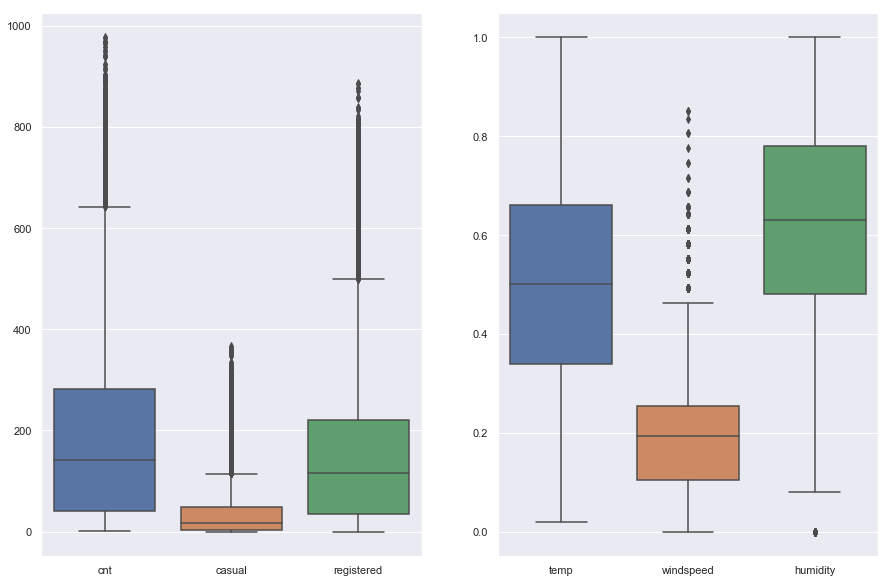

In [146]:
fig, (ax1, ax2) = plt.subplots(ncols=2, figsize=(15, 10))
with ProgressBar():
    sns.boxplot(data=hour_df[["cnt", "casual", "registered"]].compute(), ax=ax1)
    sns.boxplot(data=hour_df[["temp", "windspeed", "humidity"]].compute(), ax=ax2)

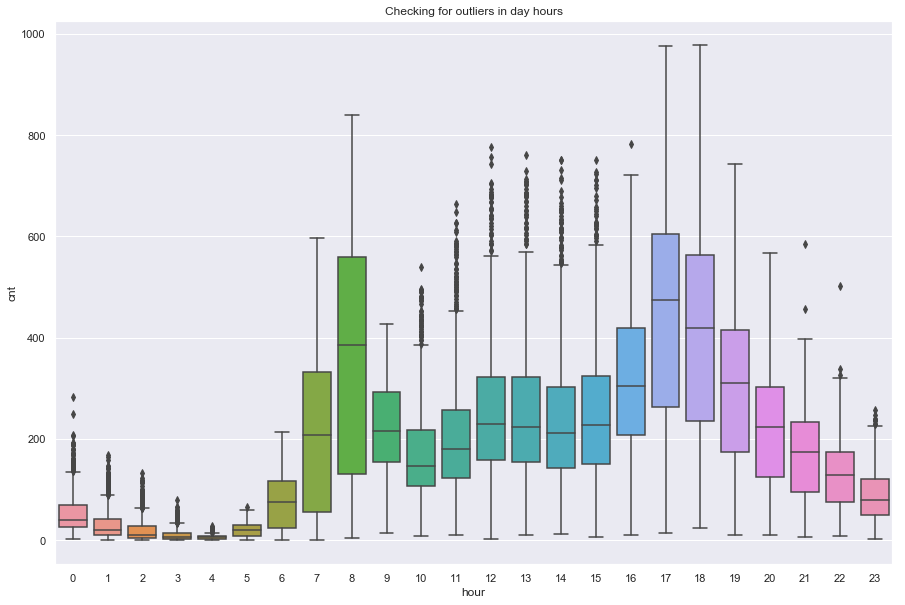

In [147]:
fig, ax = plt.subplots(figsize=(15, 10))
with ProgressBar():
    sns.boxplot(data=hour_df[["cnt", "hour"]].compute(), x="hour", y="cnt", ax=ax)
    ax.set(title="Checking for outliers in day hours")

#### Arranging outliers

Lets have a look at the IQR for the variable "windspeed".

In [148]:
from scipy import stats
Q1 = hour_df["windspeed"].quantile(0.25).compute()
Q3 = hour_df["windspeed"].quantile(0.75).compute()
IQR = Q3 - Q1
print(IQR)

0.1492


Using the IQR we will remove outliers.

In [149]:
hour_df_out = hour_df[
    ~(
        (hour_df["windspeed"] < (Q1 - 3.6 * IQR)).compute()
        | (hour_df["windspeed"] > (Q3 + 3.6 * IQR)).compute()
    )
]

C:\Users\andre\Anaconda3\lib\site-packages\dask\dataframe\core.py:2474: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  meta = self._meta[_extract_meta(key)]


In [150]:
hour_df_out.head(5)

date season  year month hour holiday weekday workingday weathersit  \
0 2011-01-01  Clear  2011     1    0       0     Sat          0          1   
1 2011-01-01  Clear  2011     1    1       0     Sat          0          1   
2 2011-01-01  Clear  2011     1    2       0     Sat          0          1   
3 2011-01-01  Clear  2011     1    3       0     Sat          0          1   
4 2011-01-01  Clear  2011     1    4       0     Sat          0          1   

   temp   atemp  humidity  windspeed  casual  registered  cnt  
0  0.24  0.2879      0.81        0.0       3          13   16  
1  0.22  0.2727      0.80        0.0       8          32   40  
2  0.22  0.2727      0.80        0.0       5          27   32  
3  0.24  0.2879      0.75        0.0       3          10   13  
4  0.24  0.2879      0.75        0.0       0           1    1

### 1.4 Visual Analysis

#### Distribution of numerical variables
In the first step of our visual interpretation we want to understand how our numerical variables are distributed. 

C:\Users\andre\Anaconda3\lib\site-packages\scipy\stats\stats.py:1713: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  return np.add.reduce(sorted[indexer] * weights, axis=axis) / sumval


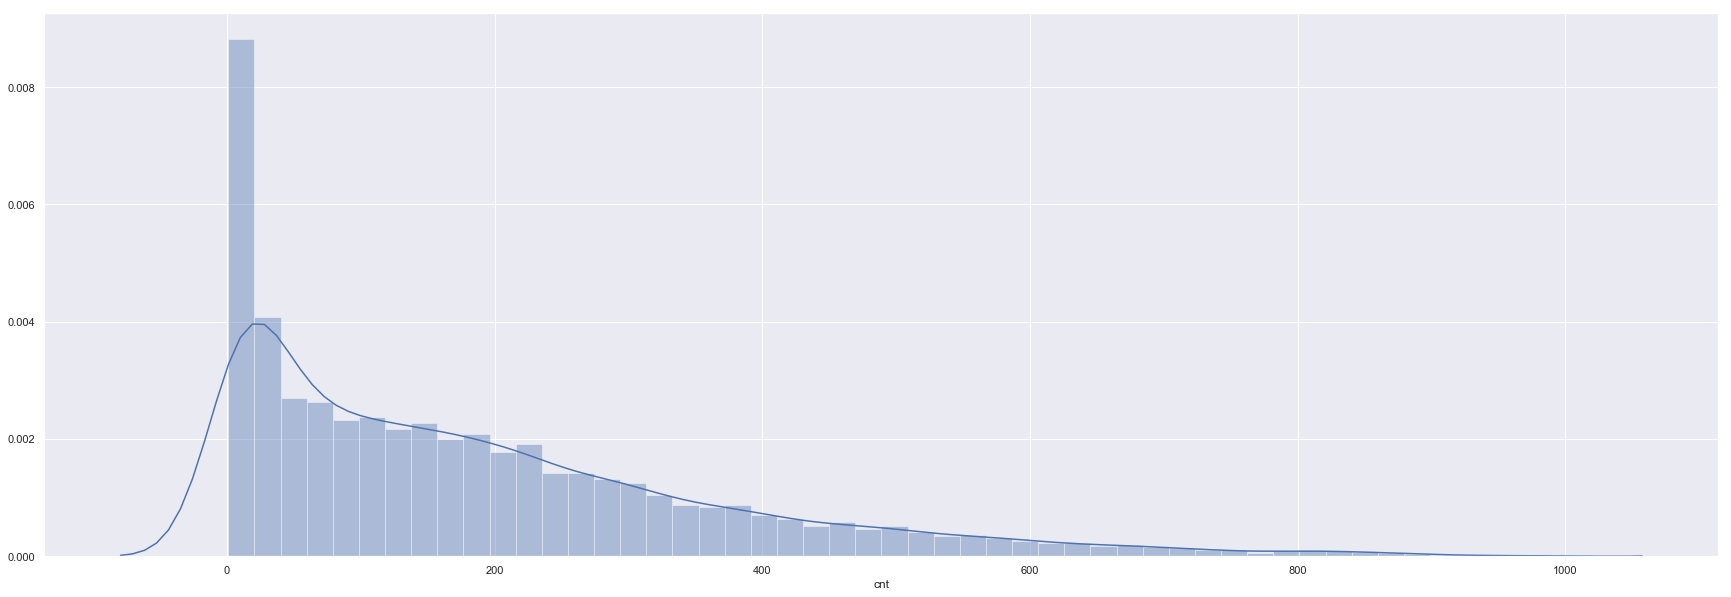

In [151]:
# view distribution of features (Count)
with ProgressBar():
    sns.distplot(hour_df['cnt'])

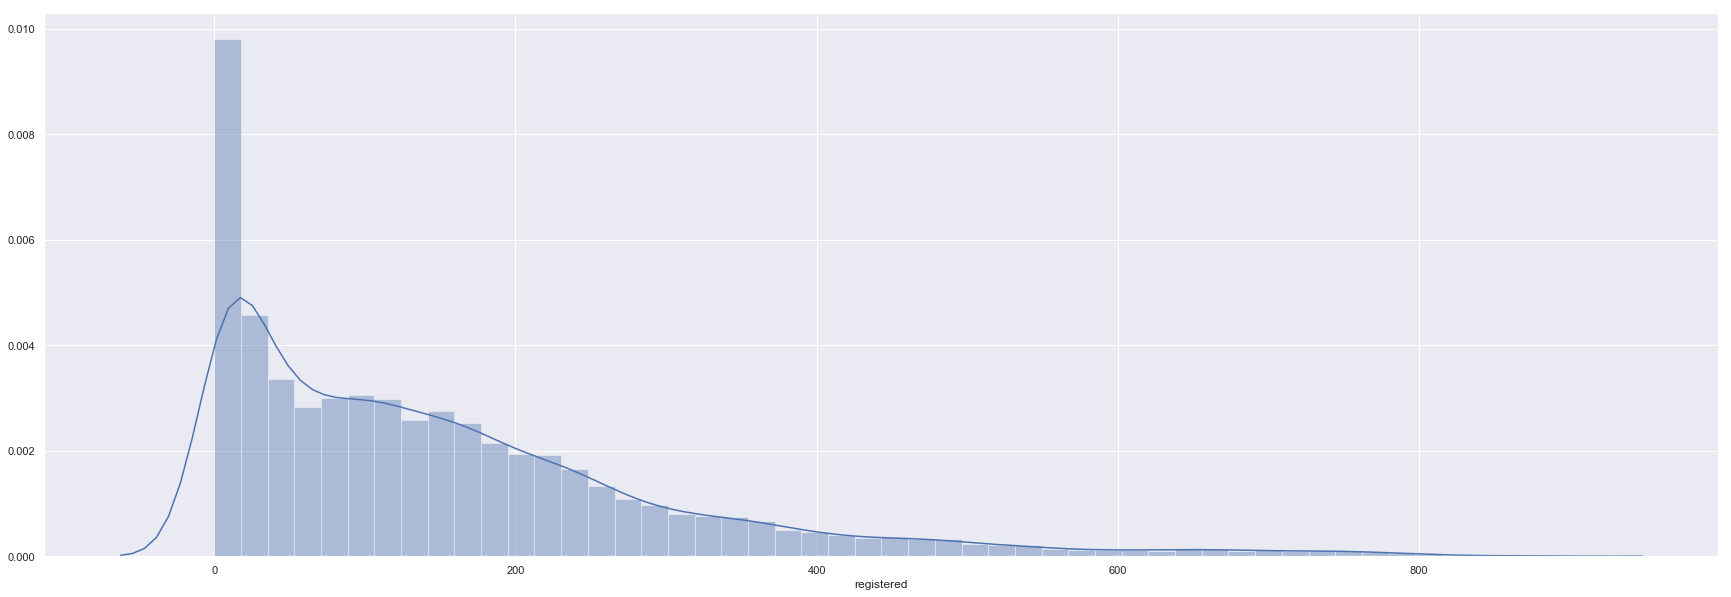

In [152]:
# Registered
with ProgressBar():
    sns.distplot(hour_df['registered'])

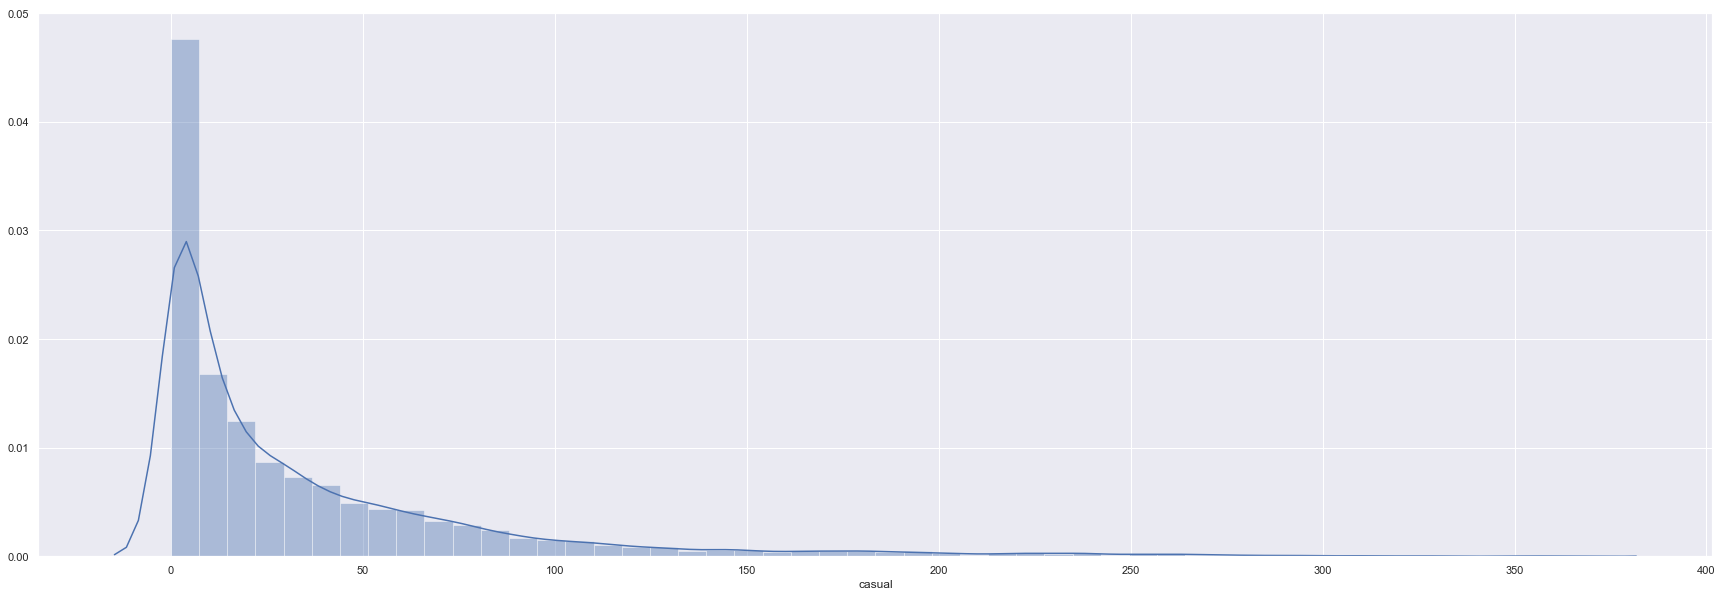

In [153]:
# Casual
with ProgressBar():
    sns.distplot(hour_df['casual'])

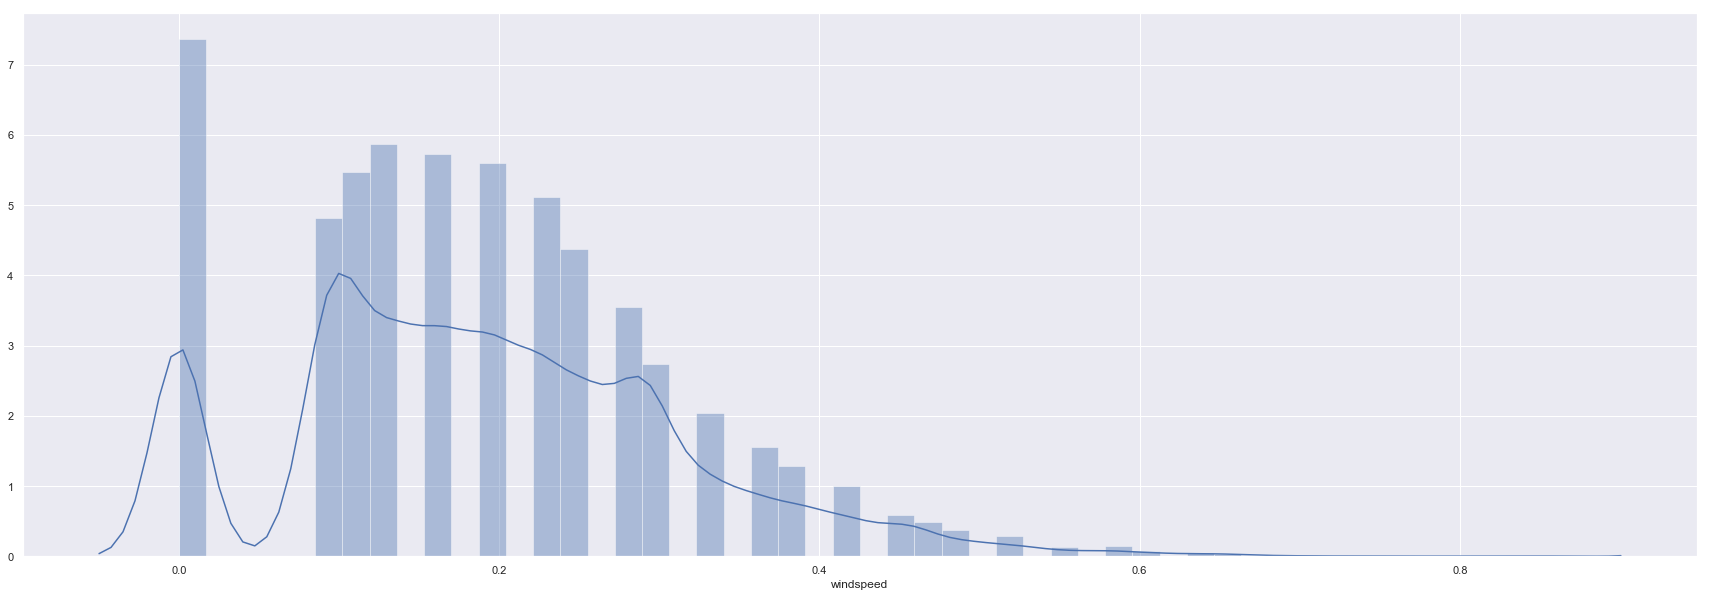

In [154]:
# windspeed
with ProgressBar():
    sns.distplot(hour_df['windspeed'])

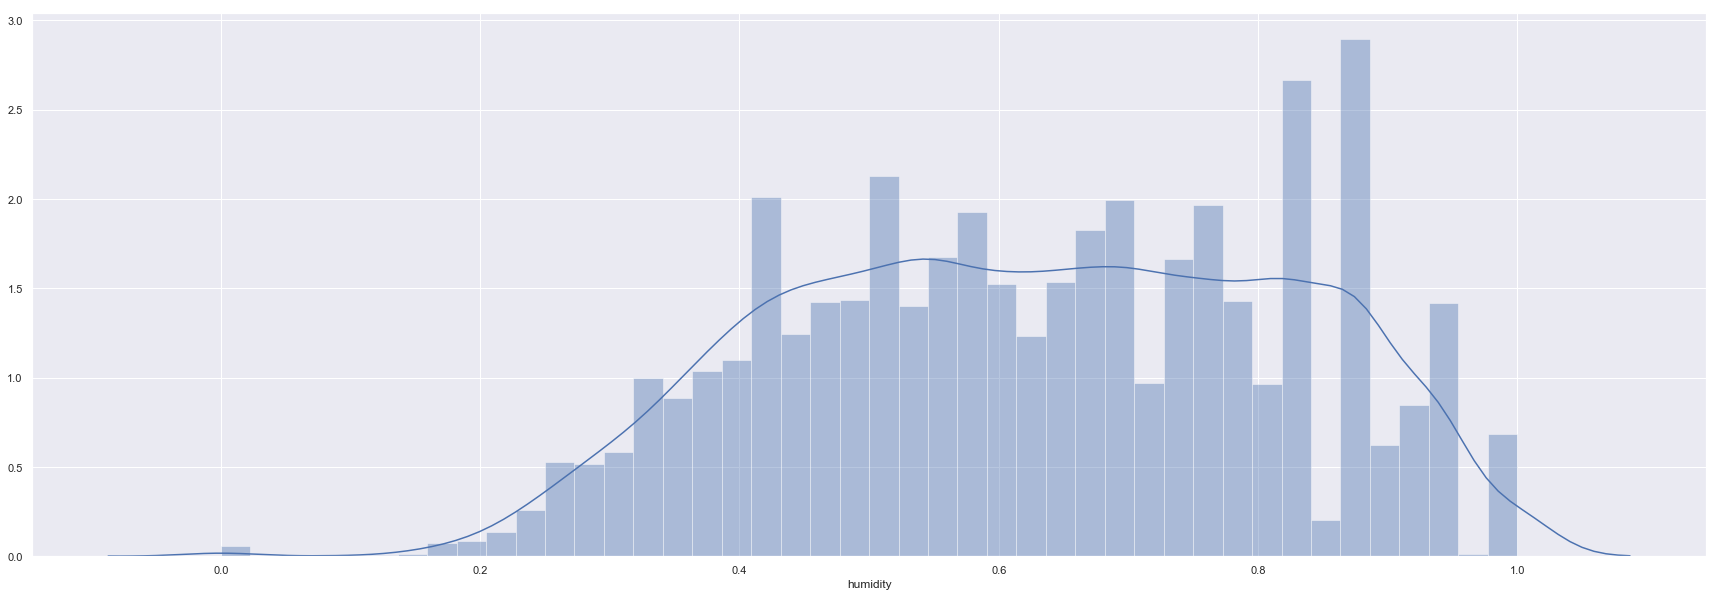

In [155]:
# Humidity
with ProgressBar():
    sns.distplot(hour_df['humidity'])

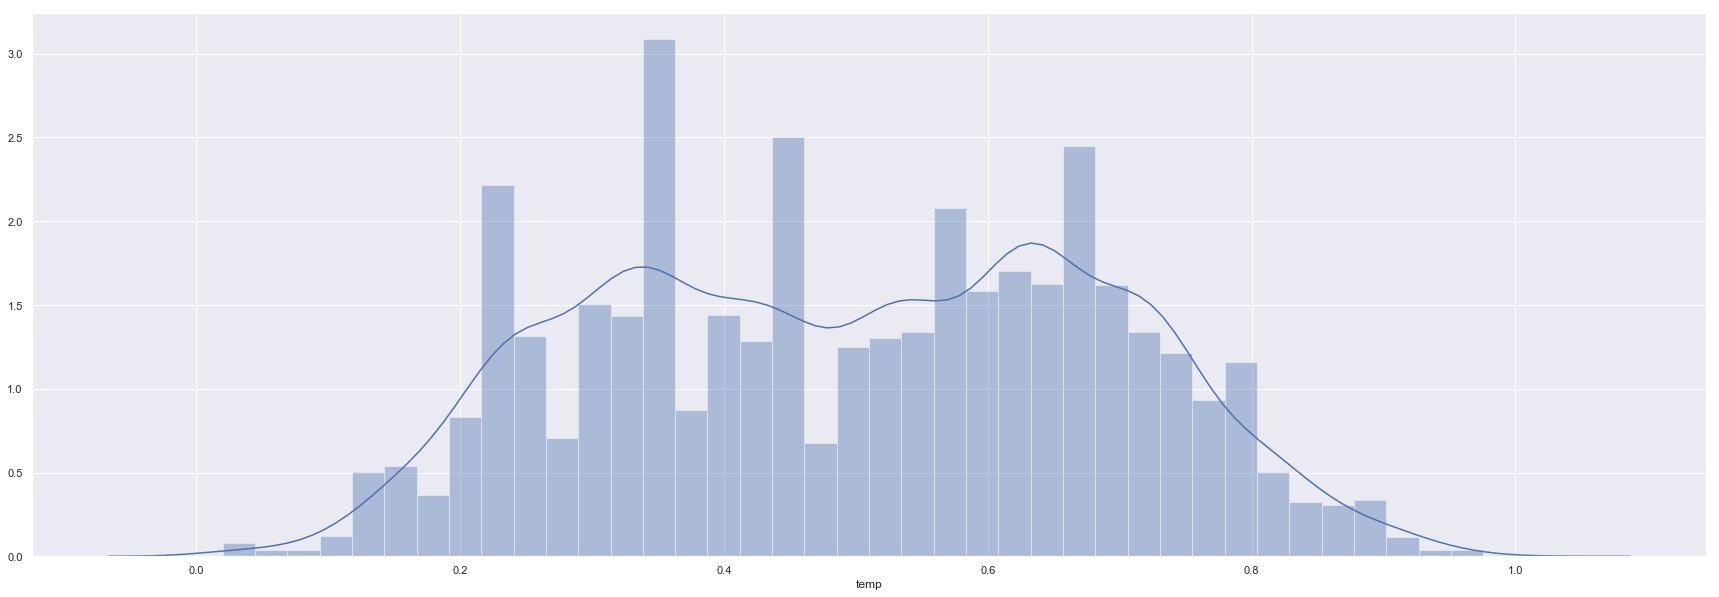

In [156]:
# Casual
with ProgressBar():
    sns.distplot(hour_df['temp'])

From the previous analysis we notice that some of our numeric variables are highly skewed. Skewness can harm regression algorithms and therefore it should be treated with a chosen threshold

In [157]:
from dask.array import stats as dask_stats

# hour_df[['cnt', 'windspeed', 'humidity', 'windspeed']]. apply(lambda x: abs(dask_stats.skew(x).compute())>0.75, axis=1)
print("cnt", dask_stats.skew(hour_df_out["cnt"]).compute() > 0.75)
print("humidity", dask_stats.skew(hour_df_out["humidity"]).compute() > 0.75)
print("windspeed", dask_stats.skew(hour_df_out["windspeed"]).compute() > 0.75)
print("temp", dask_stats.skew(hour_df_out["temp"]).compute() > 0.75)

cnt True
humidity False
windspeed False
temp False


Now we will adjust the skewness of the target variable 'cnt' by taking the square root

In [158]:
hour_df_out['cnt'] = da.sqrt(hour_df_out['cnt'])

In [159]:
# Checking if the skewness is adjusted
print("cnt", dask_stats.skew(hour_df_out["cnt"]).compute() > 0.75)

cnt False


#### Yearly distribution of rentals
Next we check how our target variable ("cnt") is distributed across the two years 2011 and 2012

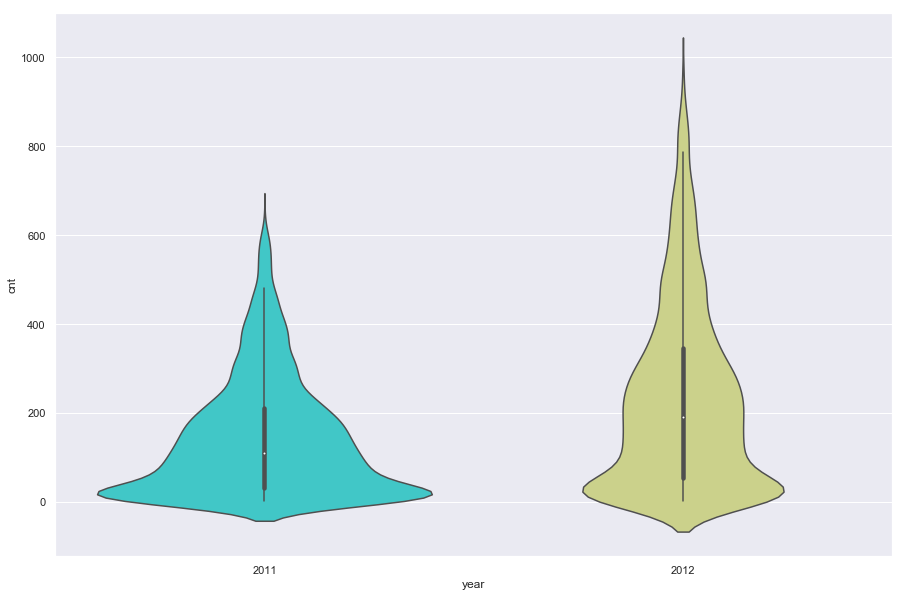

In [160]:
fig, ax = plt.subplots(figsize=(15, 10))
with ProgressBar():
    sns.set()
    sns.violinplot("year", "cnt", data=hour_df.compute(), palette="rainbow", ci=None)

#### Seasonal distribution of rentals (average)
Next have a look if there is a seasonal component in our dataset. As a fact, usage peeks during summer and fall, which makes sense. (for casual users)

Text(0.5, 1.0, 'Number of bikes rented per season')

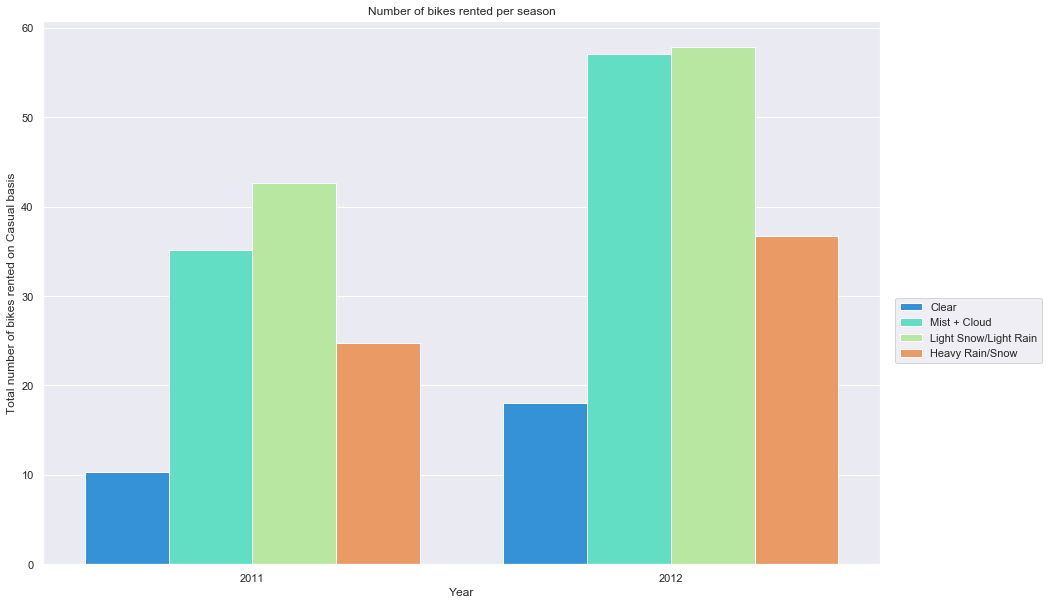

In [161]:
sns.set()
plt.figure(figsize=(15, 10))
sns.barplot(
    "year", "casual", hue="season", data=hour_df.compute(), palette="rainbow", ci=None
)
plt.legend(loc="upper right", bbox_to_anchor=(1.2, 0.5))
plt.xlabel("Year")
plt.ylabel("Total number of bikes rented on Casual basis")
plt.title("Number of bikes rented per season")

The same we do for registered users and get a similar output.

Text(0.5, 1.0, 'Number of bikes rented per season')

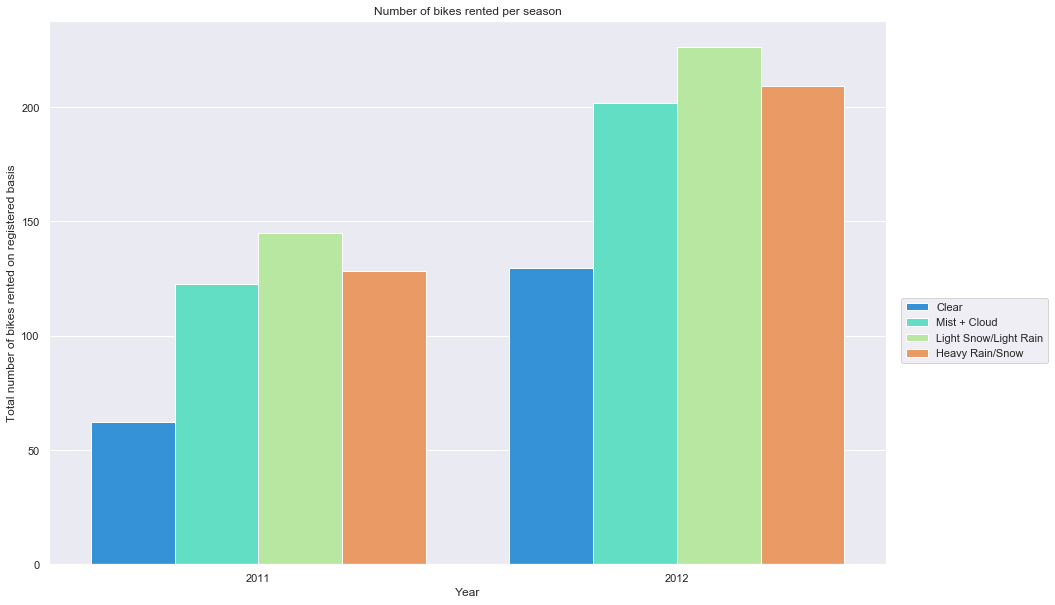

In [162]:
sns.set()
plt.figure(figsize=(15, 10))
sns.barplot(
    "year", "registered", hue="season", data=hour_df.compute(), palette="rainbow", ci=None
)
plt.legend(loc="upper right", bbox_to_anchor=(1.2, 0.5))
plt.xlabel("Year")
plt.ylabel("Total number of bikes rented on registered basis")
plt.title("Number of bikes rented per season")

#### Seasonal distribution of rentals (sum)
And finally we can also look at our varibale "cnt" to understand that users in general peaks in summer and fall.

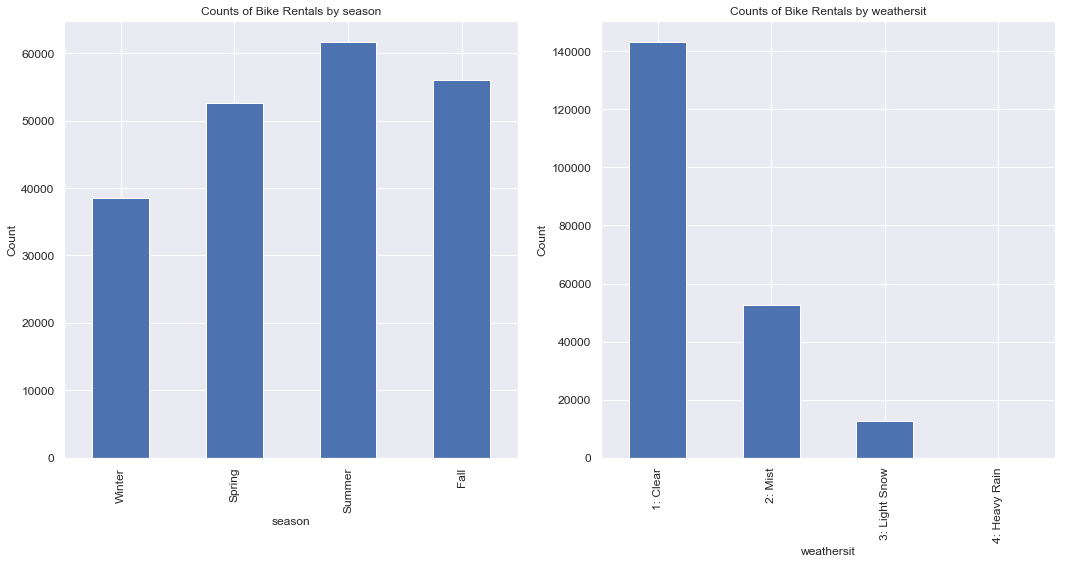

In [163]:
f, (ax1, ax2) = plt.subplots(nrows=1, ncols=2, figsize=(15, 8))

ax1 = (
    hour_df_out[["season", "cnt"]].compute()
    .groupby(["season"])
    .sum()
    .reset_index()
    .plot(
        kind="bar",
        legend=False,
        title="Counts of Bike Rentals by season",
        stacked=True,
        fontsize=12,
        ax=ax1,
    )
)
ax1.set_xlabel("season", fontsize=12)
ax1.set_ylabel("Count", fontsize=12)
ax1.set_xticklabels(["Winter", "Spring", "Summer", "Fall"])

ax2 = (
    hour_df_out[["weathersit", "cnt"]].compute()
    .groupby(["weathersit"])
    .sum()
    .reset_index()
    .plot(
        kind="bar",
        legend=False,
        stacked=True,
        title="Counts of Bike Rentals by weathersit",
        fontsize=12,
        ax=ax2,
    )
)

ax2.set_xlabel("weathersit", fontsize=12)
ax2.set_ylabel("Count", fontsize=12)
ax2.set_xticklabels(["1: Clear", "2: Mist", "3: Light Snow", "4: Heavy Rain"])

f.tight_layout()

#### Monthly distribution of rentals (average)
The results we get match with the seasonal analysis above.

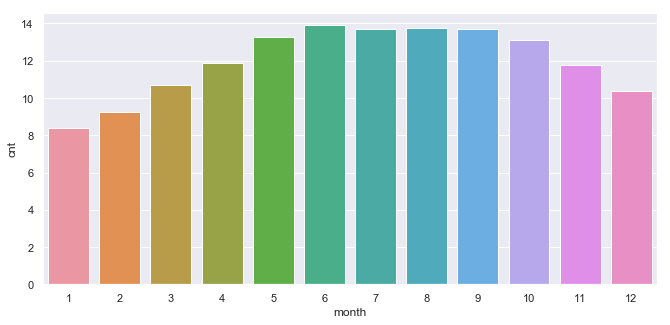

In [164]:
sns.set()
plt.figure(figsize=(11, 5))
sns.barplot("month", "cnt", data=hour_df_out.compute(), ci=None)

Splitting for whether the day is a workday or not gives us useful insights.

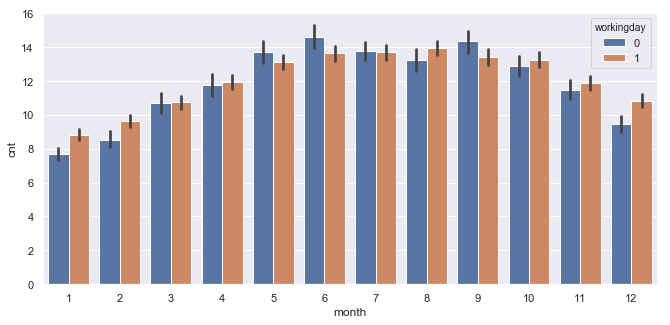

In [165]:
plt.figure(figsize=(11, 5))
sns.barplot(x="month", y="cnt", hue="workingday", data=hour_df_out.compute())
plt.show()

Additionally we check how the year influences the average and see that the average usage in year 2012 was always higher (logically if the business is growing).

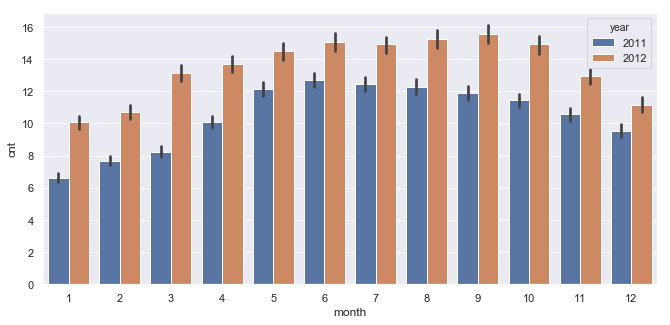

In [166]:
plt.figure(figsize=(11, 5))
sns.barplot(x="month", y="cnt", hue="year", data=hour_df_out.compute())
plt.show()

#### Hourly distribution of rentals over month (average)
Now lets have a look how the average usage changes over month for each season:

[Text(0.5, 1.0, 'Season wise hourly distribution of counts')]

<Figure size 1080x576 with 0 Axes>

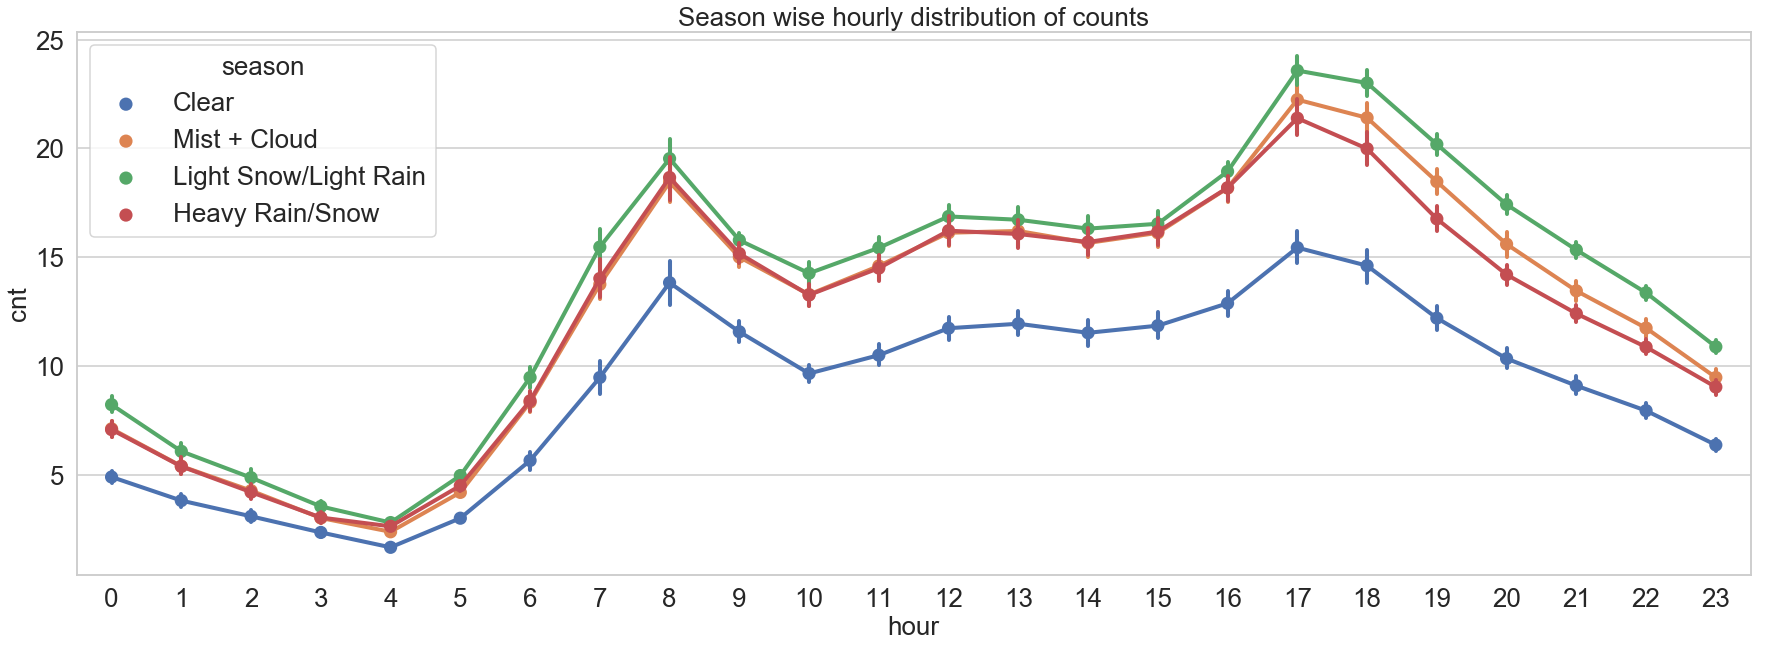

In [167]:
# Configuring plotting visual and sizes
plt.figure(figsize=(15, 8))
sns.set_style("whitegrid")
sns.set_context("talk")
params = {
    "legend.fontsize": "x-large",
    "figure.figsize": (30, 10),
    "axes.labelsize": "x-large",
    "axes.titlesize": "x-large",
    "xtick.labelsize": "x-large",
    "ytick.labelsize": "x-large",
}

plt.rcParams.update(params)

fig, ax = plt.subplots()
sns.pointplot(
    data=hour_df_out[["hour", "cnt", "season"]].compute(), x="hour", y="cnt", hue="season", ax=ax
)
ax.set(title="Season wise hourly distribution of counts")

#### Daily distribution of rentals (average)
Daily peaks occur in the early morning (7-9) and late afternoon/evening (16-20).

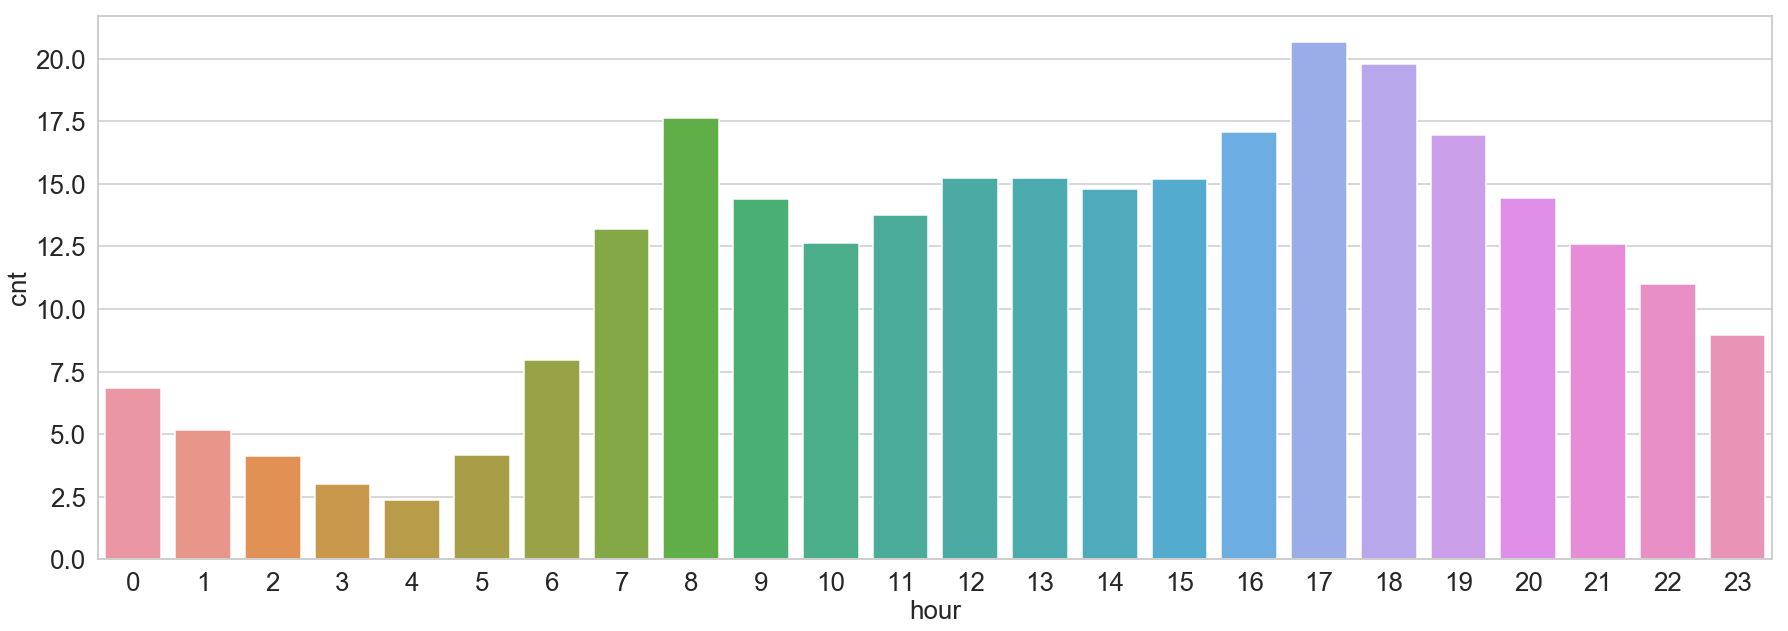

In [168]:
sns.barplot("hour", "cnt", data=hour_df_out.compute(), ci=None)

#### Weekday distribution of rentals (average)

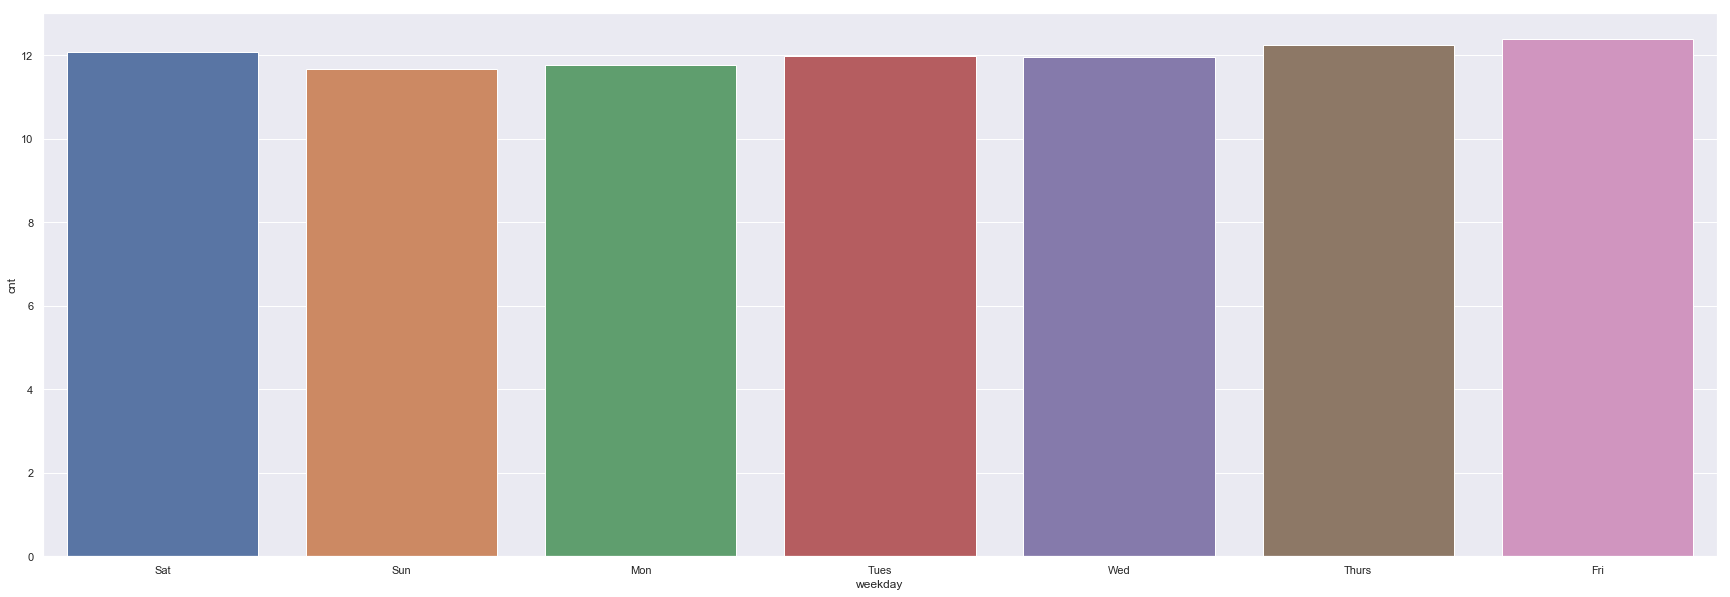

In [169]:
sns.set()
sns.barplot("weekday", "cnt", data=hour_df_out.compute(), ci=None)

#### Hourly distribution of rentals per weekdays (average)

[Text(0.5, 1.0, 'Season wise hourly distribution of counts')]

<Figure size 1080x576 with 0 Axes>

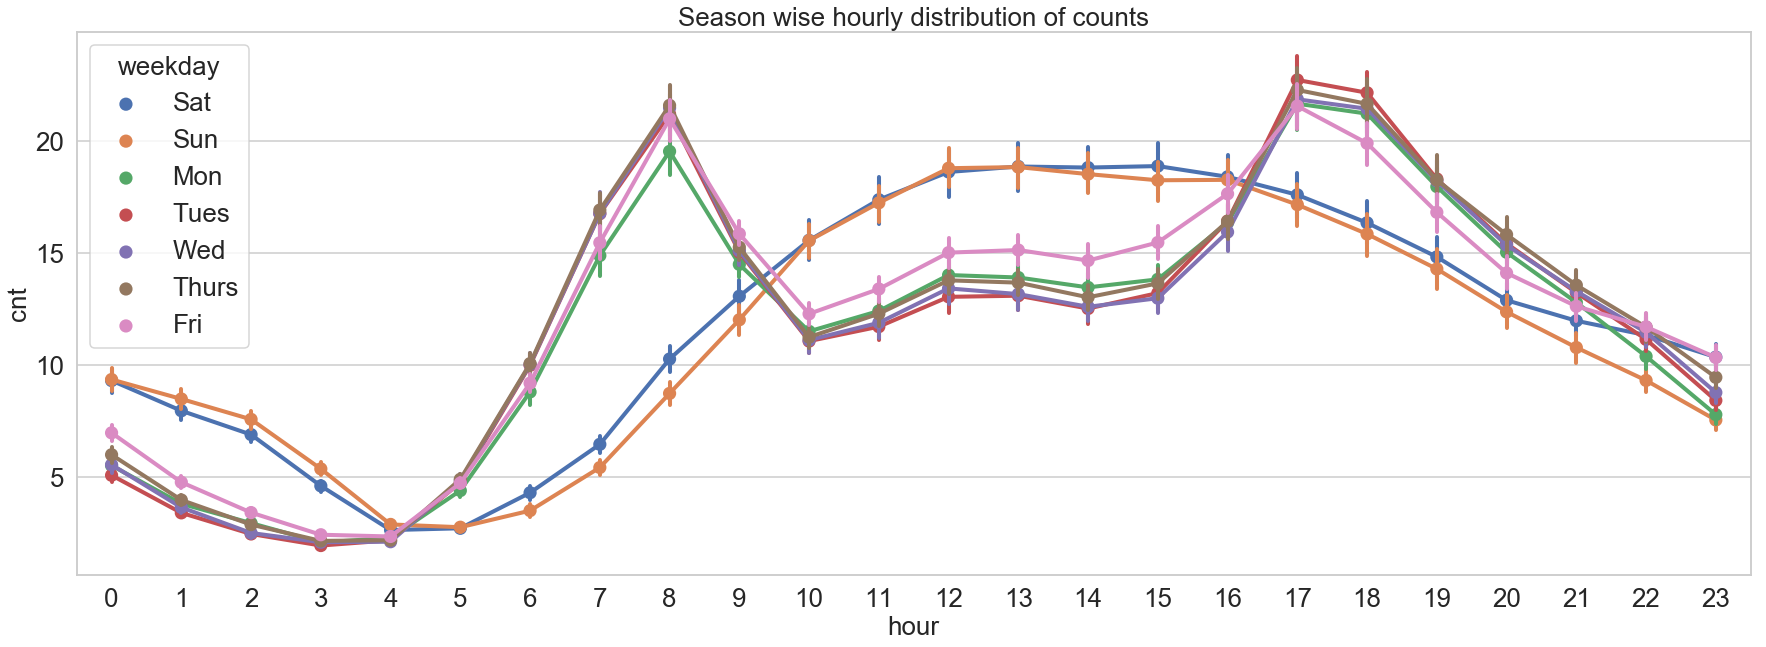

In [170]:
# Configuring plotting visual and sizes
plt.figure(figsize=(15, 8))
sns.set_style("whitegrid")
sns.set_context("talk")
params = {
    "legend.fontsize": "x-large",
    "figure.figsize": (30, 10),
    "axes.labelsize": "x-large",
    "axes.titlesize": "x-large",
    "xtick.labelsize": "x-large",
    "ytick.labelsize": "x-large",
}

plt.rcParams.update(params)
fig, ax = plt.subplots()
sns.pointplot(
    data=hour_df_out[["hour", "cnt", "weekday"]].compute(),
    x="hour",
    y="cnt",
    hue="weekday",
    ax=ax,
)
ax.set(title="Season wise hourly distribution of counts")

#### Average distribution whether holiday or not
People rent less during holidays and more during working days

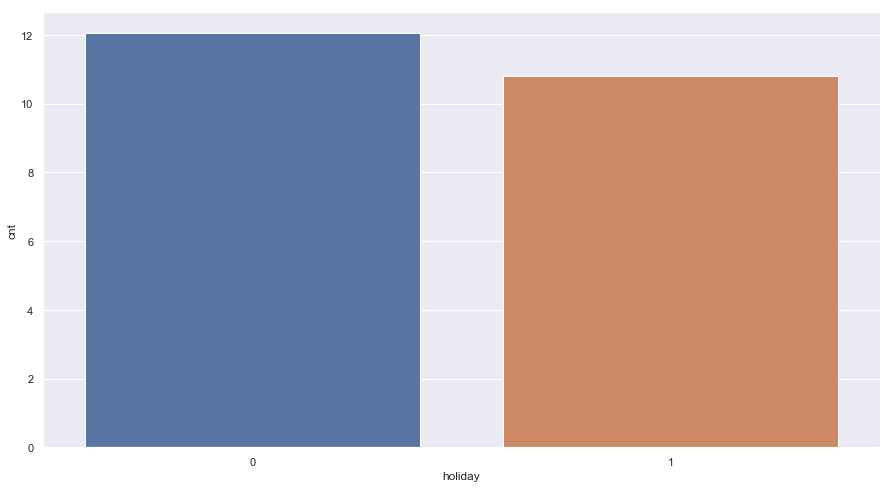

In [171]:
plt.figure(figsize=(15, 8))
sns.set()
sns.barplot("holiday", "cnt", data=hour_df_out.compute(), ci=None)

#### Average distribution whether workday or not

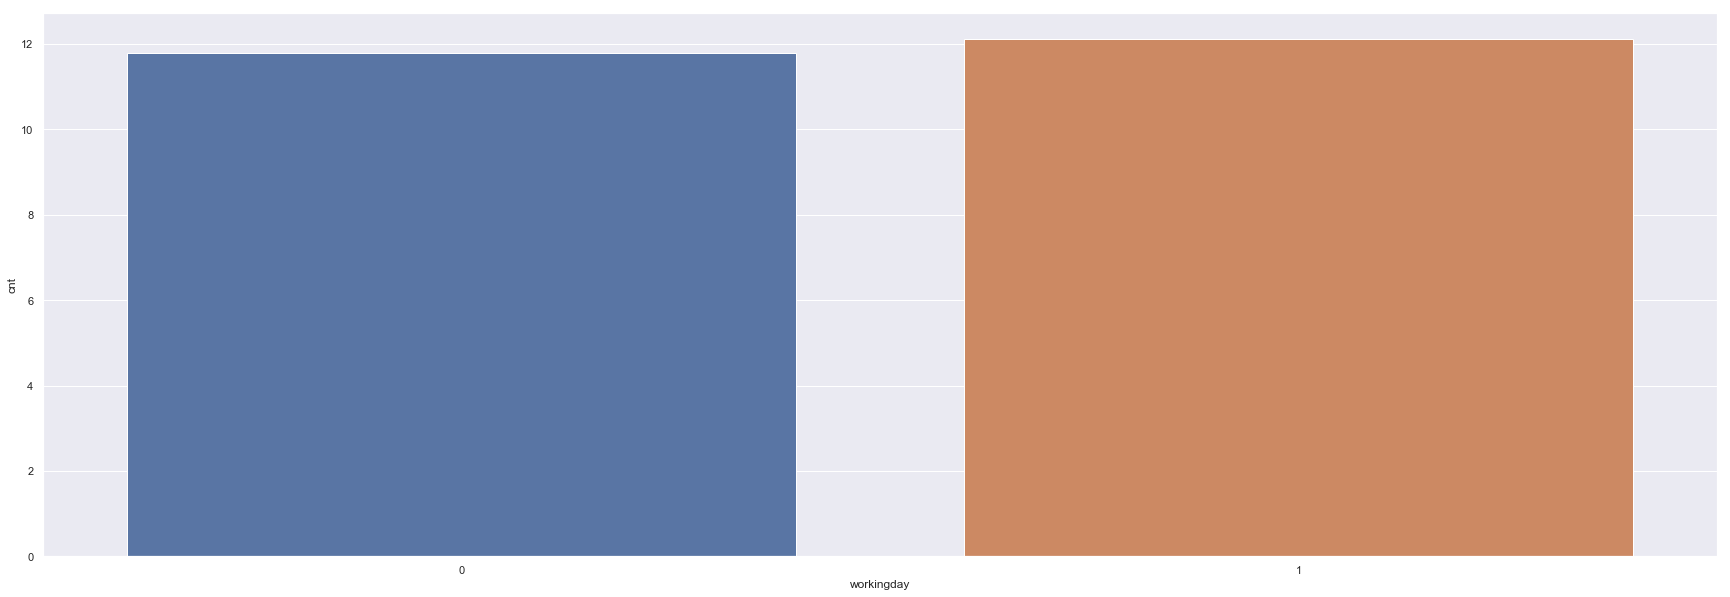

In [172]:
sns.set()
sns.barplot("workingday", "cnt", data=hour_df_out.compute(), ci=None)

C:\Users\andre\Anaconda3\lib\site-packages\matplotlib\axes\_base.py:3604: MatplotlibDeprecationWarning: 
The `ymin` argument was deprecated in Matplotlib 3.0 and will be removed in 3.2. Use `bottom` instead.
  alternative='`bottom`', obj_type='argument')
C:\Users\andre\Anaconda3\lib\site-packages\matplotlib\axes\_base.py:3215: MatplotlibDeprecationWarning: 
The `xmin` argument was deprecated in Matplotlib 3.0 and will be removed in 3.2. Use `left` instead.
  alternative='`left`', obj_type='argument')


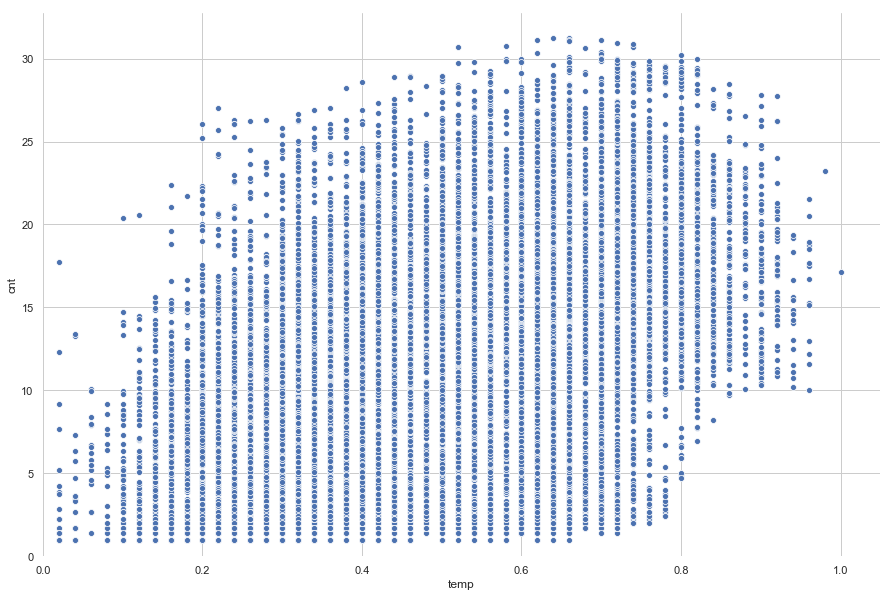

In [173]:
# Plot a scatter plot of Temp vs. Count
sns.set(style="whitegrid")
f, ax = plt.subplots(figsize=(15, 10))
sns.despine(f, left=True, bottom=True)
  
with ProgressBar():
    sns.scatterplot(x="temp", y="cnt",
                 data=hour_df_out.compute(), ax=ax)
    plt.ylim(ymin=0)
    plt.xlim(xmin=0)

C:\Users\andre\Anaconda3\lib\site-packages\matplotlib\axes\_base.py:3604: MatplotlibDeprecationWarning: 
The `ymin` argument was deprecated in Matplotlib 3.0 and will be removed in 3.2. Use `bottom` instead.
  alternative='`bottom`', obj_type='argument')
C:\Users\andre\Anaconda3\lib\site-packages\matplotlib\axes\_base.py:3215: MatplotlibDeprecationWarning: 
The `xmin` argument was deprecated in Matplotlib 3.0 and will be removed in 3.2. Use `left` instead.
  alternative='`left`', obj_type='argument')


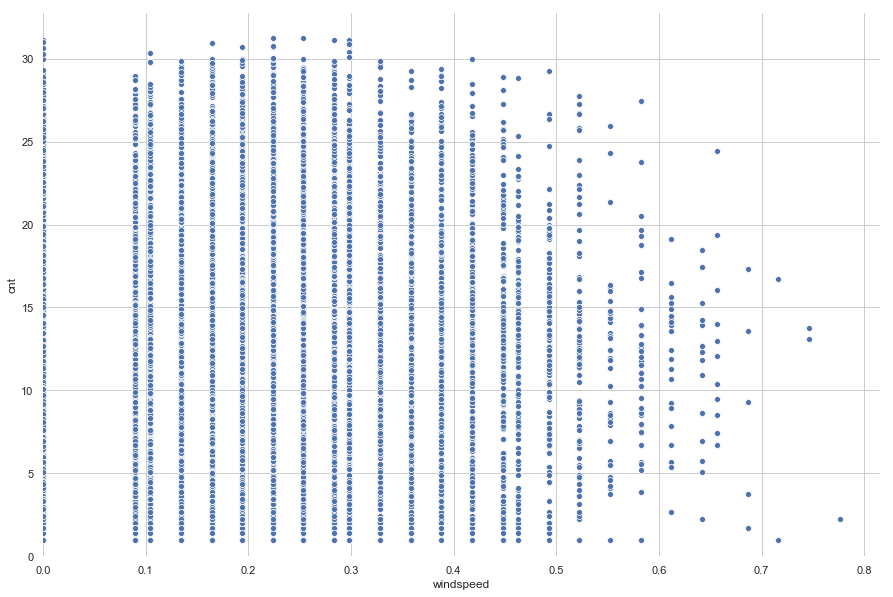

In [174]:
# Plot a scatter plot of Windspeed vs. Count
sns.set(style="whitegrid")
f, ax = plt.subplots(figsize=(15, 10))
sns.despine(f, left=True, bottom=True)
  
with ProgressBar():
    sns.scatterplot(x="windspeed", y="cnt",
                 data=hour_df_out.compute(), ax=ax)
    plt.ylim(ymin=0)
    plt.xlim(xmin=0)

C:\Users\andre\Anaconda3\lib\site-packages\matplotlib\axes\_base.py:3604: MatplotlibDeprecationWarning: 
The `ymin` argument was deprecated in Matplotlib 3.0 and will be removed in 3.2. Use `bottom` instead.
  alternative='`bottom`', obj_type='argument')
C:\Users\andre\Anaconda3\lib\site-packages\matplotlib\axes\_base.py:3215: MatplotlibDeprecationWarning: 
The `xmin` argument was deprecated in Matplotlib 3.0 and will be removed in 3.2. Use `left` instead.
  alternative='`left`', obj_type='argument')


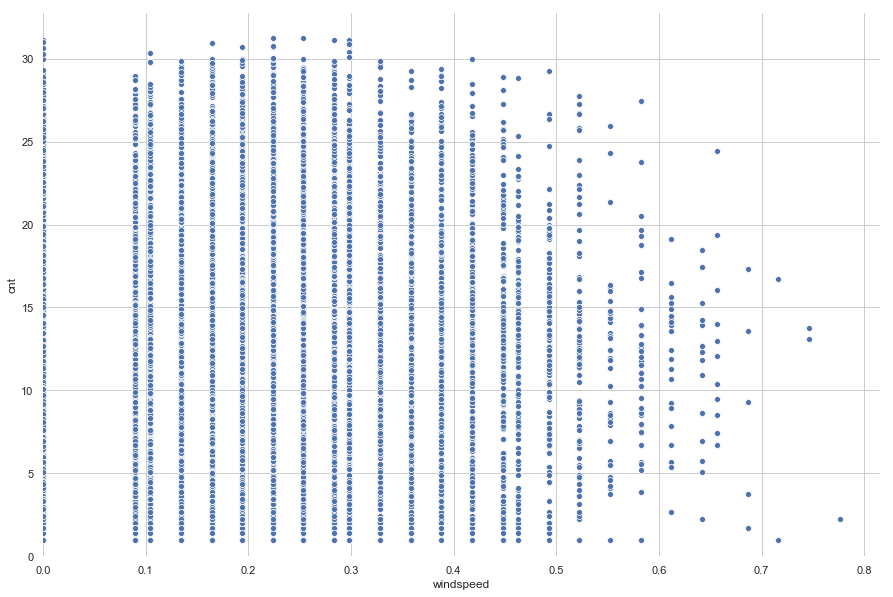

In [175]:
# Plot a scatter plot of Windspeed vs. Count
sns.set(style="whitegrid")
f, ax = plt.subplots(figsize=(15, 10))
sns.despine(f, left=True, bottom=True)
  
with ProgressBar():
    sns.scatterplot(x="windspeed", y="cnt",
                 data=hour_df_out.compute(), ax=ax)
    plt.ylim(ymin=0)
    plt.xlim(xmin=0)

C:\Users\andre\Anaconda3\lib\site-packages\matplotlib\axes\_base.py:3604: MatplotlibDeprecationWarning: 
The `ymin` argument was deprecated in Matplotlib 3.0 and will be removed in 3.2. Use `bottom` instead.
  alternative='`bottom`', obj_type='argument')
C:\Users\andre\Anaconda3\lib\site-packages\matplotlib\axes\_base.py:3215: MatplotlibDeprecationWarning: 
The `xmin` argument was deprecated in Matplotlib 3.0 and will be removed in 3.2. Use `left` instead.
  alternative='`left`', obj_type='argument')


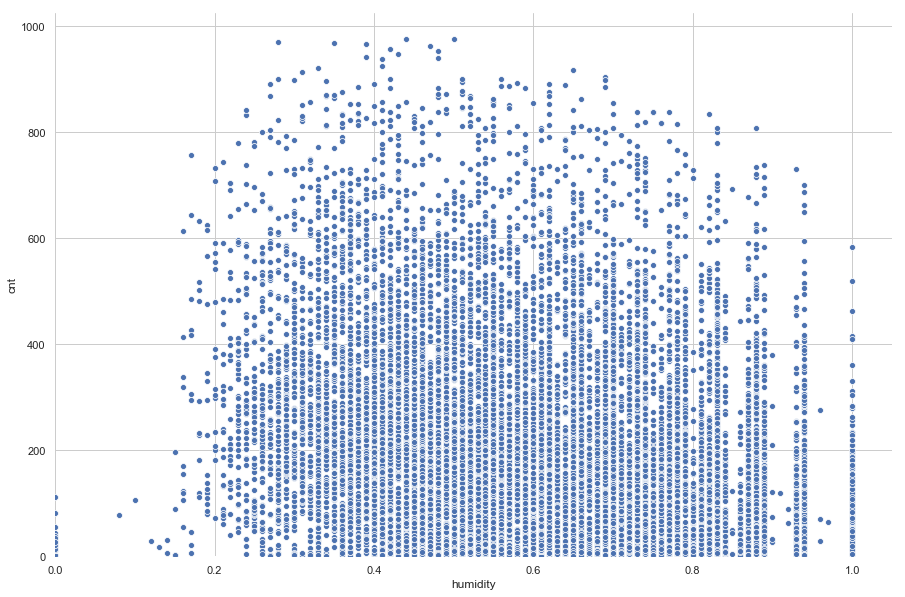

In [176]:
# Plot a scatter plot of Temp vs. Count
sns.set(style="whitegrid")
f, ax = plt.subplots(figsize=(15, 10))
sns.despine(f, left=True, bottom=True)
  
with ProgressBar():
    sns.scatterplot(x="humidity", y="cnt",
                 data=hour_df.compute(), ax=ax)
    plt.ylim(ymin=0)
    plt.xlim(xmin=0)

### 1.5 Correlations
To understand how our variables are correlated to our target variable we will use visual representations. 

#### Correlation Heatmap
The correlation headmap below provides us with great insights on how each variable is correlated with the "cnt" variable.

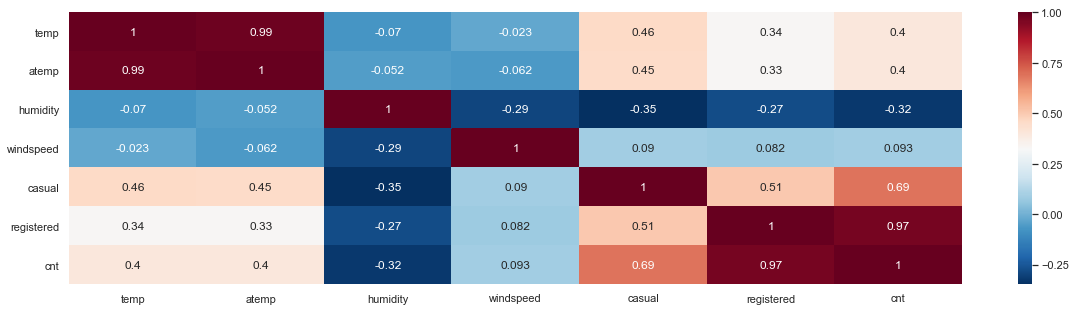

In [177]:
plt.figure(figsize=(20, 5))
sns.heatmap(hour_df.corr().compute(), cmap="RdBu_r", annot=True)

#### Weather conditions

##### atemp
For the normalized feeling temperature "atemp" 0 is a low temperature while 1 is the maximum. We can see a peak in rentals as the weather gets warmer, then a decline towards the highest temperatures. 

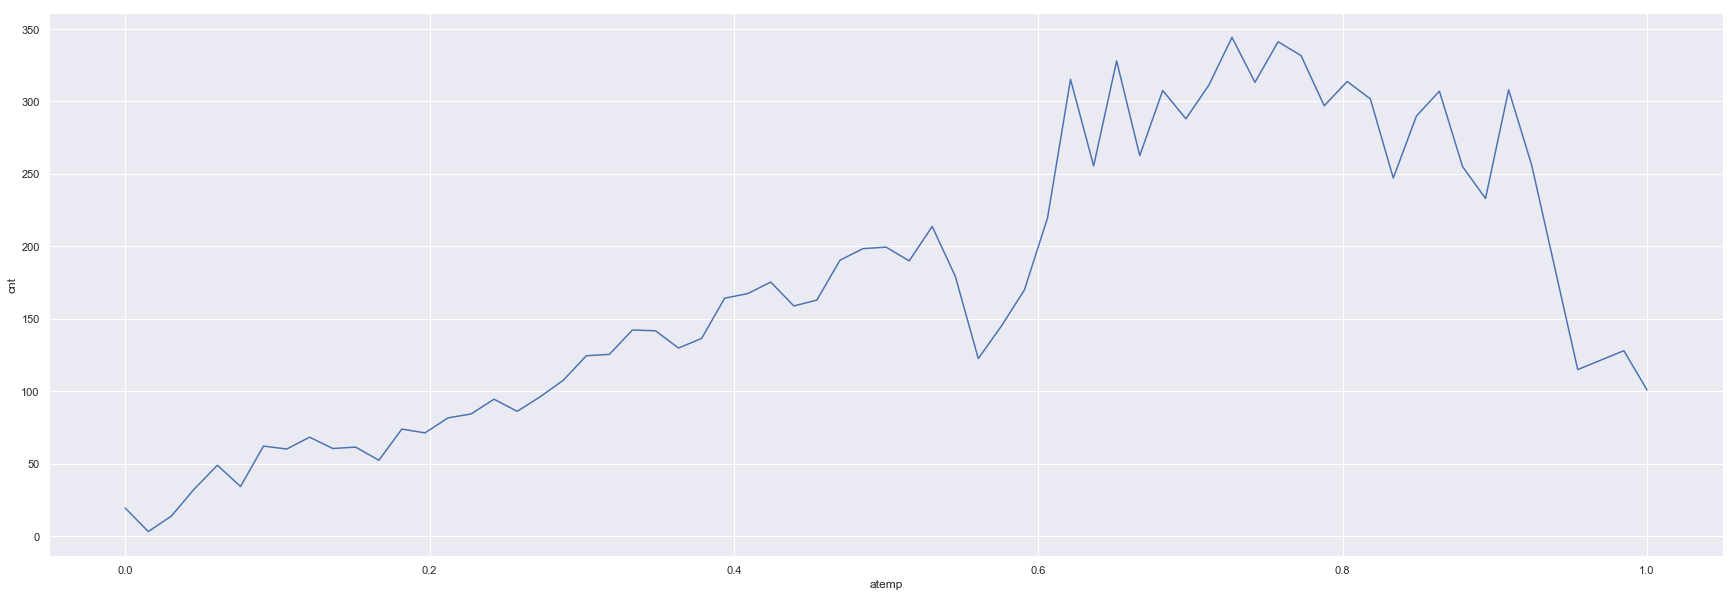

In [178]:
sns.set()
sns.lineplot("atemp", "cnt", data=hour_df.compute(), palette="rainbow", ci=None)

##### windspeed
In general, we observe that the higher the windseep the lower the number of bikes rented, except for a few peaks in high wind speed which could be explained by outliers (see the two barplots below with and without barplot). 
As we can see our outlier handling provides a more logical graph!

With outliers: 

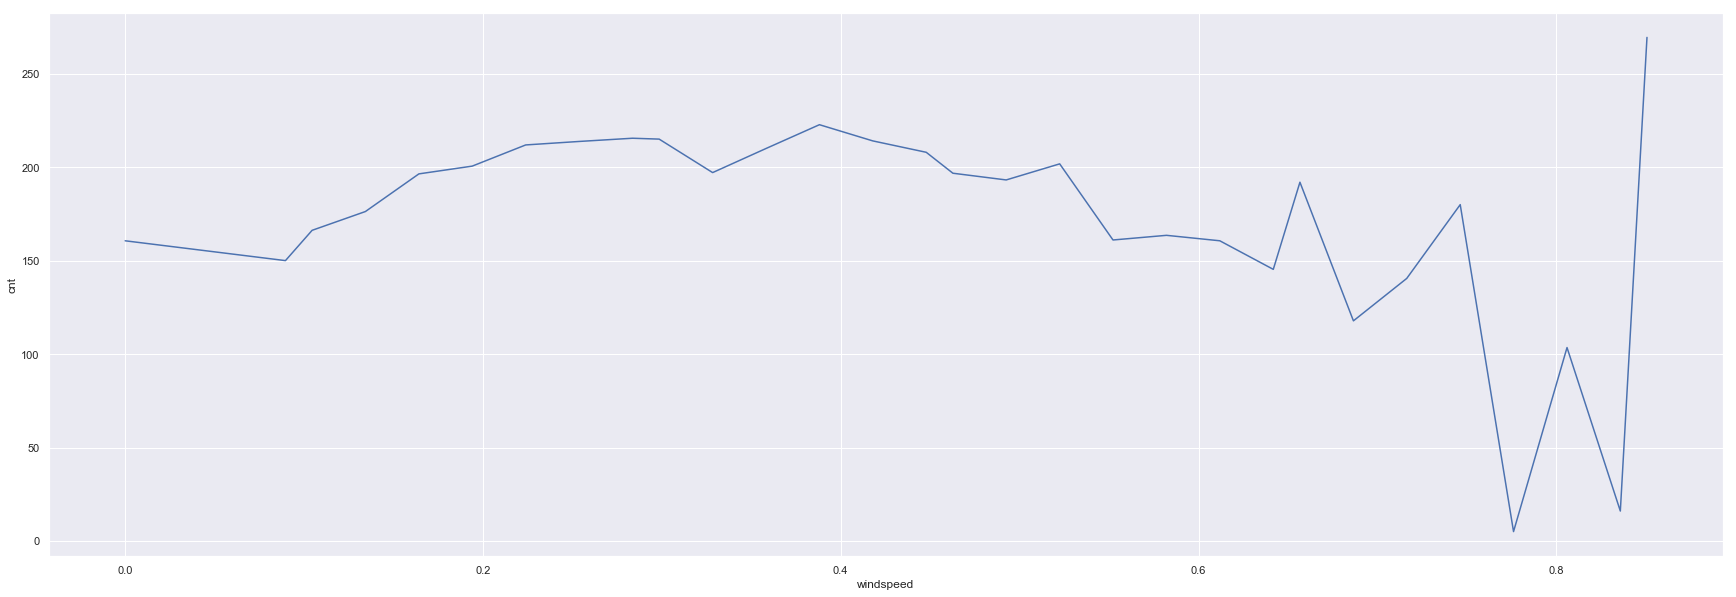

In [179]:
sns.set()
sns.lineplot("windspeed", "cnt", data=hour_df.compute(), palette="rainbow", ci=None)

Without outliers:

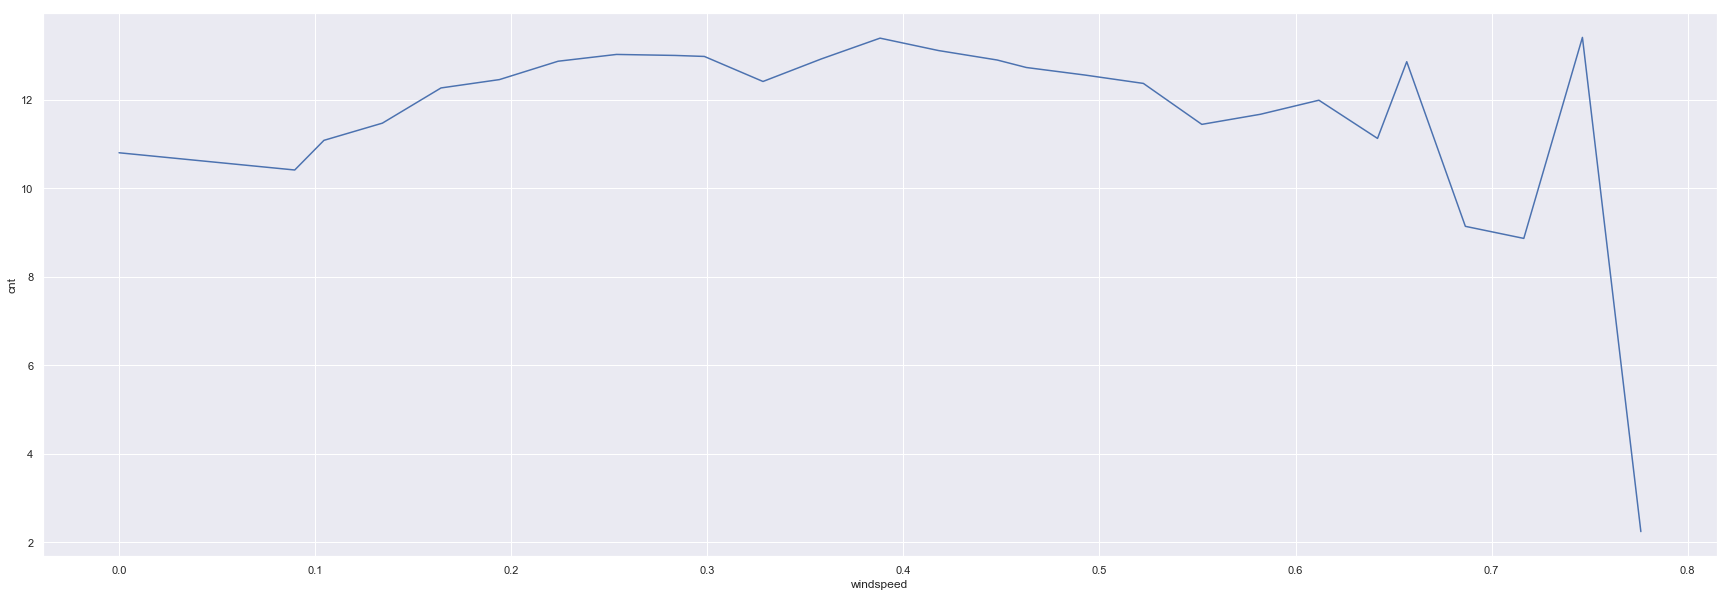

In [180]:
sns.set()
sns.lineplot("windspeed", "cnt", data=hour_df_out.compute(), palette="rainbow", ci=None)

##### weathersit
For the normalized weather situation "weathersit" 1 is considered the best weather situation, while 4 represents an extreme weather condition (natural disasters). Logically, as the weather condition worsens the rentals decrease.

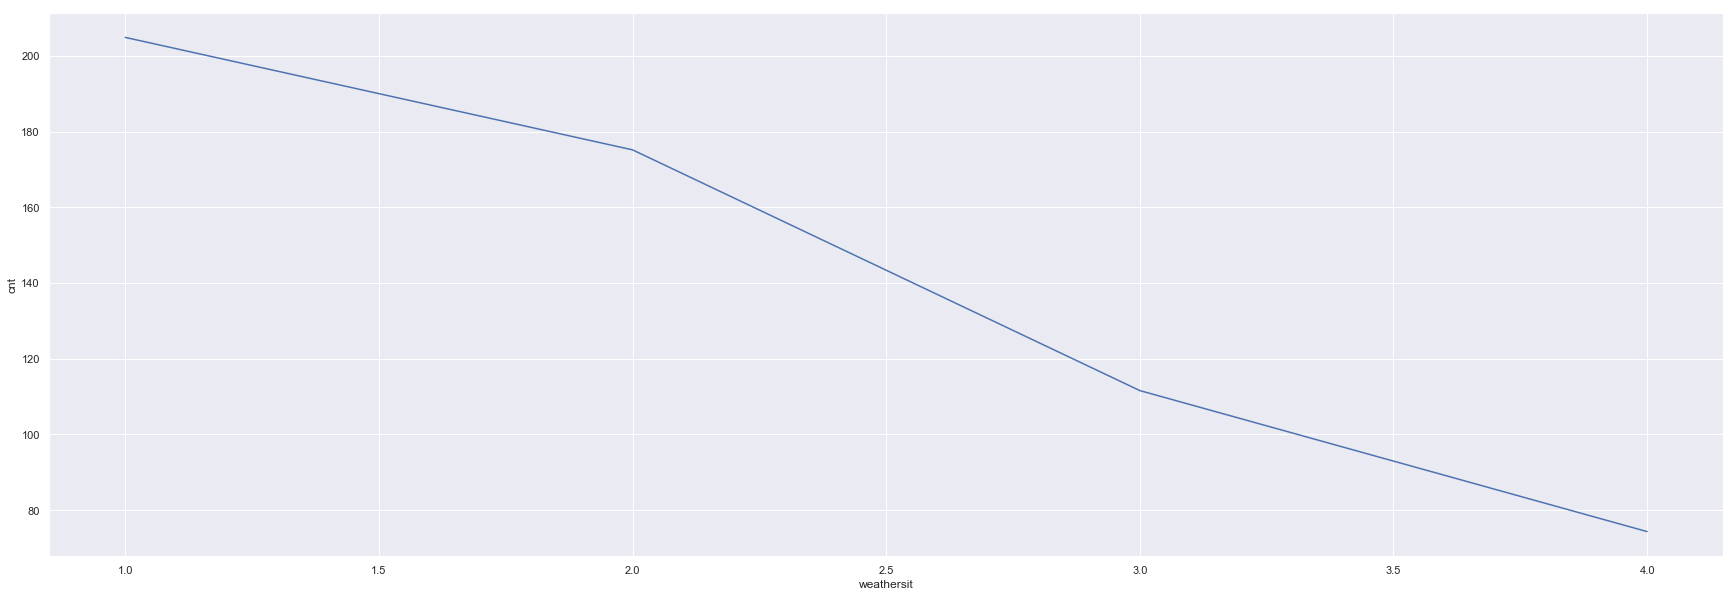

In [181]:
sns.set()
sns.lineplot("weathersit", "cnt", data=hour_df.compute(), palette="rainbow", ci=None)

## 2 Feature Engineering and Selection

### 2.1 Feature Creation

#### Heat Index

Normalized temperature can be used to calculate real temperature in Celcius which can be used to calculate the head index (HI) as well as wind chill index (WCI) which may or may not correlate with our target variable.

Given the equation used to normalize temperature, (t-t_min)/(t_max-t_min) where t_max is 39 and t_min is -8, we can derive the equation for temperature to be as follows:

temp_real = 47*temp - 8

In [182]:
# Calculate the real temperature using the above equation
hour_df_out["temp_real"] = 47 * hour_df_out["temp"] - 8

Using the results from real temperature in Celcius, we can use these values to calculate the heat index or humiture (HI), which is an index that combines air temperature and relative humidity. The formula used for calculation is as follows:
HI = c1 + c2T + c3R + c4TR + c5T^2 + c6R^2 + c7RT^2 + c8TR^2 + c9T^2R^2
where T is the temperature (in degrees Celcius) and R is the relative humidity (percentage value between 0 and 100)

c1 = −8.78469475556,
c2 = 1.61139411,
c3 = 2.33854883889,
c4 = -0.14611605,
c5 = -0.012308094,
c6 = -0.0164248277778,
c7 = 0.002211732,
c8 = 0.00072546,
c9 = -0.000003582,

In [183]:
hour_df_out["heat_index"] = (
    -8.78469475556
    + (1.61139411 * (hour_df_out["temp_real"]))
    + (2.33854883889 * hour_df_out["humidity"] * 100)
    + (-0.14611605 * hour_df_out["temp_real"] * hour_df_out["humidity"] * 100)
    + (-0.012308094 * (hour_df_out["temp_real"]) ** 2)
    + (-0.0164248277778 * (hour_df_out["humidity"] * 100) ** 2)
    + (
        0.002211732
        * ((hour_df_out["temp_real"]) ** 2)
        * (hour_df_out["humidity"] * 100)
    )
    + (0.00072546 * hour_df_out["temp_real"] * (hour_df_out["humidity"] * 100) ** 2)
    + (
        -0.000003582
        * ((hour_df_out["humidity"] * 100) ** 2)
        * ((hour_df_out["temp_real"]) ** 2)
    )
)

In [184]:
hour_df_out.head(1)

date season  year month hour holiday weekday workingday weathersit  \
0 2011-01-01  Clear  2011     1    0       0     Sat          0          1   

   temp   atemp  humidity  windspeed  casual  registered  cnt  temp_real  \
0  0.24  0.2879      0.81        0.0       3          13  4.0       3.28   

   heat_index  
0     56.4938

#### Wind Chill Index (WCI)

We can also calculate the Wind Chill Index (WCI) which is the lowering of body temperature due to the passing-flow of lower-temperature air. 

The formula used is as follows:
WCI = (10*SQRT(windspeed) - windspeed + 10.5)*(33 - temp_real)

where:

WCI = wind chill index, kcal/m2/h
v = wind velocity, m/s
Ta = air temperature, °C

since our wind speed is in km/h we will use a 0.277778 coefficient to convert it to m/s

In [185]:
hour_df_out["WCI"] = (
    10 * da.sqrt(hour_df_out["windspeed"] * 0.277778 * 67)
    - (0.277778 * hour_df_out["windspeed"] * 67)
    + 10.5
) * (33 - hour_df_out["temp_real"])

#### Humidity Index (HX)

The humidex (“humidity Index”, abbreviated to HX in the present study) is a measure of the combined effect of heat and humidity on human physiology. It is calculated from air temperature and relative humidity. First, the vapour pressure of water v (in hPa) is calculated using:

v = (6.112 × 10ˆ(7.5*T/(237.7 + T)) * RH/100)

where T = air temperature (°C) and RH is the relative humidity (%). 

The Humidex (HX) is then found using:
HX = T + (v − 10) * 5 / 9

In [186]:
hour_df_out["v"] = (
    6.112 * 10 ** (7.5 * hour_df_out["temp_real"] / (237.7 + hour_df_out["temp_real"]))
) * (hour_df_out["humidity"] * 100)

hour_df_out["humidex"] = hour_df_out["temp_real"] + ((hour_df_out["v"] - 10) * (5 / 9))

Lets have a look at our correlation heatmap again:

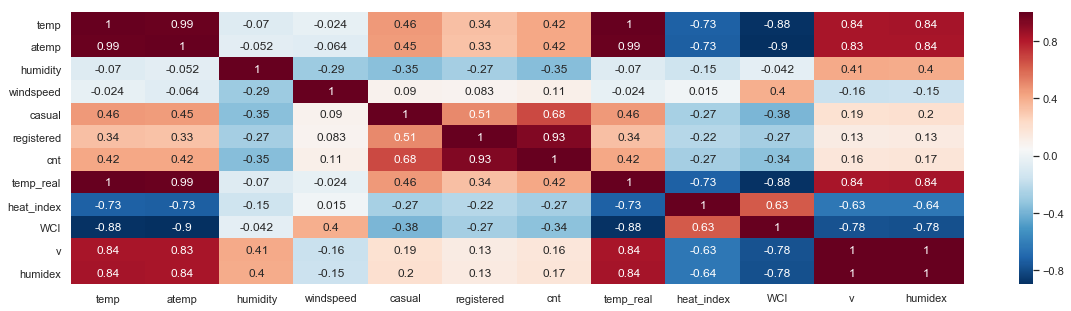

In [187]:
# check correlations again
plt.figure(figsize=(20, 5))
sns.heatmap(hour_df_out.corr().compute(), cmap="RdBu_r", annot=True)

### 2.2 Feature Selection

Based on the following graphs and the heatmap above we perform our feature selection.

#### temp

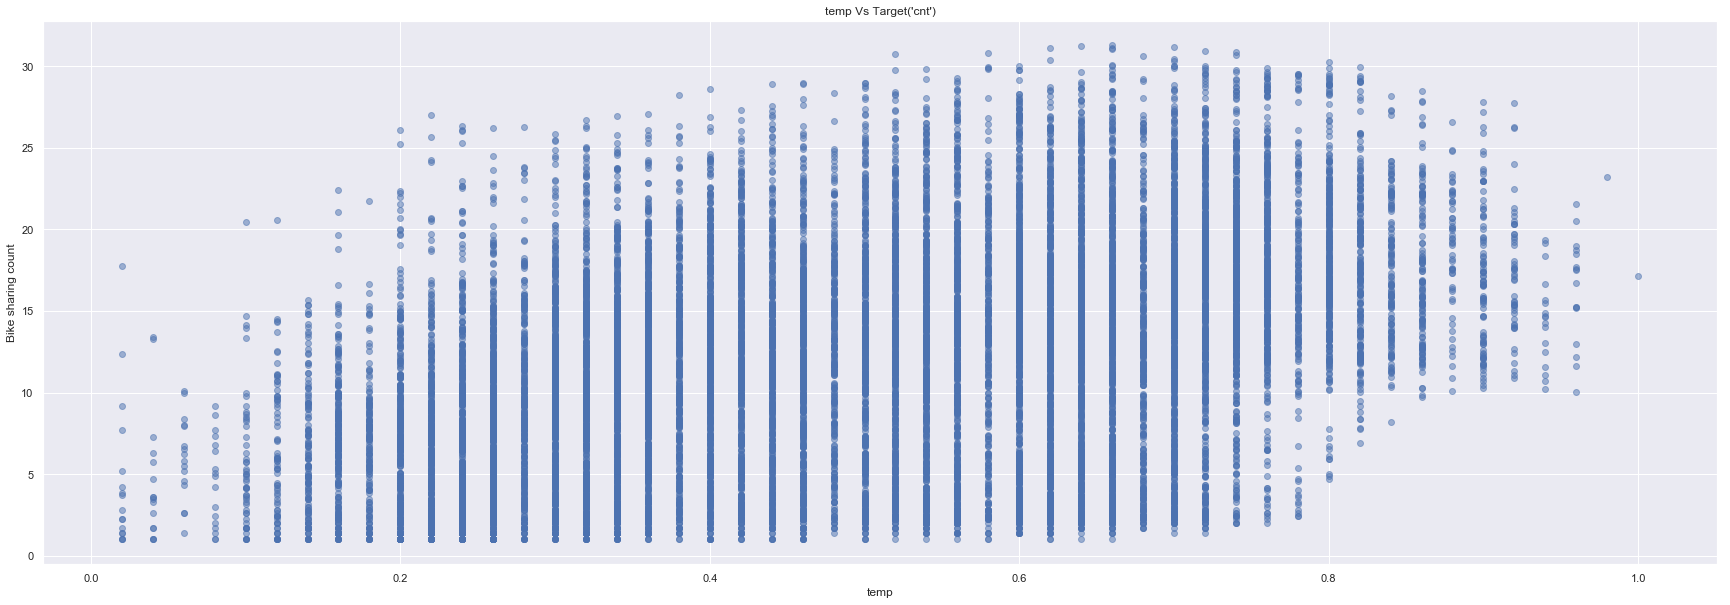

In [188]:
# temp vs Target
plt.scatter(hour_df_out[['temp']].compute(), hour_df_out[['cnt']].compute(), alpha=0.5)
plt.title("temp Vs Target('cnt')")
plt.xlabel("temp")
plt.ylabel("Bike sharing count")
plt.show()

#### atemp

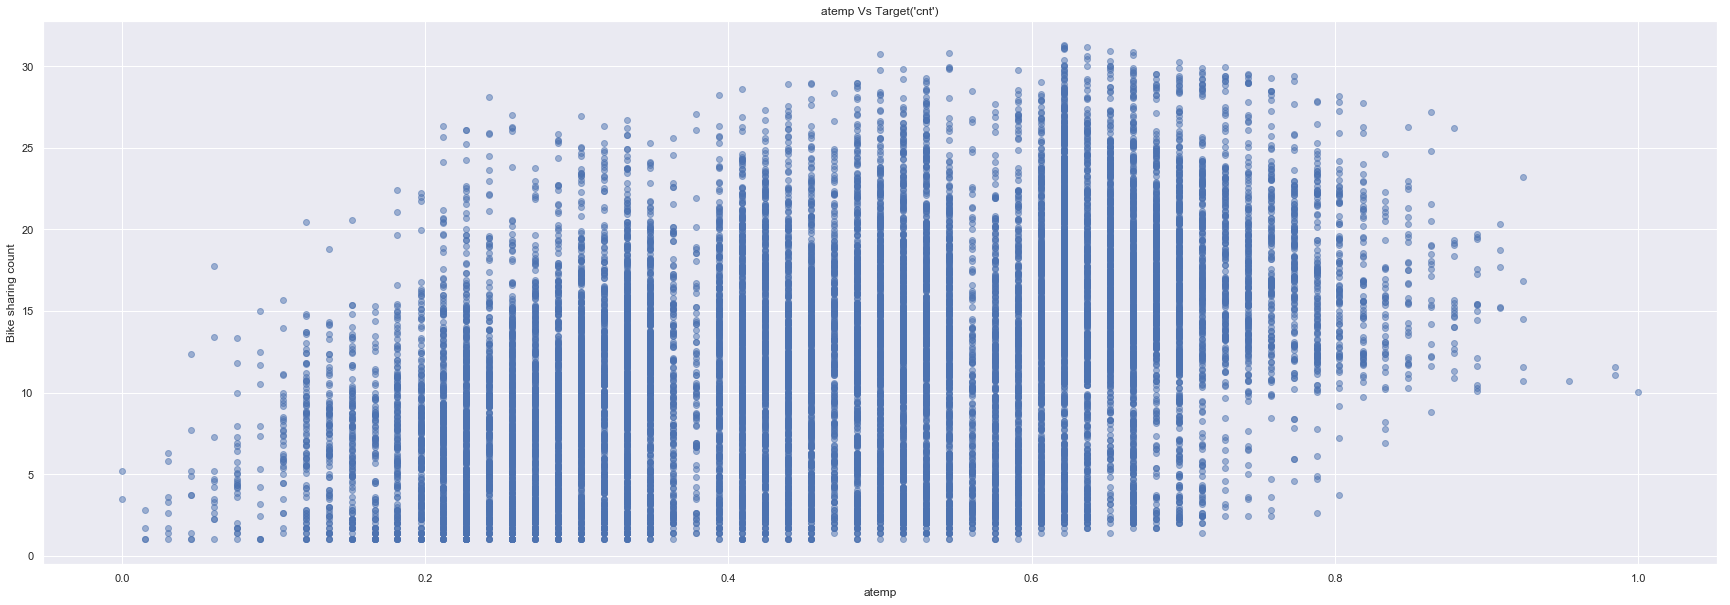

In [189]:
# atemp vs Target
plt.scatter(hour_df_out[['atemp']].compute(), hour_df_out[['cnt']].compute(), alpha=0.5)
plt.title("atemp Vs Target('cnt')")
plt.xlabel("atemp")
plt.ylabel("Bike sharing count")
plt.show()

#### humidity

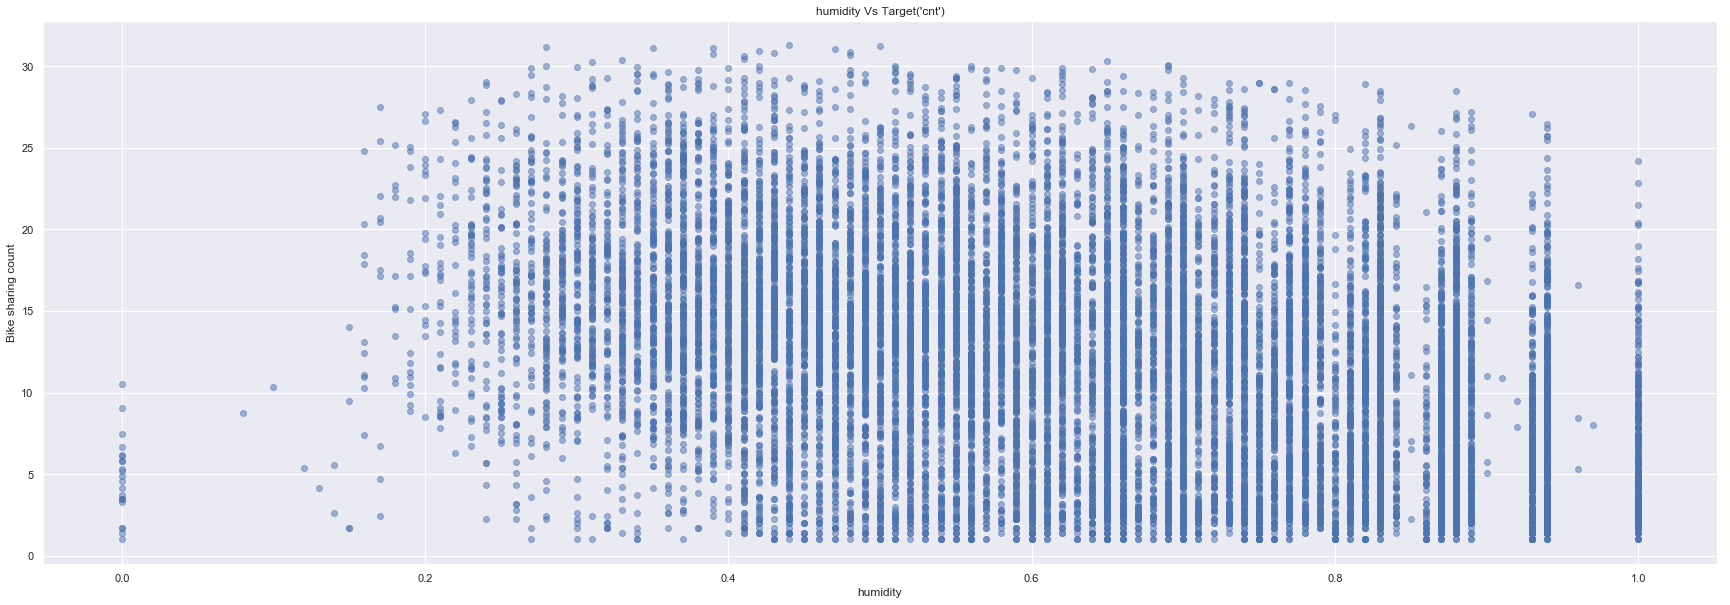

In [190]:
# temp vs Target
plt.scatter(hour_df_out[['humidity']].compute(), hour_df_out[['cnt']].compute(), alpha=0.5)
plt.title("humidity Vs Target('cnt')")
plt.xlabel("humidity")
plt.ylabel("Bike sharing count")
plt.show()

#### windspeed

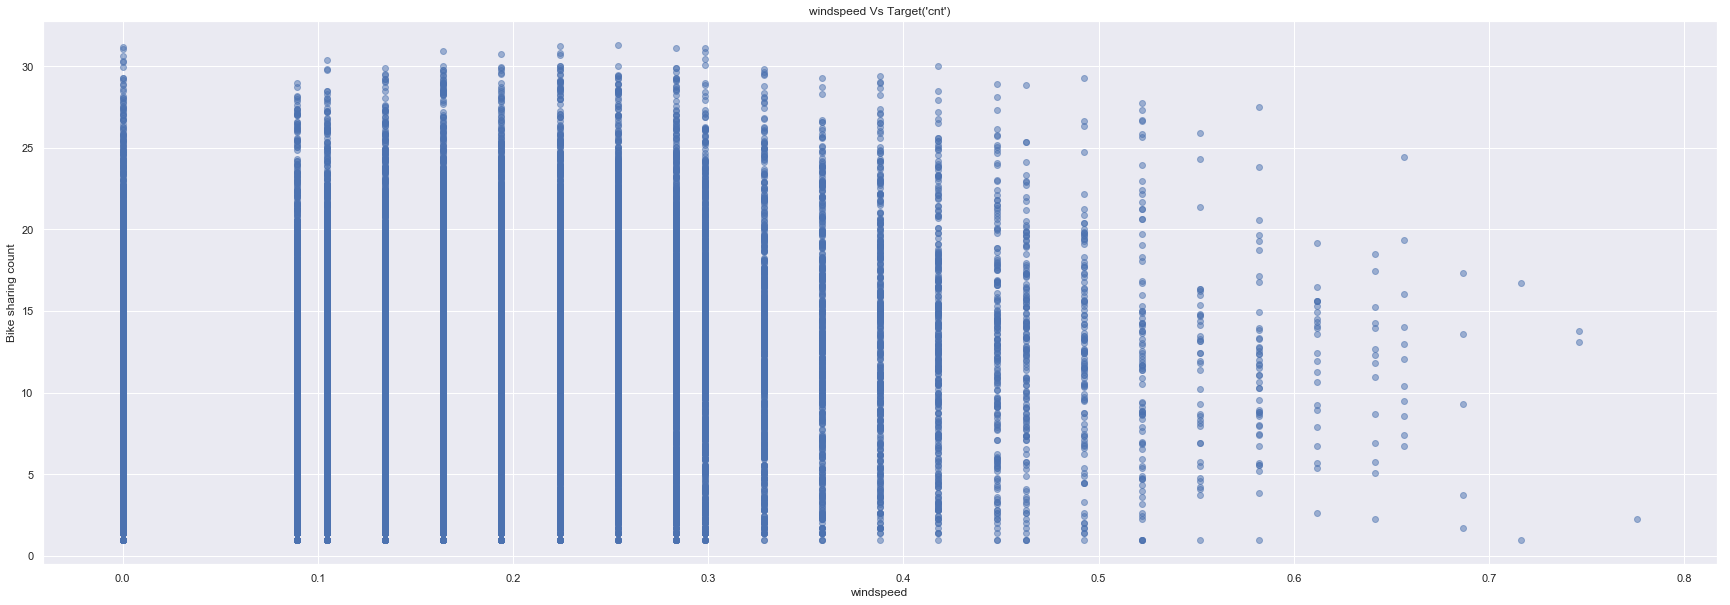

In [191]:
# windspeed vs Target
plt.scatter(hour_df_out[['windspeed']].compute(), hour_df_out[['cnt']].compute(), alpha=0.5)
plt.title("windspeed Vs Target('cnt')")
plt.xlabel("windspeed")
plt.ylabel("Bike sharing count")
plt.show()

#### casual

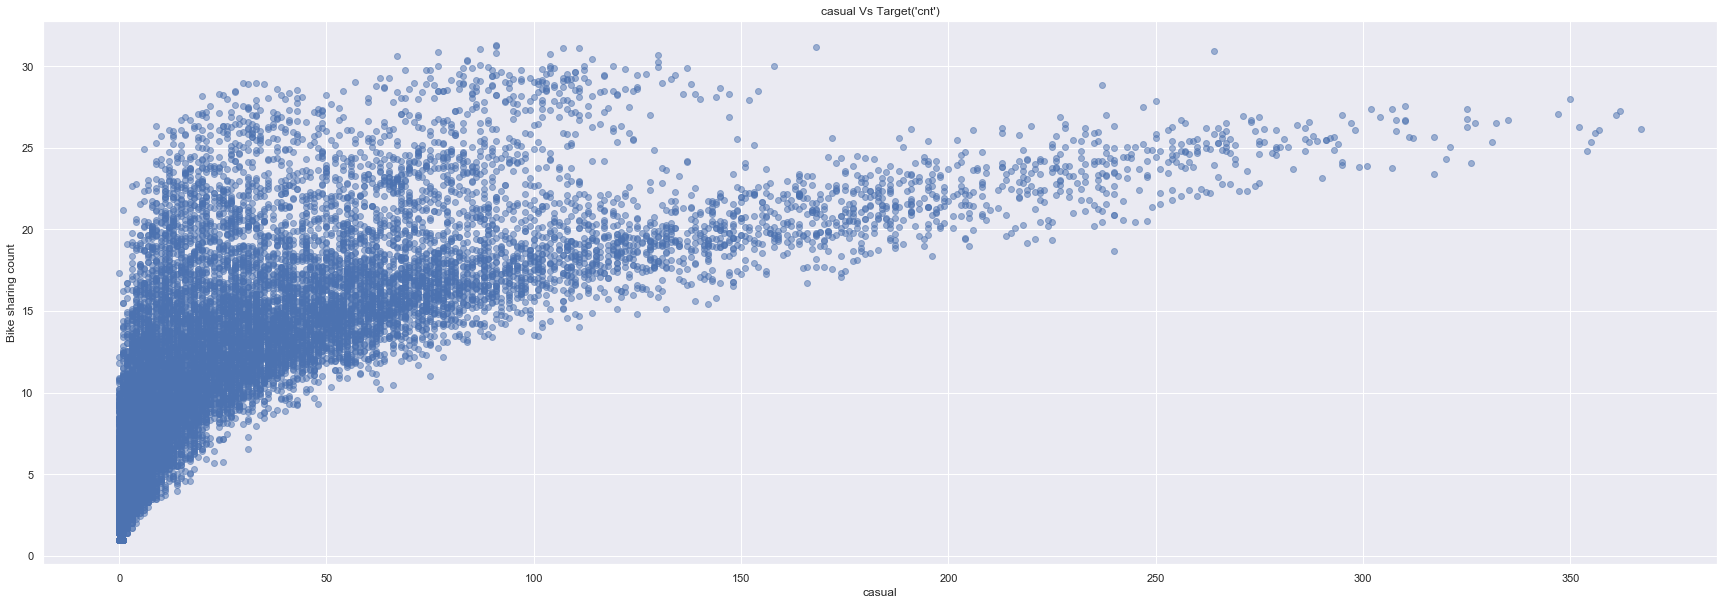

In [192]:
# casual vs Target
plt.scatter(hour_df_out[['casual']].compute(), hour_df_out[['cnt']].compute(), alpha=0.5)
plt.title("casual Vs Target('cnt')")
plt.xlabel("casual")
plt.ylabel("Bike sharing count")
plt.show()

#### registered

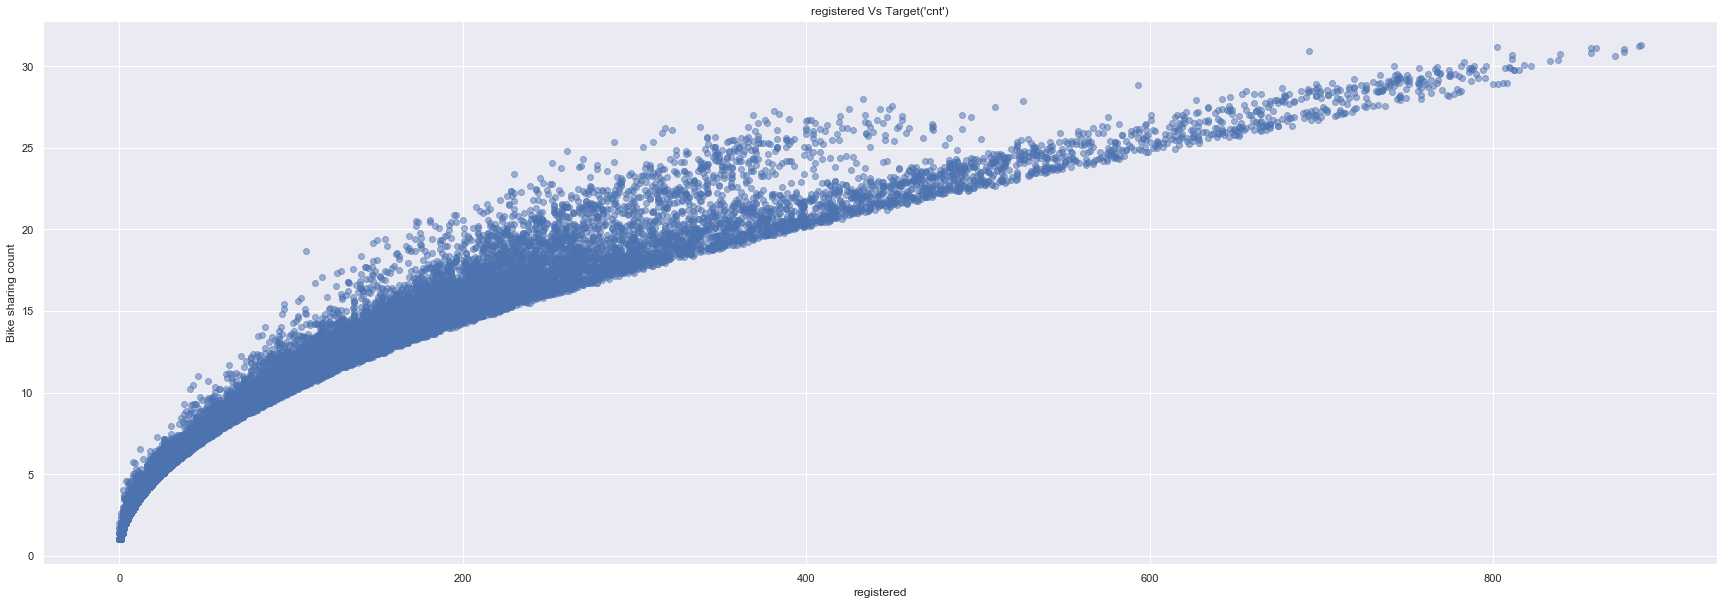

In [193]:
# registered vs Target
plt.scatter(hour_df_out[['registered']].compute(), hour_df_out[['cnt']].compute(), alpha=0.5)
plt.title("registered Vs Target('cnt')")
plt.xlabel("registered")
plt.ylabel("Bike sharing count")
plt.show()

#### temp_real

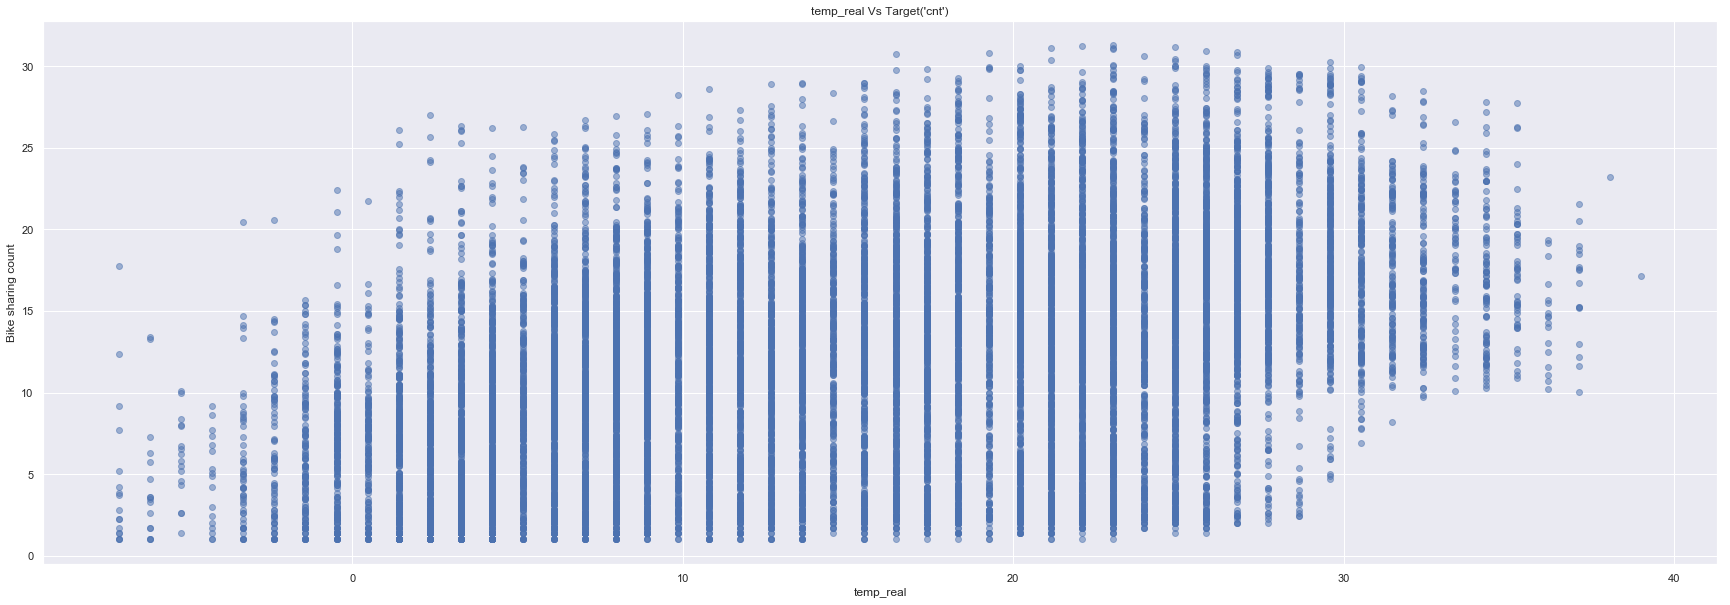

In [194]:
# temp_real vs Target
plt.scatter(
    hour_df_out[["temp_real"]].compute(), hour_df_out[["cnt"]].compute(), alpha=0.5
)
plt.title("temp_real Vs Target('cnt')")
plt.xlabel("temp_real")
plt.ylabel("Bike sharing count")
plt.show()

#### heat_index

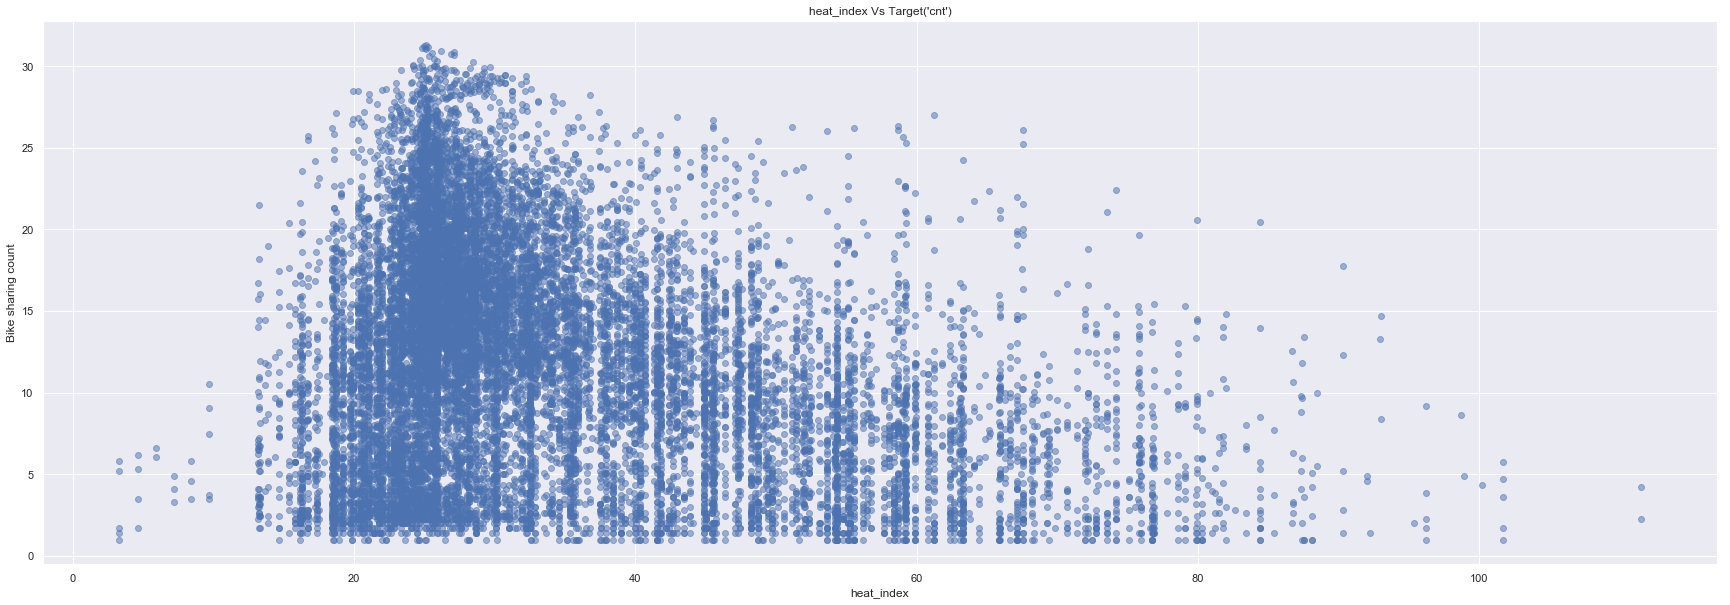

In [195]:
# heat_index vs Target
plt.scatter(
    hour_df_out[["heat_index"]].compute(), hour_df_out[["cnt"]].compute(), alpha=0.5
)
plt.title("heat_index Vs Target('cnt')")
plt.xlabel("heat_index")
plt.ylabel("Bike sharing count")
plt.show()

#### WCI

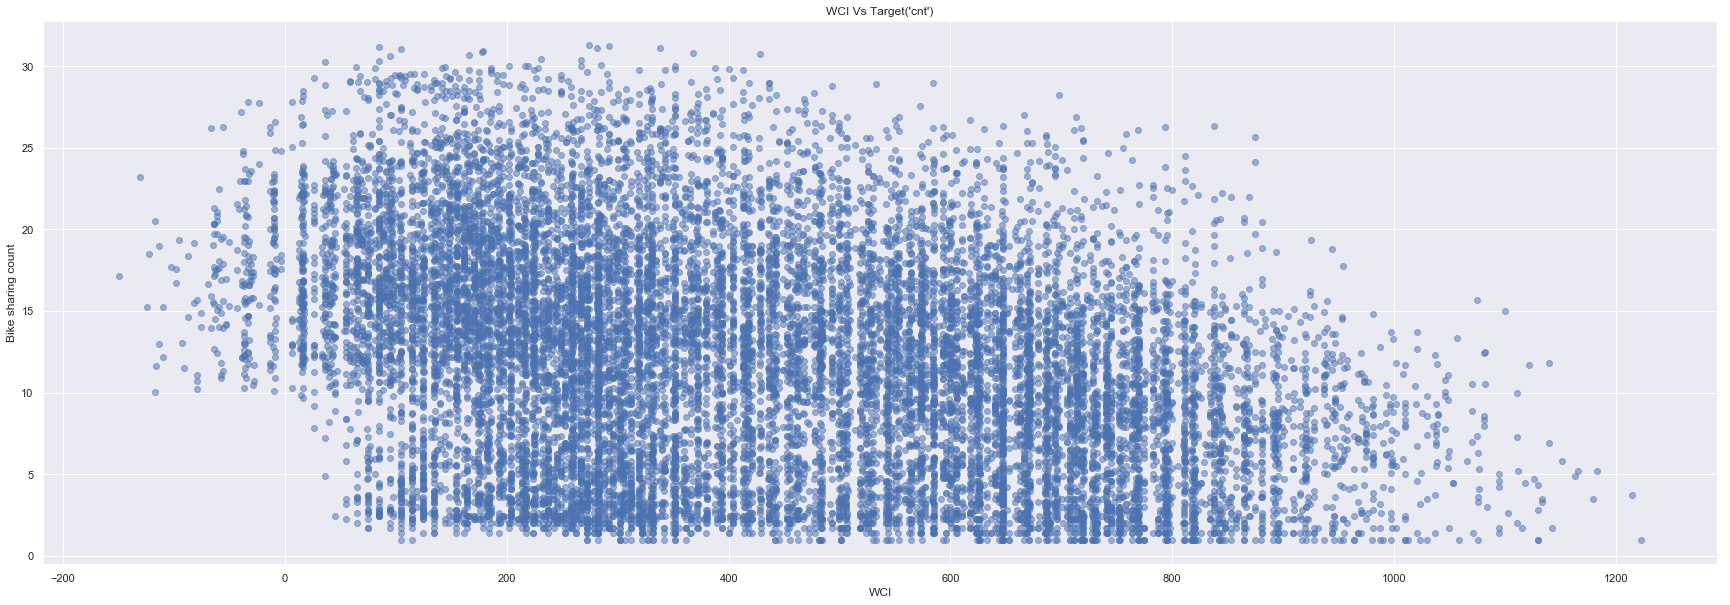

In [196]:
# WCI vs Target
plt.scatter(hour_df_out[["WCI"]].compute(), hour_df_out[["cnt"]].compute(), alpha=0.5)
plt.title("WCI Vs Target('cnt')")
plt.xlabel("WCI")
plt.ylabel("Bike sharing count")
plt.show()

#### humidex

### Conclusion
Based on visual representation of the correlation of each variable (see for all varibles below) and the heatmap above, we will decide which variables we will exclude in order to avoid multicolliniarity. As a result of this inspection we decide **not to use** the following variables to train and predict:
- "cnt" (target variable)
- "registered" (too highly correlated with target variable)
- "casual" (too highly correlated with target variable)
- "atemp" (too highly correlated with target "temp" and "humidex")
- "windspeed" (too low correlated with target variable)

## Preparing the Final Dataset for Modeling

In [197]:
#import dask_ml.joblib
from sklearn.externals.joblib import parallel_backend
from dask_ml.preprocessing import OneHotEncoder
encoder = OneHotEncoder(sparse=True)

In [198]:
# categorical variables
hour_df_out["season"] = hour_df_out.season.astype("category")
hour_df_out["holiday"] = hour_df_out.holiday.astype("category")
hour_df_out["weekday"] = hour_df_out.weekday.astype("category")
hour_df_out["weathersit"] = hour_df_out.weathersit.astype("category")
hour_df_out["workingday"] = hour_df_out.workingday.astype("category")
hour_df_out["month"] = hour_df_out.month.astype("category")
hour_df_out["year"] = hour_df_out.year.astype("category")
hour_df_out["hour"] = hour_df_out.hour.astype("category")

In [199]:
# drop columns that will not be used for modeling
hour_df_out = hour_df_out.drop("registered", axis=1)
hour_df_out = hour_df_out.drop("casual", axis=1)
# Drop temp_real and atemp due to multicolinearily with temp
hour_df_out = hour_df_out.drop("atemp", axis=1)
hour_df_out = hour_df_out.drop("temp_real", axis=1)
# Drop "windspeed" since we calculated WCI which has higher correlation with our target
hour_df_out = hour_df_out.drop("windspeed", axis=1)
# Drop v as it was only used for calculating indeces
hour_df_out = hour_df_out.drop("v", axis=1)

In [200]:
hour_df_out.dtypes # drop the column instance as the instance will not provide any information

date          datetime64[ns]
season              category
year                category
month               category
hour                category
holiday             category
weekday             category
workingday          category
weathersit          category
temp                 float64
humidity             float64
cnt                  float64
heat_index           float64
WCI                  float64
humidex              float64
dtype: object

In [201]:
# Dummify the dataset
hour_dummified = dd.DataFrame.copy(hour_df_out)
hour_dummified = hour_dummified.categorize()
hour_dummified = dd.get_dummies(hour_dummified)

In [202]:
hour_dummified.columns

Index(['date', 'temp', 'humidity', 'cnt', 'heat_index', 'WCI', 'humidex',
       'season_Clear', 'season_Heavy Rain/Snow',
       'season_Light Snow/Light Rain', 'season_Mist + Cloud', 'year_2011',
       'year_2012', 'month_1', 'month_2', 'month_3', 'month_4', 'month_5',
       'month_6', 'month_7', 'month_8', 'month_9', 'month_10', 'month_11',
       'month_12', 'hour_0', 'hour_1', 'hour_2', 'hour_3', 'hour_4', 'hour_5',
       'hour_6', 'hour_7', 'hour_8', 'hour_9', 'hour_10', 'hour_11', 'hour_12',
       'hour_13', 'hour_14', 'hour_15', 'hour_16', 'hour_17', 'hour_18',
       'hour_19', 'hour_20', 'hour_21', 'hour_22', 'hour_23', 'holiday_0',
       'holiday_1', 'weekday_Fri', 'weekday_Mon', 'weekday_Sat', 'weekday_Sun',
       'weekday_Thurs', 'weekday_Tues', 'weekday_Wed', 'workingday_0',
       'workingday_1', 'weathersit_1', 'weathersit_2', 'weathersit_3',
       'weathersit_4'],
      dtype='object')

### 3.4 Split Dummified Dataset
Now splitting the dataset after one hot encoding.

- From now on this dataset serves as basis for all our models and predictions.

In [203]:
import datetime as dt

In [204]:
split_date = dt.date(2012, 9, 30)
train = hour_dummified[hour_dummified["date"] < "2012-10-01"]

In [205]:
test = hour_dummified[hour_dummified["date"] >= "2012-10-01"]

Preparing splittet dataset for predictions:

In [206]:
# Now that the new dataset has more variables, we will remove some of the features that were created previously but show low correlation with the target variable
X_train = train.drop(["cnt", "heat_index"], axis=1)
y_train = train["cnt"]

X_test = test.drop(["cnt", "heat_index"], axis=1)
y_test = test["cnt"]

In [207]:
# drop datetime column
X_train = X_train.drop(["date"], axis=1)
X_test = X_test.drop(["date"], axis=1)

Now we can start modeling. As usual we will start with a simple linear regression to get a benchmark score.

In [208]:
X_train.columns

Index(['temp', 'humidity', 'WCI', 'humidex', 'season_Clear',
       'season_Heavy Rain/Snow', 'season_Light Snow/Light Rain',
       'season_Mist + Cloud', 'year_2011', 'year_2012', 'month_1', 'month_2',
       'month_3', 'month_4', 'month_5', 'month_6', 'month_7', 'month_8',
       'month_9', 'month_10', 'month_11', 'month_12', 'hour_0', 'hour_1',
       'hour_2', 'hour_3', 'hour_4', 'hour_5', 'hour_6', 'hour_7', 'hour_8',
       'hour_9', 'hour_10', 'hour_11', 'hour_12', 'hour_13', 'hour_14',
       'hour_15', 'hour_16', 'hour_17', 'hour_18', 'hour_19', 'hour_20',
       'hour_21', 'hour_22', 'hour_23', 'holiday_0', 'holiday_1',
       'weekday_Fri', 'weekday_Mon', 'weekday_Sat', 'weekday_Sun',
       'weekday_Thurs', 'weekday_Tues', 'weekday_Wed', 'workingday_0',
       'workingday_1', 'weathersit_1', 'weathersit_2', 'weathersit_3',
       'weathersit_4'],
      dtype='object')

In [209]:
type(y_train)

dask.dataframe.core.Series

## 3 Basic Models

Initially we import a few libraries we need:

In [228]:
from sklearn import linear_model
import math
from sklearn.metrics import mean_squared_error
from sklearn.model_selection import cross_val_predict
from sklearn.model_selection import cross_val_score
from sklearn.metrics import r2_score
import datetime as dt
from sklearn.ensemble import GradientBoostingRegressor
from sklearn.ensemble import RandomForestRegressor
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import mean_absolute_error
from sklearn.linear_model import Lasso
from sklearn.linear_model import Ridge

In [229]:
#!pip install dask-xgboost

In [230]:
# Dask Libraries
from dask_ml.linear_model import LinearRegression as LR
from sklearn.externals.joblib import parallel_backend
from dask_ml.model_selection import GridSearchCV as dask_GridSearchCV
from dask_ml.xgboost import XGBRegressor as dask_xgb

In [231]:
# converting dataframes to dask arrays
X_train = X_train.values
X_test = X_test.values
y_train = y_train.values
y_test = y_test.values

### Linear Regression

In [232]:
lr = LR()
lr.fit(X_train, y_train)

LinearRegression(C=1.0, class_weight=None, dual=False, fit_intercept=True,
         intercept_scaling=1.0, max_iter=100, multi_class='ovr', n_jobs=1,
         penalty='l2', random_state=None, solver='admm',
         solver_kwargs=None, tol=0.0001, verbose=0, warm_start=False)

In [233]:
# making predection using the test set
y_pred_lr = lr.predict(X_test)
y_pred_lr = [
    i if i >= 0 else 0 for i in y_pred_lr.compute()
]  # in case a value is predicted as minus

# round prediction count to the nearest integer
y_pred_lr = [round(x) for x in y_pred_lr]

In [234]:
print("R2 for Linear Regression is: %.2F" % r2_score(y_pred_lr, y_test.compute()))
print(
    "RMSE with Linear Regression: %.2f"
    % da.sqrt(mean_squared_error(y_test.compute(), y_pred_lr))
)

R2 for Linear Regression is: 0.54
RMSE with Linear Regression: 3.60


#### Visual representations of predictions and distribution of errors:

C:\Users\andre\Anaconda3\lib\site-packages\matplotlib\figure.py:445: UserWarning: Matplotlib is currently using module://ipykernel.pylab.backend_inline, which is a non-GUI backend, so cannot show the figure.
  % get_backend())


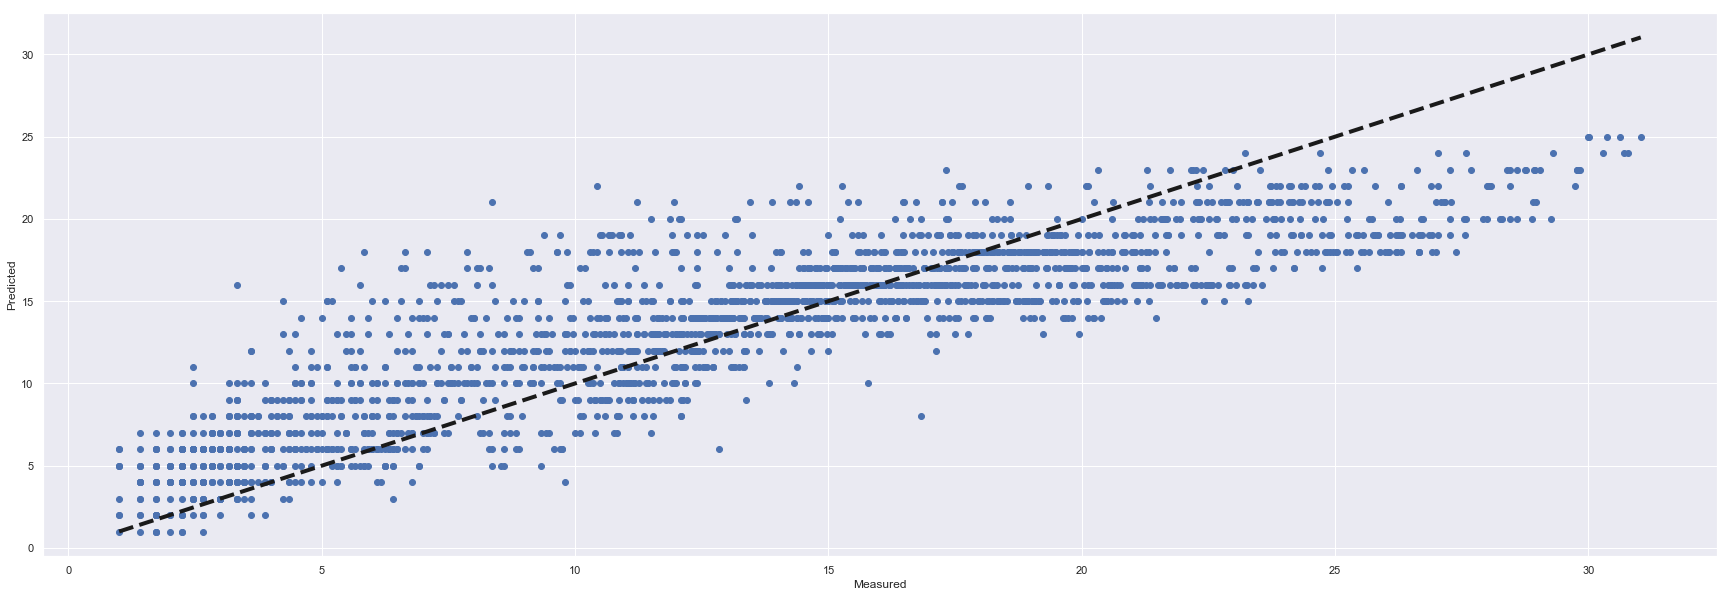

In [235]:
fig, ax = plt.subplots()
ax.scatter(y_test.compute(), y_pred_lr)
ax.plot(
    [y_test.compute().min(), y_test.compute().max()],
    [y_test.compute().min(), y_test.compute().max()],
    "k--",
    lw=4,
)
ax.set_xlabel("Measured")
ax.set_ylabel("Predicted")
fig.show()

C:\Users\andre\Anaconda3\lib\site-packages\scipy\stats\stats.py:1713: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  return np.add.reduce(sorted[indexer] * weights, axis=axis) / sumval


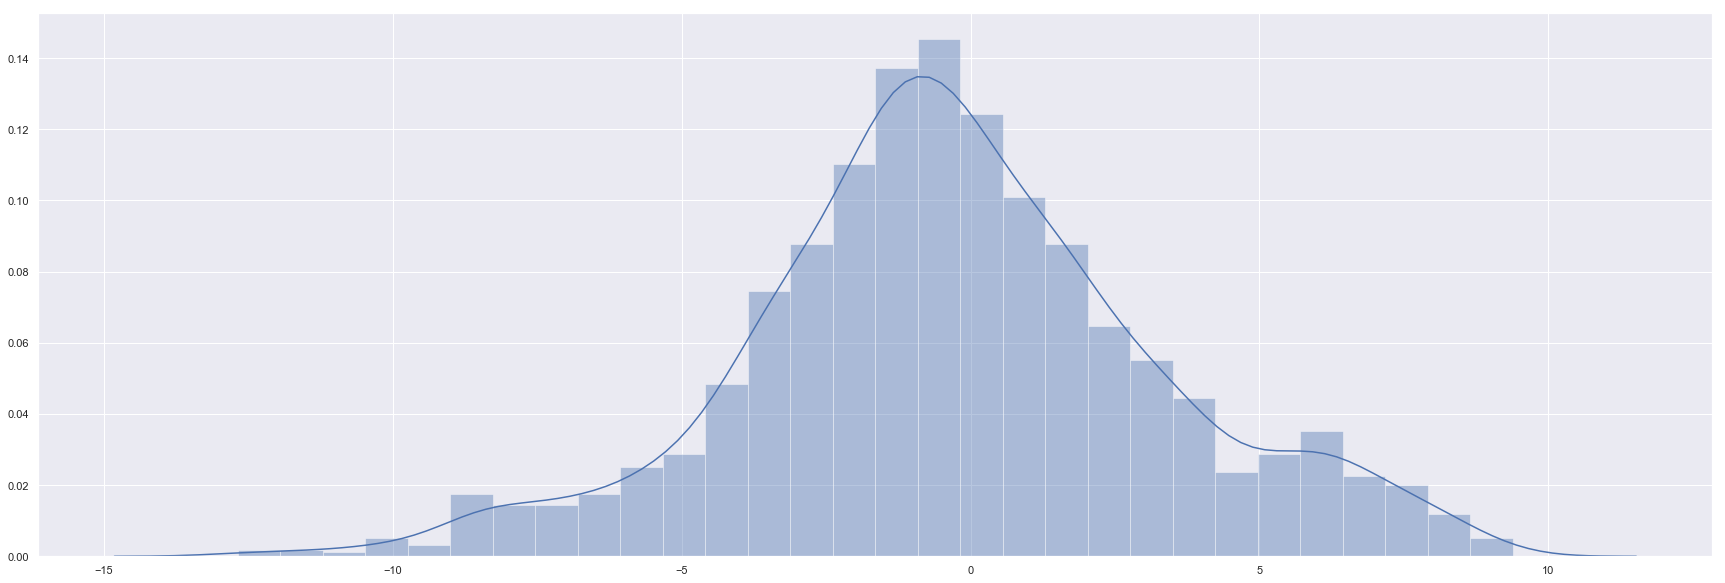

In [236]:
# Plotting the residuals
sns.distplot(y_test.compute() - y_pred_lr, bins=30)

### Ridge Regression

Next we try a ridge regression, which does not really perform better in overall.

In [237]:
ridge_model = Ridge(
    alpha=0.01
)  # higher the alpha value, more restriction on the coefficients; low alpha > more generalization, coefficients are barely

# fit model
ridge_model.fit(X_train, y_train)

Ridge(alpha=0.01, copy_X=True, fit_intercept=True, max_iter=None,
   normalize=False, random_state=None, solver='auto', tol=0.001)

In [238]:
# making predection using the test set
y_pred_ridge = ridge_model.predict(X_test)
y_pred_ridge = [
    i if i >= 0 else 0 for i in y_pred_ridge
]  # in case a value is predicted as minus

# round prediction count to the nearest integer
y_pred_ridge = [round(x) for x in y_pred_ridge]

In [239]:
# root mean squared error
print("RMSE: %.2f" % da.sqrt(mean_squared_error(y_test.compute(), y_pred_ridge)))
print("R2: %.2F" % r2_score(y_pred_ridge, y_test.compute()))

RMSE: 3.60
R2: 0.55


In [240]:
Ridge_train_score = ridge_model.score(X_train, y_train.compute())
Ridge_test_score = ridge_model.score(X_test, y_test.compute())

In [241]:
Ridge_train_score

0.7910798278063156

In [242]:
Ridge_test_score

0.7463578359388864

In [243]:
print("ridge regression train score low alpha:", Ridge_train_score)
print("ridge regression test score low alpha:", Ridge_test_score)

ridge regression train score low alpha: 0.7910798278063156
ridge regression test score low alpha: 0.7463578359388864


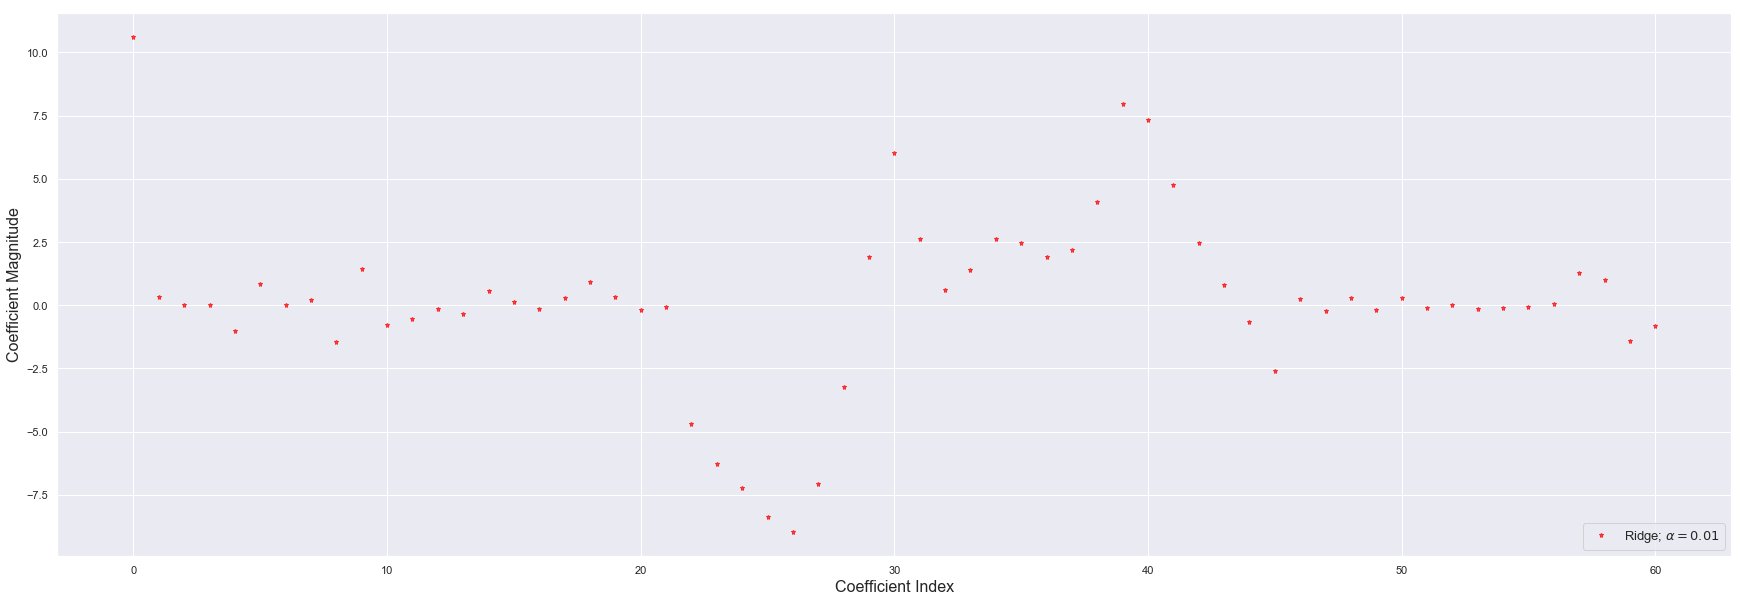

In [244]:
plt.plot(
    ridge_model.coef_,
    alpha=0.7,
    linestyle="none",
    marker="*",
    markersize=5,
    color="red",
    label=r"Ridge; $\alpha = 0.01$",
    zorder=7,
)  # zorder for ordering the markers
plt.xlabel("Coefficient Index", fontsize=16)
plt.ylabel("Coefficient Magnitude", fontsize=16)
plt.legend(fontsize=13, loc=4)
plt.show()

#### Visual representations of predictions and distribution of errors:

C:\Users\andre\Anaconda3\lib\site-packages\matplotlib\figure.py:445: UserWarning: Matplotlib is currently using module://ipykernel.pylab.backend_inline, which is a non-GUI backend, so cannot show the figure.
  % get_backend())


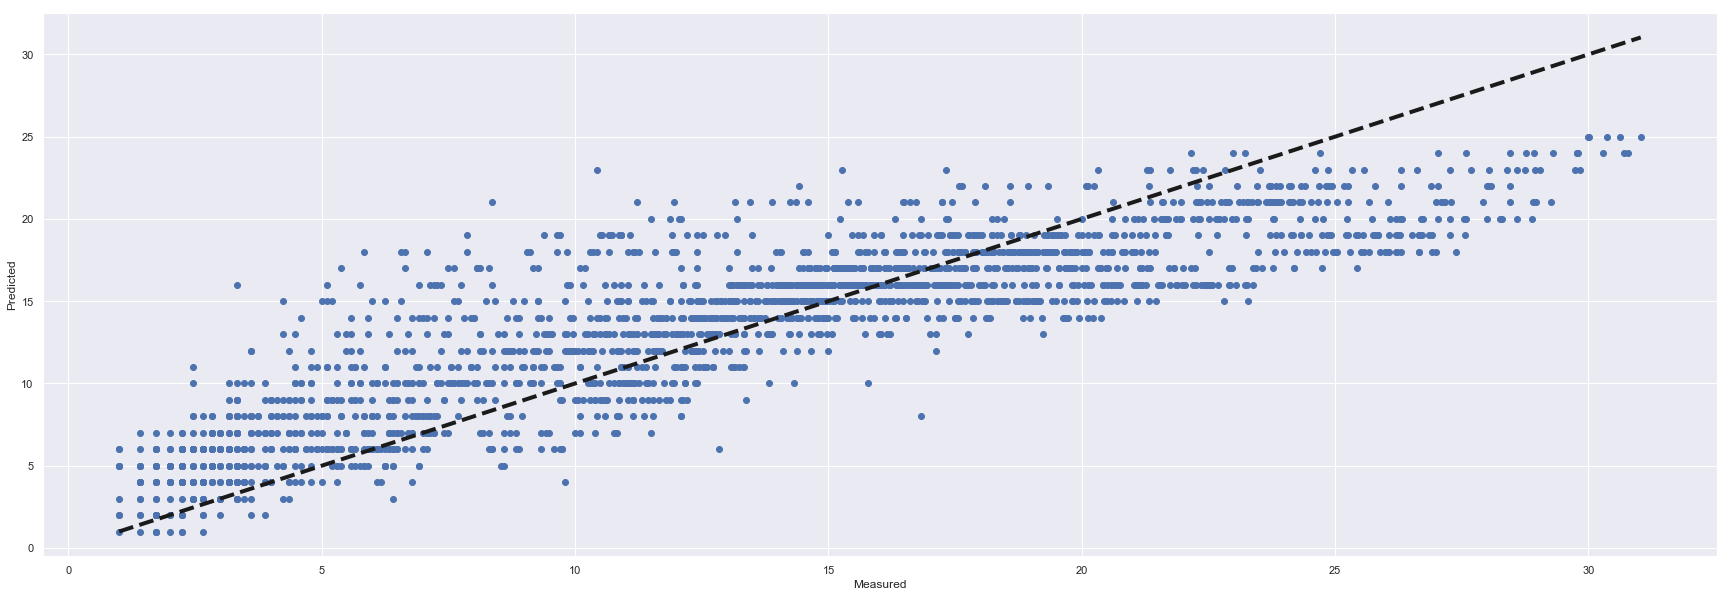

In [245]:
fig, ax = plt.subplots()
ax.scatter(y_test.compute(), y_pred_ridge)
ax.plot(
    [y_test.compute().min(), y_test.compute().max()],
    [y_test.compute().min(), y_test.compute().max()],
    "k--",
    lw=4,
)
ax.set_xlabel("Measured")
ax.set_ylabel("Predicted")
fig.show()

C:\Users\andre\Anaconda3\lib\site-packages\scipy\stats\stats.py:1713: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  return np.add.reduce(sorted[indexer] * weights, axis=axis) / sumval


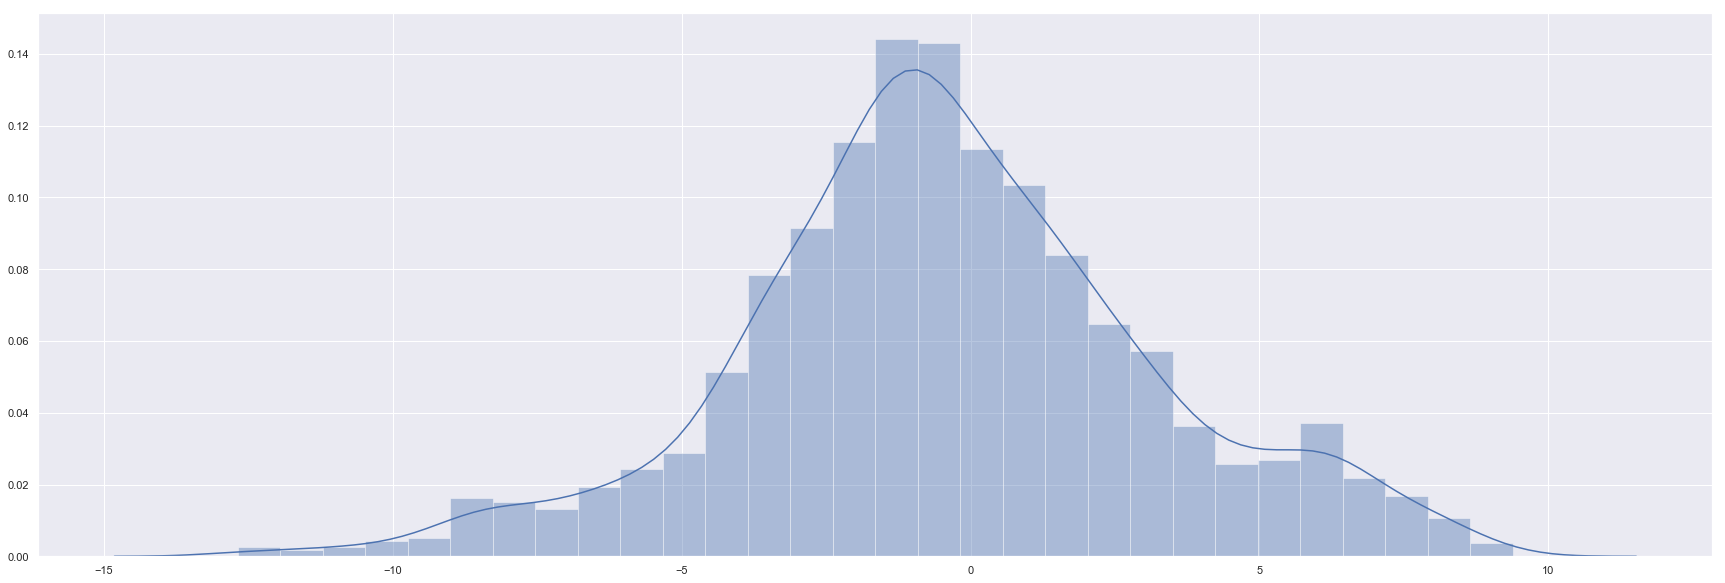

In [246]:
# Distribution of Residuals
sns.distplot(y_test.compute() - y_pred_ridge, bins=30)

### Random Forest

Now we will try with RF to see if we have any improvement in the prediction

In [248]:
rf = RandomForestRegressor()
with parallel_backend('dask'):
    rf.fit(X_train, y_train)

C:\Users\andre\Anaconda3\lib\site-packages\sklearn\ensemble\forest.py:246: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)


In [265]:
rf_pred = rf.predict(X_test)
rf_pred = [i if i >= 0 else 0 for i in rf_pred]  # in case a value is predicted as minus

# round prediction count to the nearest integer
rf_pred = [round(x) for x in rf_pred]

In [266]:
# root mean squared error
print(
    "RMSE using Random Forest: %.2f"
    % da.sqrt(mean_squared_error(y_test.compute(), rf_pred))
)
print("R2 using Random Forest: %.2F" % r2_score(y_test.compute(), rf_pred))

RMSE using Random Forest: 2.78
R2 using Random Forest: 0.85


#### Visual representations of predictions and distribution of errors:

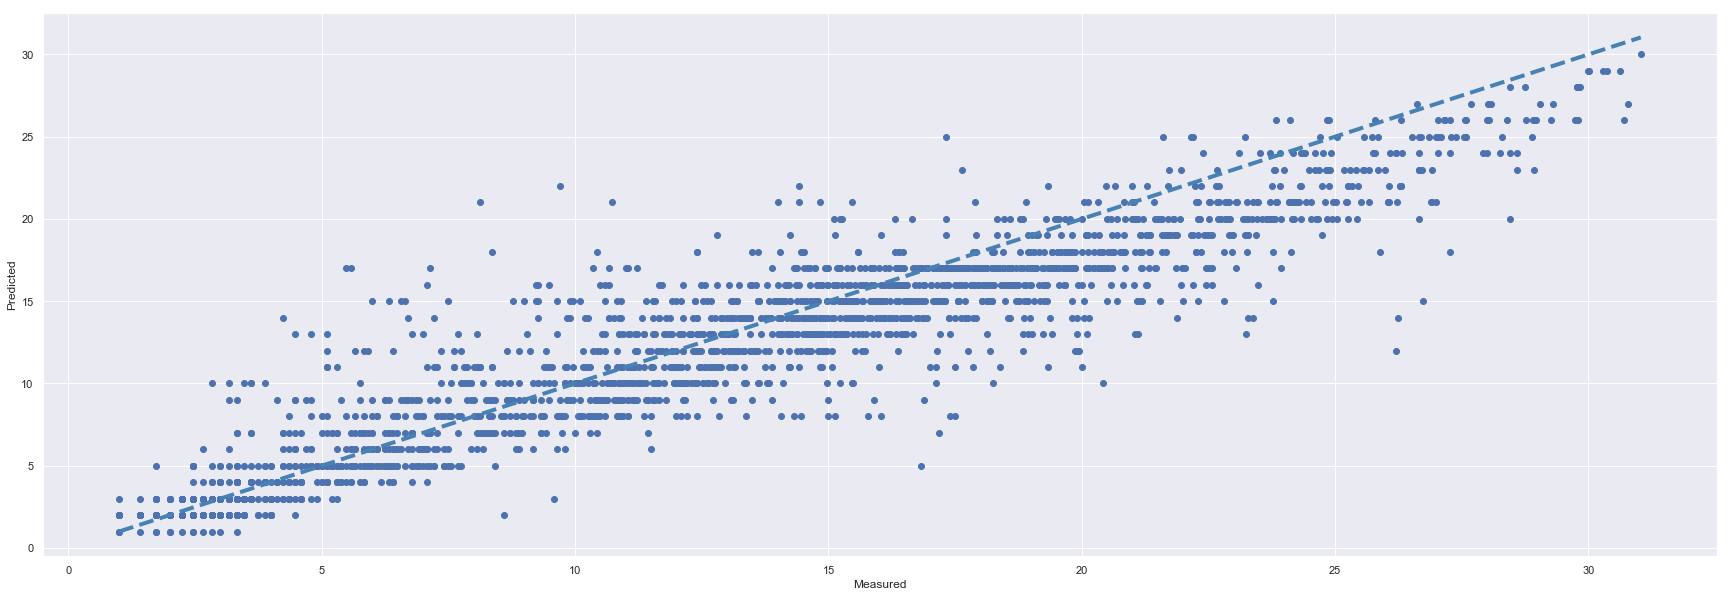

In [267]:
fig, ax = plt.subplots()
ax.scatter(y_test.compute(), rf_pred)
ax.plot(
    [y_test.compute().min(), y_test.compute().max()],
    [y_test.compute().min(), y_test.compute().max()],
    "k--",
    lw=4,
    color="steelblue"
)
ax.set_xlabel("Measured")
ax.set_ylabel("Predicted")
fig.show()

C:\Users\andre\Anaconda3\lib\site-packages\scipy\stats\stats.py:1713: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  return np.add.reduce(sorted[indexer] * weights, axis=axis) / sumval


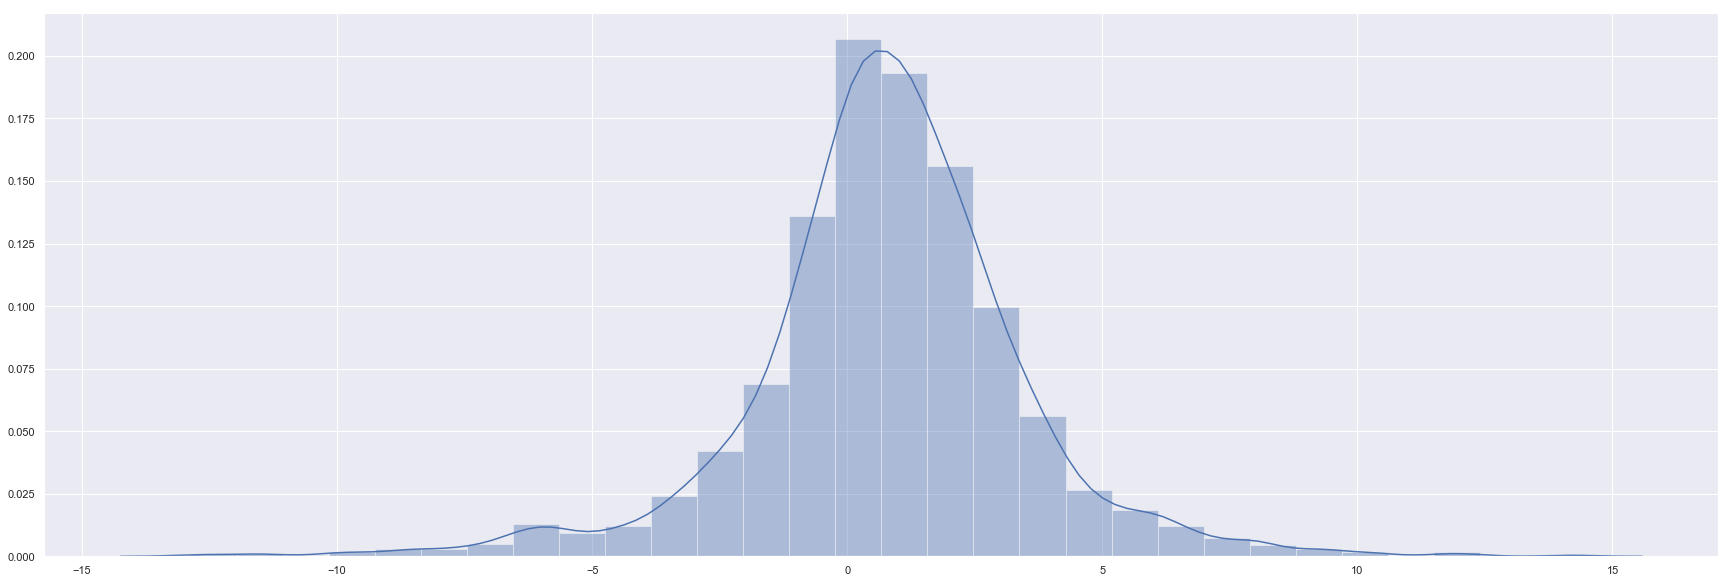

In [252]:
# Distribution of residuals
sns.distplot(y_test.compute() - rf_pred, bins=30)

### Optimize

In [253]:
with parallel_backend('dask'):

    # Create the parameter grid based on the results of random search 
     param_grid = {
    'bootstrap': [True],
    'max_depth': [8, 10],
    'min_samples_leaf': [2, 4],
    'min_samples_split': [6 ,8],
    'n_estimators': [100, 200, 500]
    }

In [254]:
grid_search_rf = dask_GridSearchCV(estimator = rf, param_grid = param_grid, cv = 3)

In [255]:
with parallel_backend('dask'):
    grid_search_rf.fit(X_train, y_train)
    
warnings.filterwarnings("ignore")

In [256]:
print("best parameters:", grid_search_rf.best_params_)
print("best score: ", grid_search_rf.best_score_)

best parameters: {'bootstrap': True, 'max_depth': 10, 'min_samples_leaf': 2, 'min_samples_split': 8, 'n_estimators': 100}
best score:  0.6217929504560252


In [258]:
rf_opt = RandomForestRegressor(
    bootstrap=True,
    n_estimators=100,
    max_depth=10,
    min_samples_leaf=2,
    min_samples_split=8,
)
rf_opt.fit(X_train, y_train)

RandomForestRegressor(bootstrap=True, criterion='mse', max_depth=10,
           max_features='auto', max_leaf_nodes=None,
           min_impurity_decrease=0.0, min_impurity_split=None,
           min_samples_leaf=2, min_samples_split=8,
           min_weight_fraction_leaf=0.0, n_estimators=100, n_jobs=None,
           oob_score=False, random_state=None, verbose=0, warm_start=False)

In [268]:
rf_pred_opt = rf_opt.predict(X_test)
rf_pred_opt = [i if i >= 0 else 0 for i in rf_pred_opt]  # in case a value is predicted as minus

# round prediction count to the nearest integer
rf_pred_opt = [round(x) for x in rf_pred_opt]

In [270]:
# root mean squared error
print(
    "RMSE using Random Forest: %.2f"
    % da.sqrt(mean_squared_error(y_test.compute(), rf_pred_opt))
)
print("R2 using Random Forest: %.2F" % r2_score(y_test.compute(), rf_pred_opt))
warnings.filterwarnings("ignore")

RMSE using Random Forest: 4.18
R2 using Random Forest: 0.65


We clearly notice that our model did not improve with grid search so the previous model will be taken into consideration.

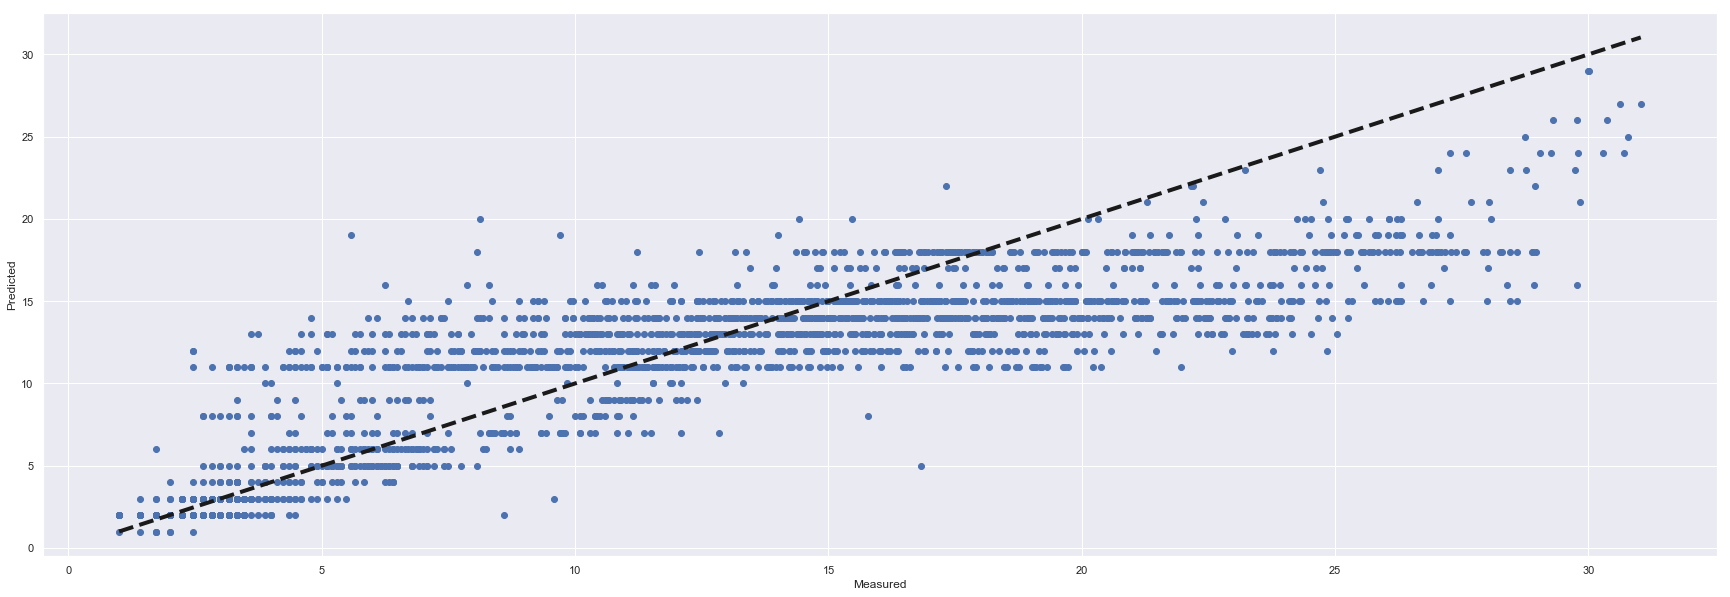

In [271]:
fig, ax = plt.subplots()
ax.scatter(y_test.compute(), rf_pred_opt)
ax.plot(
    [y_test.compute().min(), y_test.compute().max()],
    [y_test.compute().min(), y_test.compute().max()],
    "k--",
    lw=4,
)
ax.set_xlabel("Measured")
ax.set_ylabel("Predicted")
fig.show()

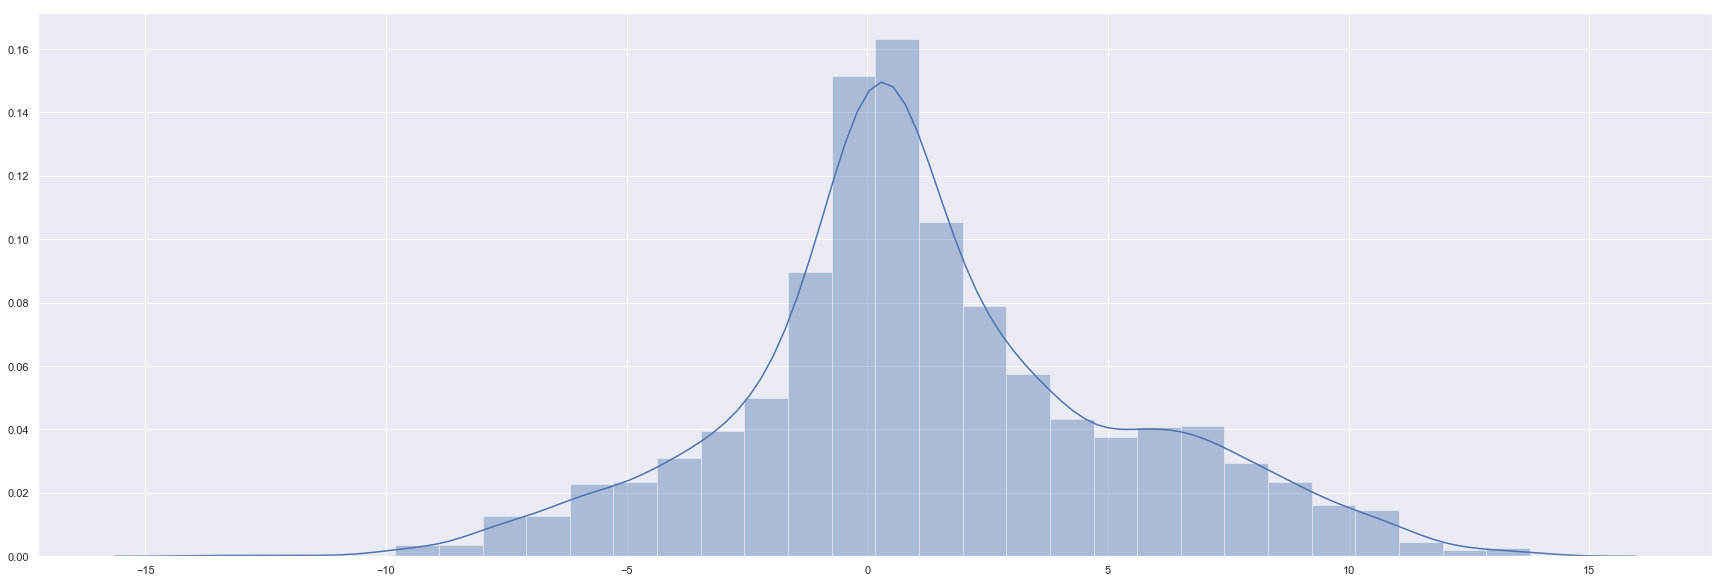

In [272]:
# Distribution of residuals
sns.distplot(y_test.compute() - rf_pred_opt, bins=30)

### 3.10 XGBoost

Also XGBoost provides us with a good initial score, therefore we will also optimize its parameters in the next chapter.

In [273]:
xgb = dask_xgb()

In [274]:
with parallel_backend('dask'):
    xgb.fit(X_train, y_train)
warnings.filterwarnings("ignore")

In [275]:
xgb_predictions = xgb.predict(X_test)
xgb_predictions = [
    i if i >= 0 else 0 for i in xgb_predictions.compute()
]  # in case a value is predicted as minus

# round prediction count to the nearest integer
xgb_predictions = [round(x) for x in xgb_predictions]

In [276]:
# root mean squared error
print("RMSE: %.2f" % da.sqrt(mean_squared_error(y_test.compute(), xgb_predictions)))
print("R2: %.2F" % r2_score(y_test.compute(), xgb_predictions))

RMSE: 3.58
R2: 0.75


#### Visual representations of predictions and distribution of errors:

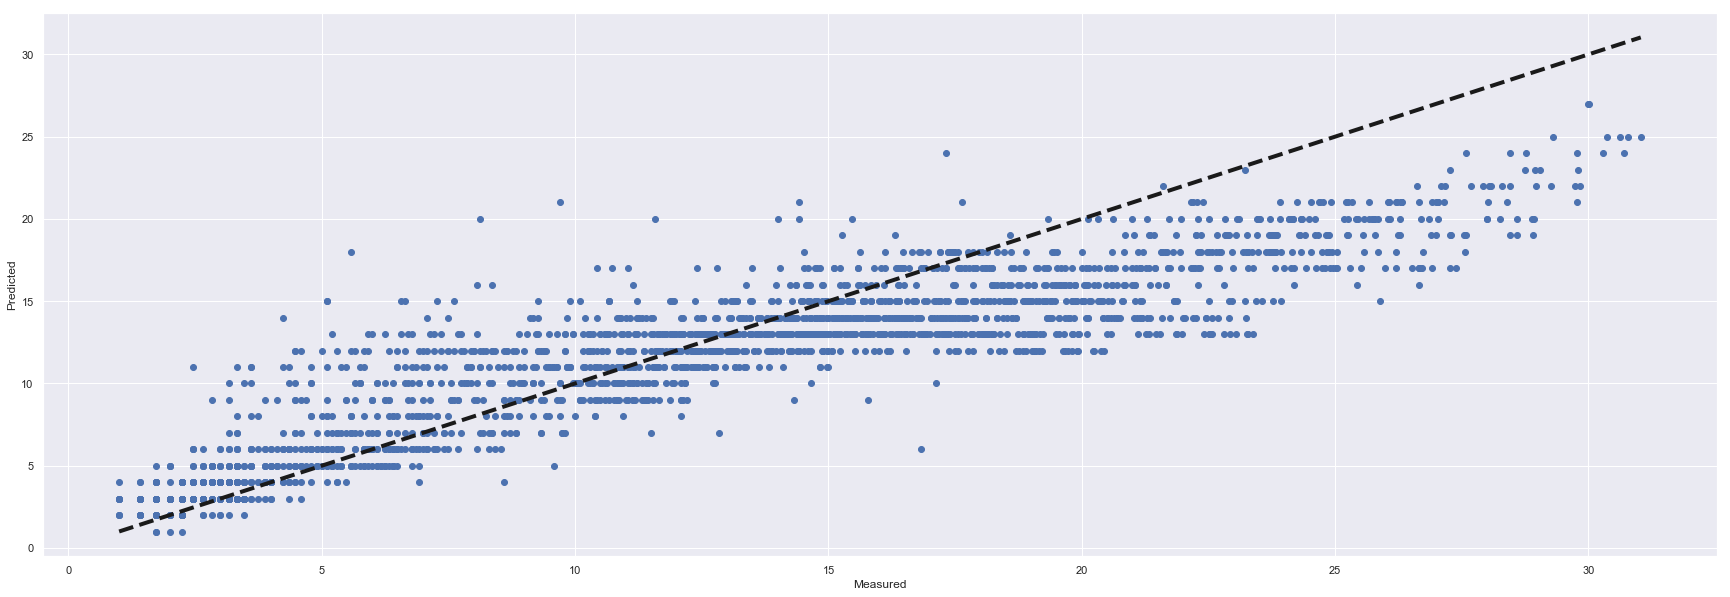

In [277]:
fig, ax = plt.subplots()
ax.scatter(y_test.compute(), xgb_predictions)
ax.plot([y_test.compute().min(), y_test.compute().max()], [y_test.compute().min(), y_test.compute().max()], "k--", lw=4)
ax.set_xlabel("Measured")
ax.set_ylabel("Predicted")
fig.show()

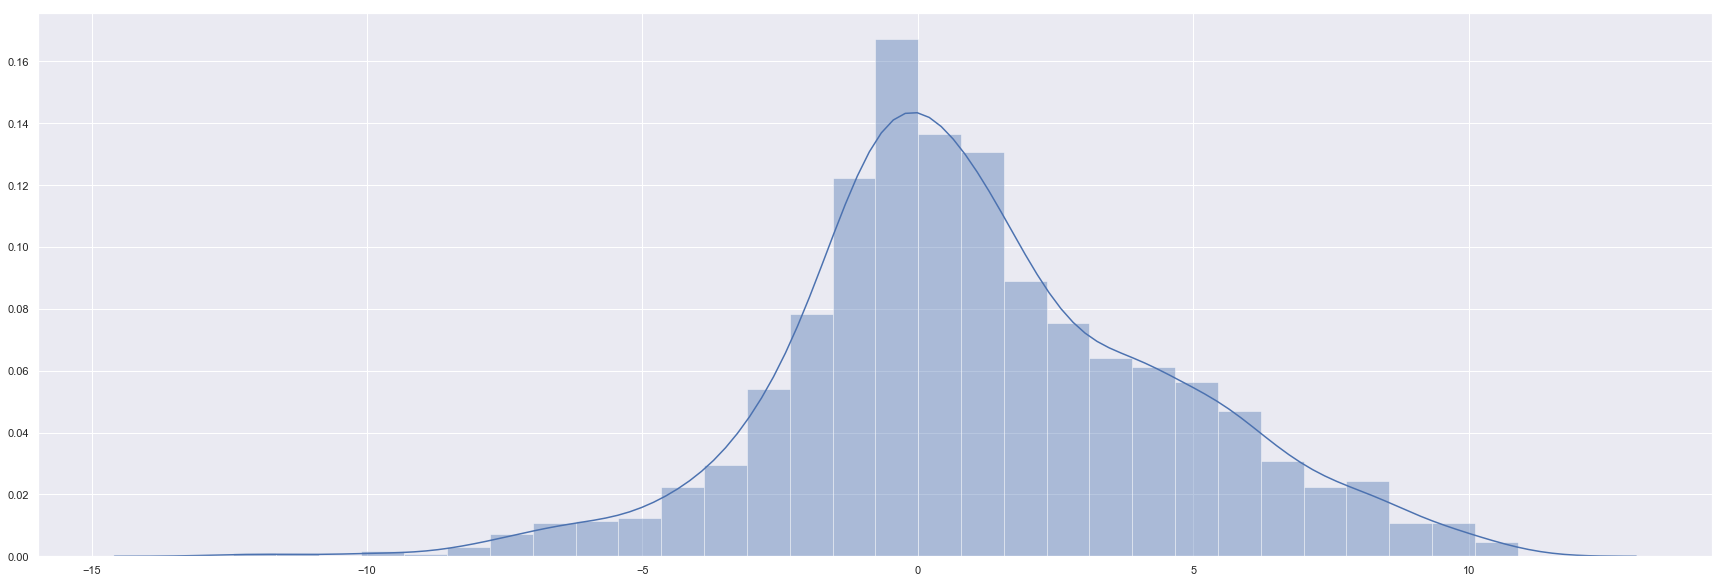

In [278]:
# Distribution of residuals
sns.distplot(y_test.compute() - xgb_predictions, bins=30)

### Optimize

In [282]:
with parallel_backend('dask'):

    # Create the parameter grid based on the results of random search 
     param_grid_xgb = {
    "xgb__learning_rate": [0.1],
    'xgb__max_depth': [8],
    'xgb__n_estimators': [50, 20]
    }

In [280]:
grid_search_xgb = GridSearchCV(
    estimator=xgb, param_grid=param_grid_xgb, cv=3, n_jobs=-1
)

In [281]:
client = Client()
client

<Client: scheduler='tcp://127.0.0.1:51120' processes=8 cores=8>

In [284]:
with parallel_backend('dask'):
    grid_search_xgb.fit(X_train, y_train)

TypeError: 'float' object cannot be interpreted as an integer

### 3.9 Gradient Boosting

Gradient boosting even provides us with a higher R2, thus we will also optimize parameters for this model.

In [287]:
model_gbr = GradientBoostingRegressor()
with parallel_backend("dask"):
    model_gbr.fit(X_train, np.ravel(y_train))

gbr_predictions = model_gbr.predict(X_test)

gbr_predictions = [
    i if i >= 0 else 0 for i in gbr_predictions
]  # in case a value is predicted as minus

# round prediction count to the nearest integer
gbr_predictions = [round(x) for x in gbr_predictions]

In [288]:
# root mean squared error
print("RMSE: %.2f" % np.sqrt(mean_squared_error(y_test.compute(), gbr_predictions)))
print("R2: %.2F" % r2_score(y_test.compute(), gbr_predictions))

RMSE: 3.62
R2: 0.74


#### Visual representations of predictions and distribution of errors:

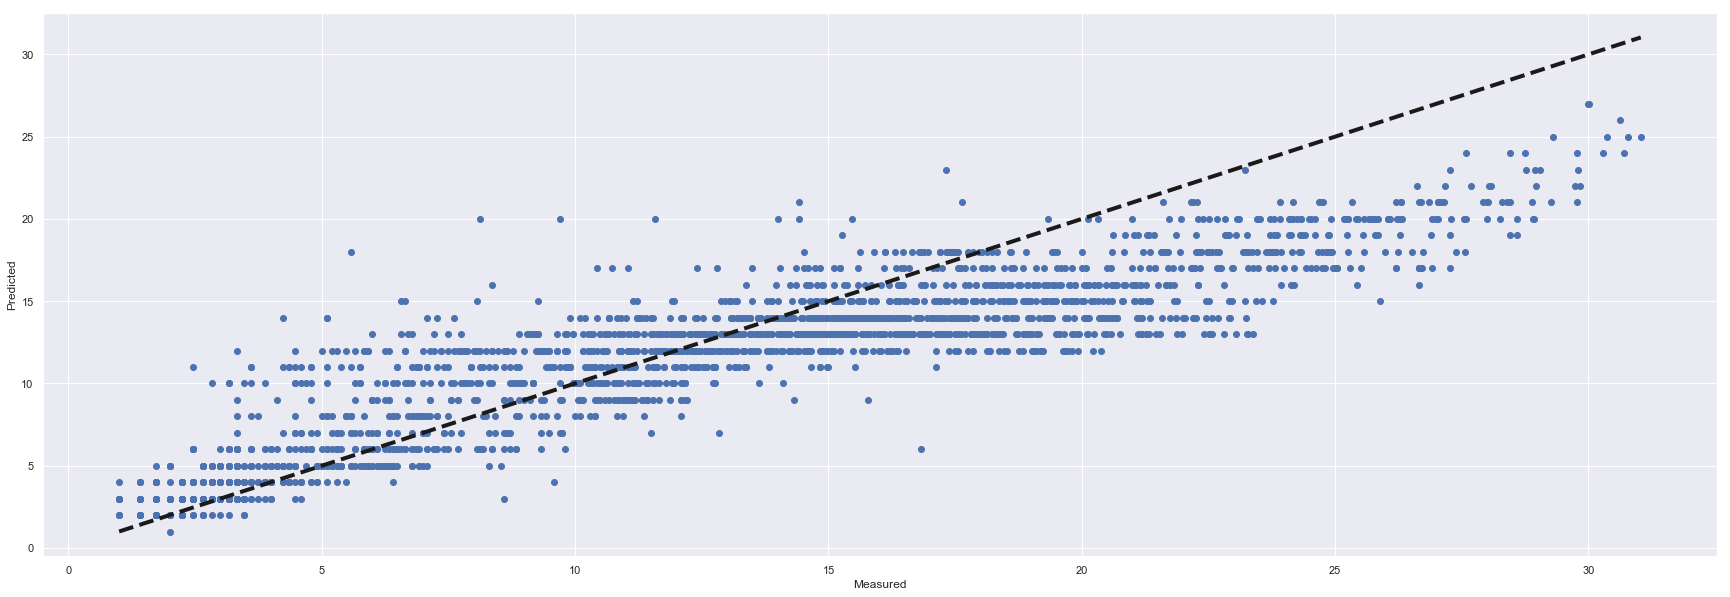

In [291]:
fig, ax = plt.subplots()
ax.scatter(y_test.compute(), gbr_predictions)
ax.plot(
    [y_test.compute().min(), y_test.compute().max()],
    [y_test.compute().min(), y_test.compute().max()],
    "k--",
    lw=4,
)
ax.set_xlabel("Measured")
ax.set_ylabel("Predicted")
fig.show()

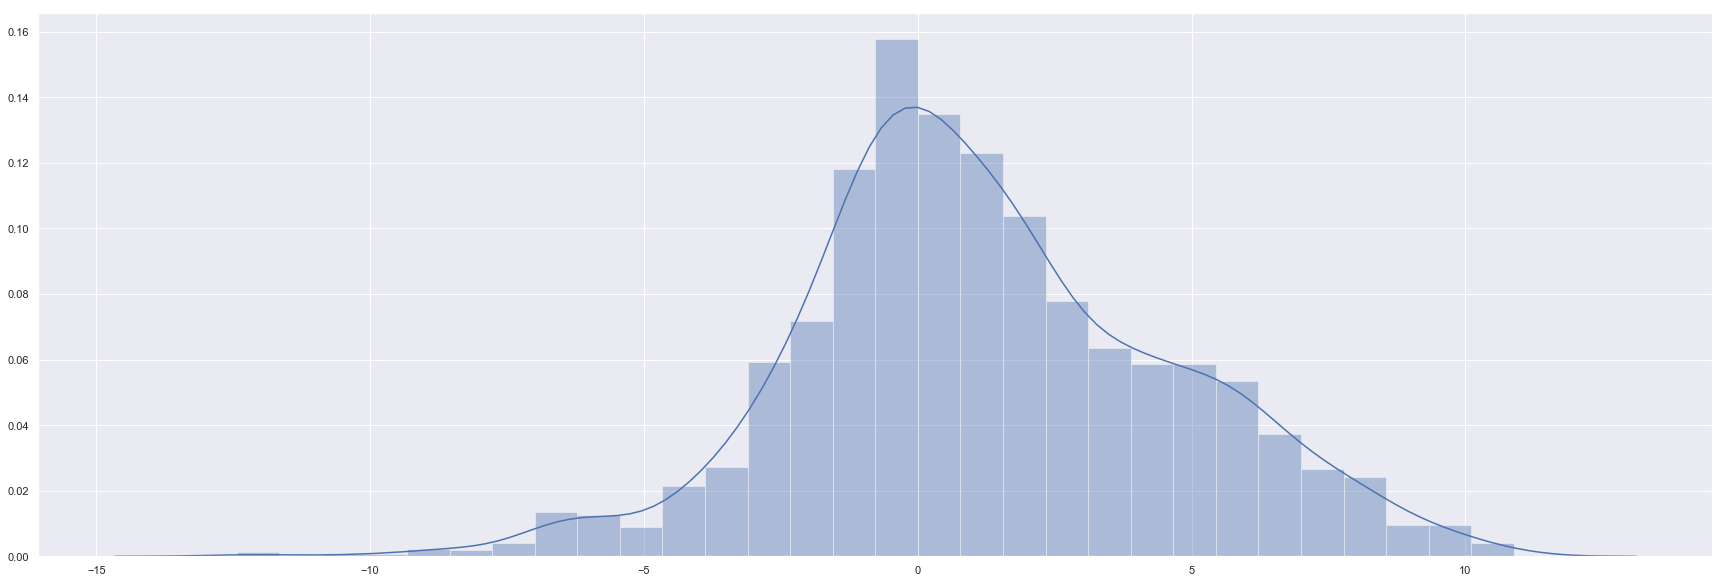

In [292]:
# Distribution of residuals
sns.distplot(y_test.compute() - gbr_predictions, bins=30)

## 4 Model Optimization
### 4.1 Random Forest

Using grid search as we know that random forest is a good fit for this problem:

In [ ]:
# Grid Search

parameters_rf = [
    {
        "n_estimators": [250, 350, 400, 500, 600],
        "max_features": ["auto", "sqrt", "log2"],
    }
]
grid_search_rf = GridSearchCV(estimator=rf, param_grid=parameters_rf)
grid_search_rf = grid_search_rf.fit(X_train, y_train)
best_parameters_rf = grid_search_rf.best_params_
best_accuracy_rf = grid_search_rf.best_score_

In [ ]:
best_parameters_rf

In [ ]:
best_accuracy_rf

In [ ]:
# Random Forest Regression model
# Use the best parameters found from above to build the model

regressor = RandomForestRegressor(n_estimators=250, max_features="auto")
regressor.fit(X_train, y_train)

# Predicting the values

rf_pred_2 = regressor.predict(X_test)

In [ ]:
rf_pred_2 = [
    i if i >= 0 else 0 for i in rf_pred_2
]  # in case a value is predicted as minus

# round prediction count to the nearest integer
rf_pred_2 = [round(x) for x in rf_pred_2]

In [ ]:
# Comparing predicted values with true values in testing set

print("RMSE: %.2f" % np.sqrt(mean_squared_error(y_test, rf_pred_2)))
print("R2: %.2F" % r2_score(y_test, rf_pred_2))

#### Visual representations of predictions and distribution of errors:

In [ ]:
fig, ax = plt.subplots()
ax.scatter(y_test, rf_pred_2)
ax.plot([y_test.min(), y_test.max()], [y_test.min(), y_test.max()], "k--", lw=4)
ax.set_xlabel("Measured")
ax.set_ylabel("Predicted")
fig.show()

In [ ]:
sns.distplot(y_test - rf_pred_2, bins=30)

### 4.2 Gradient Boosting

In [ ]:
# Grid Search
parameters_bgr = [
    {
        "n_estimators": [200, 400, 500, 700],
        "learning_rate": [0.01, 0.05, 0.1],
        "max_depth": [3, 5, 7],
        "max_features": ["auto", "sqrt", "log2"],
        "min_samples_leaf": [3, 5],
    }
]
grid_search_gbr = GridSearchCV(estimator=model_gbr, param_grid=parameters_bgr)
grid_search_gbr = grid_search_gbr.fit(X_train, y_train)
best_parameters_gbr = grid_search_gbr.best_params_
best_accuracy_gbr = grid_search_gbr.best_score_

In [ ]:
# check the best parameters to be used
best_parameters_gbr

In [ ]:
best_accuracy_gbr

In [ ]:
# Use the best parameters found from above to build the model
gbr_new = GradientBoostingRegressor(
    n_estimators=700,
    max_features="log2",
    max_depth=7,
    learning_rate=0.1,
    min_samples_leaf=3,
)
gbr_new.fit(X_train, y_train)

# Predicting the values
gbr_pred_2 = gbr_new.predict(X_test)

gbr_pred_2 = [
    i if i >= 0 else 0 for i in gbr_pred_2
]  # in case a value is predicted as minus

# round prediction count to the nearest integer
gbr_pred_2 = [round(x) for x in gbr_pred_2]

In [ ]:
# Comparing predicted values with true values in testing set
print("RMSE: %.2f" % np.sqrt(mean_squared_error(y_test, gbr_pred_2)))
print("R2: %.2F" % r2_score(y_test, gbr_pred_2))

#### Visual representations of predictions and distribution of errors:

In [ ]:
fig, ax = plt.subplots()
ax.scatter(y_test, gbr_pred_2)
ax.plot([y_test.min(), y_test.max()], [y_test.min(), y_test.max()], "k--", lw=4)
ax.set_xlabel("Measured")
ax.set_ylabel("Predicted")
fig.show()

In [ ]:
sns.distplot(y_test - gbr_pred_2, bins=30)

#### Cross Validation

In [ ]:
from sklearn.model_selection import cross_val_predict
from sklearn.model_selection import cross_val_score

predict = cross_val_predict(gbr_new, X_train, y_train, cv=10)

# Evaluating model in cross-validation iteration
r2_scores = cross_val_score(gbr_new, X_train, y_train, cv=10)
mse = cross_val_score(
    gbr_new, X_train, y_train, cv=10, scoring="neg_mean_squared_error"
)
accuracy = cross_val_score(estimator=gbr_new, X=X_train, y=y_train, cv=10)

fig, ax = plt.subplots()
ax.plot(range(0, 10), r2_scores)
ax.set_xlabel("Iteration")
ax.set_ylabel("R.Squared")
ax.set_title("Cross-Validation scores")
plt.show()


print("R-squared::{}".format(r2_scores))
print("Mean Accuracy::{}".format(accuracy.mean()))

### 4.3 XGBoost

In [ ]:
# Grid Search
parameters_xgb = [
    {
        "colsample_bytree": [0.1, 0.3, 0.5],
        "learning_rate": [0.001, 0.01, 0.05, 0.1],
        "max_depth": [3, 5, 7],
        "n_estimators": [350, 500, 600, 700],
    }
]
grid_search_xgb = GridSearchCV(estimator=model_xgb, param_grid=parameters_xgb)
grid_search_xgb = grid_search_xgb.fit(X_train, y_train)
best_parameters_xgb = grid_search_xgb.best_params_
best_accuracy_xgb = grid_search_xgb.best_score_

In [ ]:
best_parameters_xgb

In [ ]:
best_accuracy_xgb

In [ ]:
model_xgb1 = xgb.XGBRegressor(
    colsample_bytree=0.3, learning_rate=0.1, max_depth=5, n_estimators=700
)

model_xgb1.fit(X_train, y_train)

# Predicting the values
xgb_pred_2 = model_xgb1.predict(X_test)
xgb_pred_2 = [
    i if i >= 0 else 0 for i in xgb_pred_2
]  # in case a value is predicted as minus

# round prediction count to the nearest integer
xgb_pred_2 = [round(x) for x in xgb_pred_2]

In [ ]:
# Comparing predicted values with true values in testing set

print("RMSE: %.2f" % np.sqrt(mean_squared_error(y_test, xgb_pred_2)))
print("R2: %.2F" % r2_score(y_test, xgb_pred_2))

#### Visual representations of predictions and distribution of errors:

In [ ]:
fig, ax = plt.subplots()
ax.scatter(y_test, xgb_pred_2)
ax.plot([y_test.min(), y_test.max()], [y_test.min(), y_test.max()], "k--", lw=4)
ax.set_xlabel("Measured")
ax.set_ylabel("Predicted")
fig.show()

In [ ]:
sns.distplot(y_test - xgb_pred_2, bins=30)

#### Cross Validation

In [ ]:
from sklearn.model_selection import cross_val_predict
from sklearn.model_selection import cross_val_score

predict = cross_val_predict(model_xgb1, X_train, y_train, cv=10)

# Evaluating model in cross-validation iteration
r2_scores_xgb = cross_val_score(model_xgb1, X_train, y_train, cv=10)
mse_xgb = cross_val_score(
    model_xgb1, X_train, y_train, cv=10, scoring="neg_mean_squared_error"
)
accuracy_xgb = cross_val_score(estimator=model_xgb1, X=X_train, y=y_train, cv=10)


fig, ax = plt.subplots()
ax.plot(range(0, 10), r2_scores_xgb)
ax.set_xlabel("Iteration")
ax.set_ylabel("R.Squared")
ax.set_title("XGBoost Cross-Validation scores")
plt.show()


print("R-squared::{}".format(r2_scores_xgb))
print("Mean Accuracy::{}".format(accuracy_xgb.mean()))

### 4.4 Stacking
The main idea behind the structure of a stacked generalization is to use one or more first level models, make predictions using these models and then use these predictions as features to fit one or more second level models on top. To avoid overfitting, cross-validation is usually used to predict the OOF (out-of-fold) part of the training set. 

In [ ]:
# !pip install vecstack
from vecstack import stacking

In [ ]:
models = [model_xgb1, regressor, model_gbr]

S_train, S_test = stacking(
    models,
    X_train,
    y_train,
    X_test,
    regression=True,
    mode="oof_pred_bag",
    needs_proba=False,
    save_dir=None,
    metric=r2_score,
    n_folds=4,
    shuffle=True,
    random_state=0,
    verbose=2,
)

In [ ]:
stacked_model = xgb.XGBRegressor(
    colsample_bytree=0.3, learning_rate=0.1, max_depth=5, n_estimators=700
)
stacked_model = stacked_model.fit(S_train, y_train)
stacked_pred = stacked_model.predict(S_test)

stacked_pred = [
    i if i >= 0 else 0 for i in stacked_pred
]  # in case a value is predicted as minus

# round prediction count to the nearest integer
stacked_pred = [round(x) for x in stacked_pred]

print("RMSE: %.2f" % np.sqrt(mean_squared_error(y_test, stacked_pred)))
print("R2: %.3F" % r2_score(y_test, stacked_pred))

#### Visual representations of predictions and distribution of errors:

In [ ]:
fig, ax = plt.subplots()
ax.scatter(y_test, stacked_pred)
ax.plot([y_test.min(), y_test.max()], [y_test.min(), y_test.max()], "k--", lw=4)
ax.set_xlabel("Measured")
ax.set_ylabel("Predicted")
fig.show()

In [ ]:
sns.distplot(y_test - stacked_pred, bins=30)

## 5 Conclusion

### 5.1 Compare Models

In [ ]:
print("Random Forest")
print("RMSE: %.2f" % np.sqrt(mean_squared_error(y_test, rf_pred_2)))
print("R2: %.2F" % r2_score(y_test, rf_pred_2))
print("XGBoost")
print("RMSE: %.2f" % np.sqrt(mean_squared_error(y_test, xgb_pred_2)))
print("R2: %.2F" % r2_score(y_test, xgb_pred_2))
print("Gradient Boosting Regressor")
print("RMSE: %.2f" % np.sqrt(mean_squared_error(y_test, gbr_pred_2)))
print("R2: %.2F" % r2_score(y_test, gbr_pred_2))
print("Stacked Model")
print("RMSE: %.2f" % np.sqrt(mean_squared_error(y_test, stacked_pred)))
print("R2: %.2F" % r2_score(y_test, stacked_pred))

### 5.2 Crossvalidation for final model

### 5.3 Best prediction

The best model we got was achieved by Gradient Boosting Regressor and scored a R2 of 0.89. Below we can see (again) the graphical representation of the predictions compared to the actual count and the distribution of the errors. We can clearly see (also graphically) that the model fits the actual data fine and the errors are distributed around 0.

In [ ]:
fig, ax = plt.subplots()
ax.scatter(y_test, gbr_pred_2)
ax.plot([y_test.min(), y_test.max()], [y_test.min(), y_test.max()], "k--", lw=4)
ax.set_xlabel("Measured")
ax.set_ylabel("Predicted")
fig.show()

In [ ]:
sns.distplot(y_test - xgb_pred_2, bins=30)

# 6 Wrap up

Finally we will point out our general work approach, difficulties and addidtional improvements that could be made.

### Work Approach
As usual for group projects we sat together at the very beginning to decide upon a approach and how to take further steps. This inluded splitting the work among group members to work efficiently. To be kept up to date we met occasionally and discussed outcomes and the progress.

### Difficulties
As the data was "clean" (except of a few outliers) from the beginning on, the largest difficulty during this project was splitting work efficiently and especially the computational limitations of our computer. This means that for example grid searches very time intensive and forced us to reconvene. 

### Possible Additional Improvements
- Pipelines could have been used to obtain a clearer workflow. However, we think that the focus on gaining higher model performance more value adding.
- Within the pipeline we could've created polynomial features in order to grasp non linear relationships between the dependent variables.
- External data could have been taken into account, although the implementation of this data has to be done carefully. For example, we could take into account crime rates by hour of day, or more specific location data within the city. 
- We could have used log transformation in order to avoid negative predictions instead of running our for loop. 
